# Black Carbon Analysis Notebook

## Setup and Data Loading

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import calendar
import plotly.express as px
from scipy import stats
import os

# Create output directories
def setup_directories():
    dirs = {
        'plots': 'output/plots/analysis',
        'data': 'output/data/analysis'
    }
    for dir_path in dirs.values():
        os.makedirs(dir_path, exist_ok=True)
    return dirs

dirs = setup_directories()

## Data Loading and Preprocessing

In [17]:
def load_and_process_data(filepath):
    # Read the CSV file
    df = pd.read_csv(filepath)
    
    # Convert to datetime and set timezone
    df['Time (UTC)'] = pd.to_datetime(df['Time (UTC)'], utc=True)
    df['Time (Local)'] = df['Time (UTC)'].dt.tz_convert('Africa/Addis_Ababa')
    df.set_index('Time (Local)', inplace=True)
    
    # Define wavelengths and ALL BC columns present in your data
    wavelengths = {'UV': 375, 'Blue': 470, 'Green': 528, 'Red': 625, 'IR': 880}
    bc_columns = [
        # UV measurements
        'UV BC1', 'UV BC2', 'UV BCc',
        # Blue measurements
        'Blue BC1', 'Blue BC2', 'Blue BCc',
        # Green measurements
        'Green BC1', 'Green BC2', 'Green BCc',
        # Red measurements
        'Red BC1', 'Red BC2', 'Red BCc',
        # IR measurements
        'IR BC1', 'IR BC2', 'IR BCc'
    ]
    
    # Convert from ng/m³ to µg/m³ for all BC columns
    for col in bc_columns:
        if col in df.columns:
            df[col] = df[col] / 1000
        else:
            print(f"Warning: Column {col} not found - skipping")
    
    # Add time-based columns
    df['Month'] = df.index.month
    df['Hour'] = df.index.hour
    df['DayOfWeek'] = df.index.dayofweek
    df['Season'] = df.index.month.map({
        12:'Winter', 1:'Winter', 2:'Winter',
        3:'Spring', 4:'Spring', 5:'Spring',
        6:'Summer', 7:'Summer', 8:'Summer',
        9:'Fall', 10:'Fall', 11:'Fall'
    })
    
    # Handle outliers and negative values for all BC columns
    for col in bc_columns:
        if col in df.columns:
            # Remove negative values
            df.loc[df[col] < 0, col] = np.nan
            
            # Remove extreme outliers (3 std dev)
            mean = df[col].mean()
            std = df[col].std()
            upper_limit = mean + 3*std
            df.loc[df[col] > upper_limit, col] = np.nan
    
    return df, wavelengths, bc_columns

# Load your data
filepath = "/Users/ahmadjalil/Library/CloudStorage/GoogleDrive-ahzs645@gmail.com/My Drive/University/Research/Grad/UC Davis Ann/NASA MAIA/Data/Aethelometry Data/Jacros_MA350_1-min_2022-2024_Cleaned.csv"  # Update with your file path
df, wavelengths, bc_columns = load_and_process_data(filepath)

print("\nSuccessfully processed BC columns:")
print([col for col in bc_columns if col in df.columns])


Successfully processed BC columns:
['UV BC1', 'UV BC2', 'UV BCc', 'Blue BC1', 'Blue BC2', 'Blue BCc', 'Green BC1', 'Green BC2', 'Green BCc', 'Red BC1', 'Red BC2', 'Red BCc', 'IR BC1', 'IR BC2', 'IR BCc']


## 1. Source Apportionment Analysis

### 1.1 Calculate Absorption Ångström Exponent (AAE)


Revised Analysis Results:
Total measurements: 1095086
Valid measurements after all filters: 1005468
Measurements removed: 89618

AAE Statistics:
Mean AAE: -0.012
Median AAE: -0.023
Std Dev AAE: 0.507

Source Distribution:
Fossil Fuel %: 95.7%
Mixed %: 2.9%
Biomass %: 1.4%


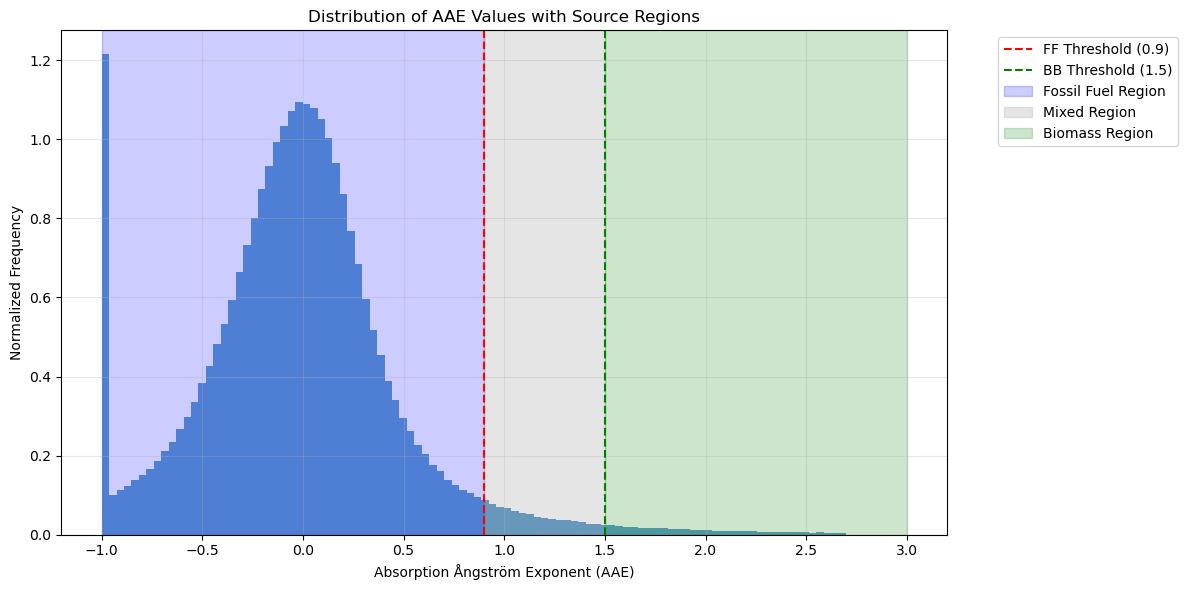

In [21]:
def calculate_aae_revised(df):
    """
    Calculate AAE with improved validation and realistic constraints
    """
    # Ensure positive values before taking log
    valid_mask = (df['UV BCc'] > 0) & (df['IR BCc'] > 0)
    
    # Calculate BC ratio for valid data
    bc_ratio = df.loc[valid_mask, 'UV BCc'] / df.loc[valid_mask, 'IR BCc']
    
    # Remove extreme ratios (using reasonable physical limits)
    ratio_mask = (bc_ratio > 0.1) & (bc_ratio < 10)
    bc_ratio = bc_ratio[ratio_mask]
    
    # Calculate wavelength ratio
    wavelength_ratio = np.log(880/375)
    
    # Calculate AAE
    aae = pd.Series(index=df.index, dtype=float)
    aae.loc[valid_mask] = np.log(bc_ratio) / wavelength_ratio
    
    # Apply physical constraints to AAE values
    aae = aae.clip(-1, 3)  # Constrain to physically reasonable range
    
    # Calculate source contributions including all valid data
    total_valid = aae.notna().sum()
    source_contribution = {
        'Fossil Fuel %': (aae < 0.9).sum() / total_valid * 100,
        'Mixed %': ((aae >= 0.9) & (aae <= 1.5)).sum() / total_valid * 100,
        'Biomass %': (aae > 1.5).sum() / total_valid * 100
    }
    
    # Print detailed statistics
    print("\nRevised Analysis Results:")
    print(f"Total measurements: {len(df)}")
    print(f"Valid measurements after all filters: {total_valid}")
    print(f"Measurements removed: {len(df) - total_valid}")
    
    print("\nAAE Statistics:")
    valid_aae = aae.dropna()
    print(f"Mean AAE: {valid_aae.mean():.3f}")
    print(f"Median AAE: {valid_aae.median():.3f}")
    print(f"Std Dev AAE: {valid_aae.std():.3f}")
    
    print("\nSource Distribution:")
    for source, percentage in source_contribution.items():
        print(f"{source}: {percentage:.1f}%")
    
    # Create detailed distribution plot
    plt.figure(figsize=(12, 6))
    
    # Plot histogram with smaller bins for better resolution
    plt.hist(valid_aae, bins=100, alpha=0.7, density=True)
    
    # Add vertical lines for source regions
    plt.axvline(x=0.9, color='r', linestyle='--', label='FF Threshold (0.9)')
    plt.axvline(x=1.5, color='g', linestyle='--', label='BB Threshold (1.5)')
    
    # Fill source regions with colors
    plt.axvspan(-1, 0.9, alpha=0.2, color='blue', label='Fossil Fuel Region')
    plt.axvspan(0.9, 1.5, alpha=0.2, color='gray', label='Mixed Region')
    plt.axvspan(1.5, 3, alpha=0.2, color='green', label='Biomass Region')
    
    plt.xlabel('Absorption Ångström Exponent (AAE)')
    plt.ylabel('Normalized Frequency')
    plt.title('Distribution of AAE Values with Source Regions')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    
    return aae, source_contribution

# Calculate revised AAE
aae_revised, source_contrib = calculate_aae_revised(df)


Step 1: Input Data Check
UV BCc Statistics:
count    1.045111e+06
mean     7.165190e+00
std      6.090499e+00
min      0.000000e+00
25%      3.030000e+00
50%      5.314000e+00
75%      9.175000e+00
max      3.344500e+01
Name: UV BCc, dtype: float64

IR BCc Statistics:
count    1.041000e+06
mean     7.561619e+00
std      6.529681e+00
min      0.000000e+00
25%      3.105000e+00
50%      5.568000e+00
75%      9.733000e+00
max      3.533800e+01
Name: IR BCc, dtype: float64

Step 2: Unit Check
UV BCc units range: 0.00 to 33.45
IR BCc units range: 0.00 to 35.34

Step 3: BC Ratio Check
BC ratio statistics:
count    1.016067e+06
mean     1.364177e+00
std      1.344130e+01
min      6.314327e-05
25%      7.782758e-01
50%      9.807008e-01
75%      1.214631e+00
max      4.727000e+03
dtype: float64

Step 4: Log Ratio Check
Log ratio statistics:
count    1.016067e+06
mean    -2.801917e-02
std      5.852503e-01
min     -9.670104e+00
25%     -2.506744e-01
50%     -1.948789e-02
75%      1.944403e-01


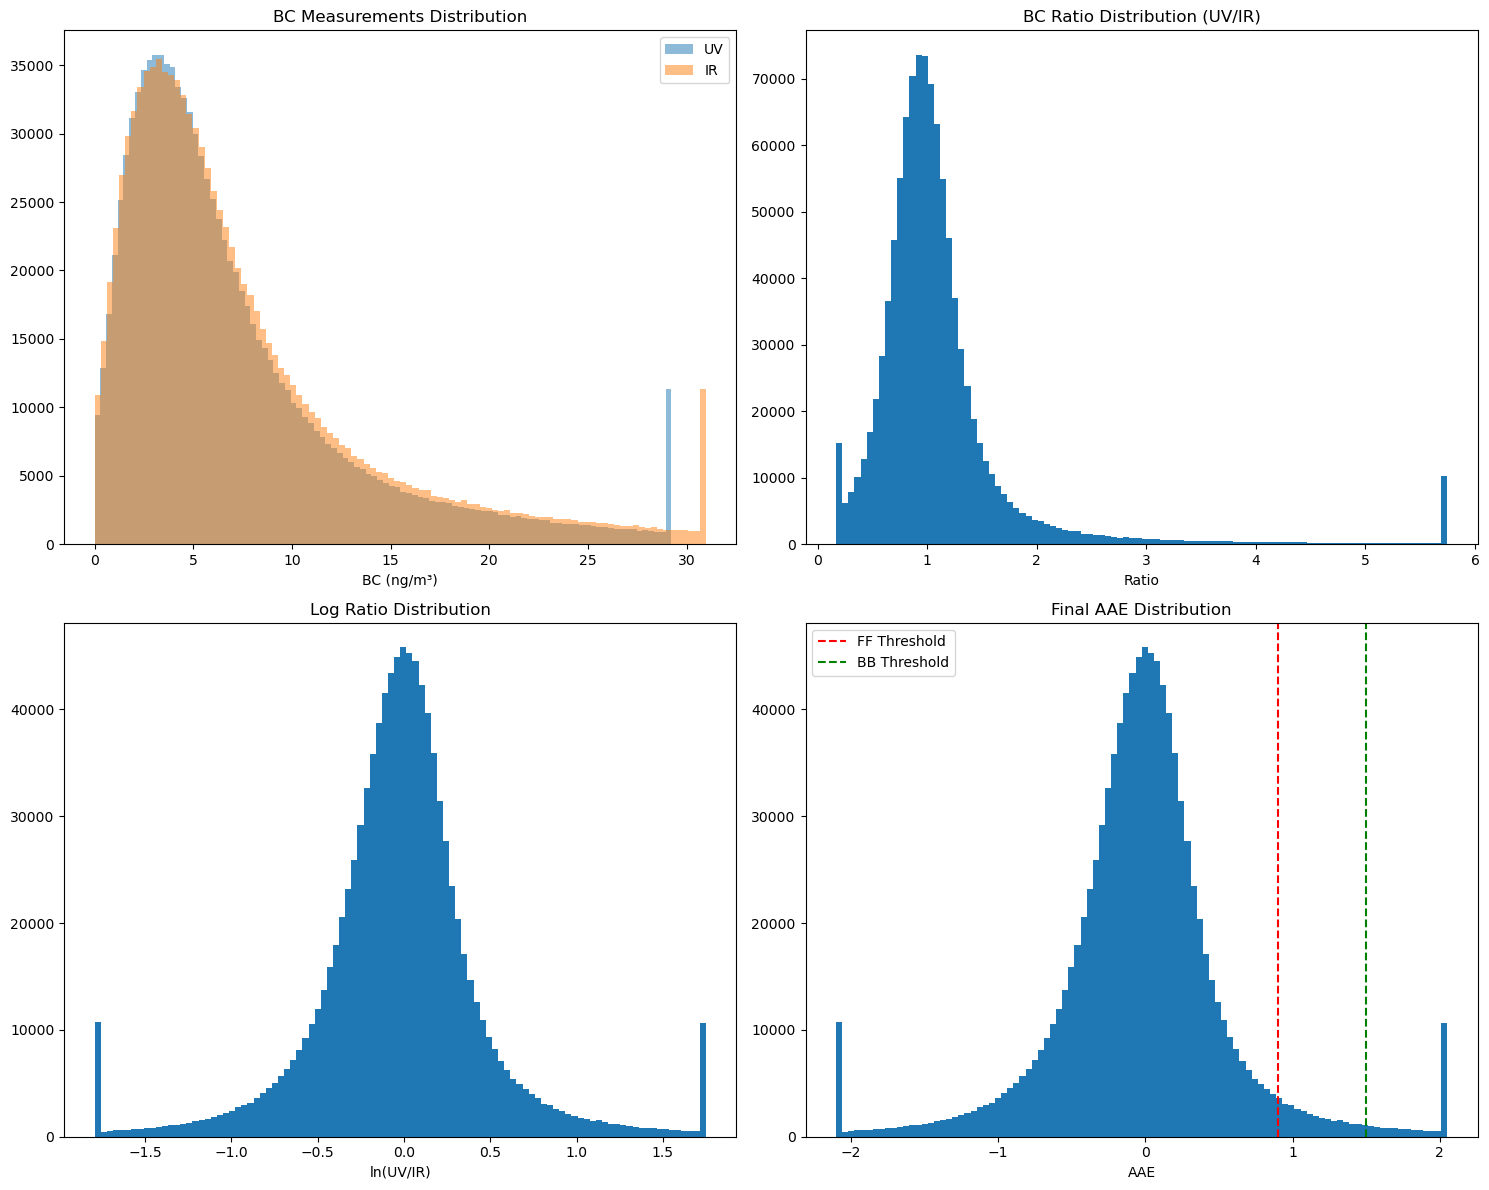

In [28]:
def diagnose_aae_calculation(df):
    """
    Detailed diagnostic of AAE calculation with step-by-step validation
    """
    print("\nStep 1: Input Data Check")
    print("UV BCc Statistics:")
    print(df['UV BCc'].describe())
    print("\nIR BCc Statistics:")
    print(df['IR BCc'].describe())
    
    # Step 2: Check units and convert if needed
    # Aethalometer data should be in ng/m³
    print("\nStep 2: Unit Check")
    print("UV BCc units range:", f"{df['UV BCc'].min():.2f} to {df['UV BCc'].max():.2f}")
    print("IR BCc units range:", f"{df['IR BCc'].min():.2f} to {df['IR BCc'].max():.2f}")
    
    # Step 3: Calculate ratio
    valid_mask = (df['UV BCc'] > 0) & (df['IR BCc'] > 0)
    bc_ratio = df.loc[valid_mask, 'UV BCc'] / df.loc[valid_mask, 'IR BCc']
    
    print("\nStep 3: BC Ratio Check")
    print("BC ratio statistics:")
    print(bc_ratio.describe())
    
    # Step 4: Log of ratio
    log_ratio = np.log(bc_ratio)
    print("\nStep 4: Log Ratio Check")
    print("Log ratio statistics:")
    print(log_ratio.describe())
    
    # Step 5: Wavelength calculation
    wavelength_ratio = np.log(880/375)
    print("\nStep 5: Wavelength Ratio Check")
    print(f"Wavelength ratio (ln(880/375)): {wavelength_ratio:.3f}")
    
    # Step 6: Final AAE calculation
    aae = log_ratio / wavelength_ratio
    print("\nStep 6: Final AAE Check")
    print("AAE statistics:")
    print(aae.describe())
    
    # Plot distributions at each step
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
    
    # Plot BC values
    ax1.hist(df['UV BCc'].clip(0, df['UV BCc'].quantile(0.99)), bins=100, alpha=0.5, label='UV')
    ax1.hist(df['IR BCc'].clip(0, df['IR BCc'].quantile(0.99)), bins=100, alpha=0.5, label='IR')
    ax1.set_title('BC Measurements Distribution')
    ax1.set_xlabel('BC (ng/m³)')
    ax1.legend()
    
    # Plot BC ratio
    ax2.hist(bc_ratio.clip(bc_ratio.quantile(0.01), bc_ratio.quantile(0.99)), bins=100)
    ax2.set_title('BC Ratio Distribution (UV/IR)')
    ax2.set_xlabel('Ratio')
    
    # Plot log ratio
    ax3.hist(log_ratio.clip(log_ratio.quantile(0.01), log_ratio.quantile(0.99)), bins=100)
    ax3.set_title('Log Ratio Distribution')
    ax3.set_xlabel('ln(UV/IR)')
    
    # Plot final AAE
    ax4.hist(aae.clip(aae.quantile(0.01), aae.quantile(0.99)), bins=100)
    ax4.set_title('Final AAE Distribution')
    ax4.set_xlabel('AAE')
    ax4.axvline(x=0.9, color='r', linestyle='--', label='FF Threshold')
    ax4.axvline(x=1.5, color='g', linestyle='--', label='BB Threshold')
    ax4.legend()
    
    plt.tight_layout()
    
    return aae, bc_ratio, log_ratio

# Run diagnostic
aae, bc_ratio, log_ratio = diagnose_aae_calculation(df)


BCc Analysis Results:
Initial total measurements: 1095086
Valid measurements after basic filters: 1016067
Valid measurements after ratio filter: 1005468
Measurements removed by ratio filter: 10599

Cleaned BC Ratio Statistics (IR/UV):
count    1005468.000
mean           1.161
std            0.743
min            0.100
25%            0.825
50%            1.020
75%            1.281
max           10.000
dtype: float64

AAE Statistics:
Mean AAE: 0.032
Median AAE: 0.023
Std Dev AAE: 0.560

Source Distribution:
Fossil Fuel %: 94.8%
Mixed %: 3.6%
Biomass %: 1.6%


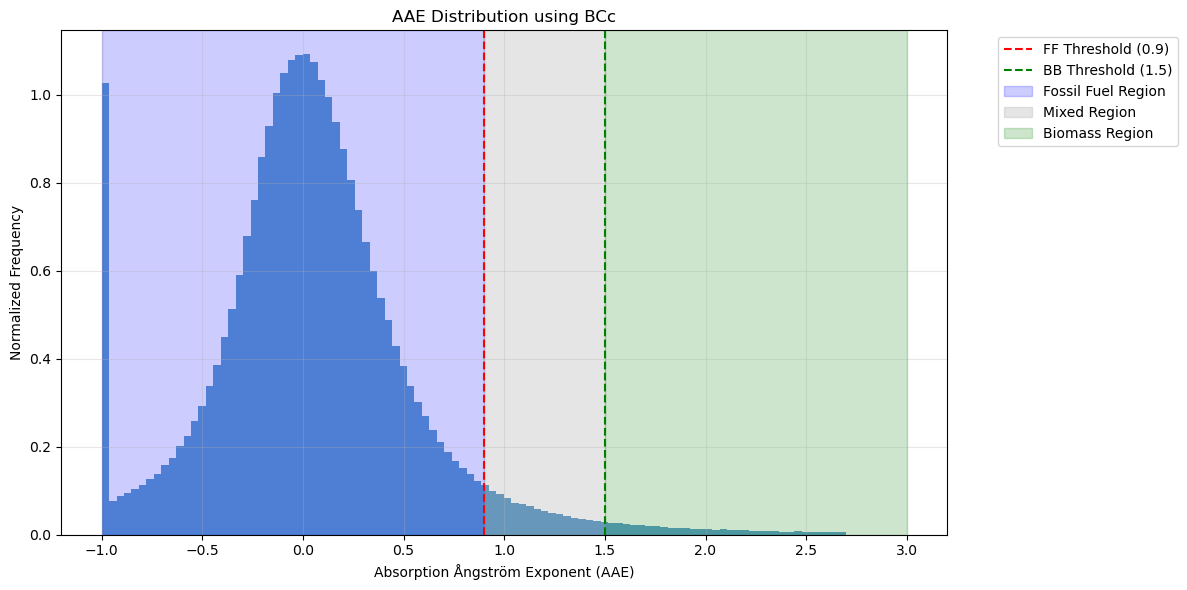

In [20]:
def calculate_bcc_aae(df):
    """
    Calculate AAE using BCc with additional data quality filters
    """
    # Initial valid data mask
    valid_mask = (df['UV BCc'] > 0) & (df['IR BCc'] > 0)
    
    # Calculate initial BC ratio
    bc_ratio = df.loc[valid_mask, 'IR BCc'] / df.loc[valid_mask, 'UV BCc']
    
    # Add ratio filter to remove extreme values
    ratio_mask = (bc_ratio > 0.1) & (bc_ratio < 10)  # Reasonable physical limits
    clean_ratio = bc_ratio[ratio_mask]
    
    # Calculate wavelength ratio
    wavelength_ratio = np.log(880/375)
    
    # Calculate AAE
    aae = pd.Series(index=df.index, dtype=float)
    valid_indices = bc_ratio[ratio_mask].index
    aae.loc[valid_indices] = np.log(clean_ratio) / wavelength_ratio
    
    # Print detailed diagnostics
    print("\nBCc Analysis Results:")
    print(f"Initial total measurements: {len(df)}")
    print(f"Valid measurements after basic filters: {valid_mask.sum()}")
    print(f"Valid measurements after ratio filter: {len(clean_ratio)}")
    print(f"Measurements removed by ratio filter: {valid_mask.sum() - len(clean_ratio)}")
    
    print("\nCleaned BC Ratio Statistics (IR/UV):")
    print(clean_ratio.describe().round(3))
    
    print("\nAAE Statistics:")
    valid_aae = aae.dropna()
    print(f"Mean AAE: {valid_aae.mean():.3f}")
    print(f"Median AAE: {valid_aae.median():.3f}")
    print(f"Std Dev AAE: {valid_aae.std():.3f}")
    
    # Calculate source contributions
    total_valid = valid_aae.count()
    source_contribution = {
        'Fossil Fuel %': (valid_aae < 0.9).sum() / total_valid * 100,
        'Mixed %': ((valid_aae >= 0.9) & (valid_aae <= 1.5)).sum() / total_valid * 100,
        'Biomass %': (valid_aae > 1.5).sum() / total_valid * 100
    }
    
    print("\nSource Distribution:")
    for source, percentage in source_contribution.items():
        print(f"{source}: {percentage:.1f}%")
    
    # Create visualization
    plt.figure(figsize=(12, 6))
    plt.hist(valid_aae.clip(-1, 3), bins=100, density=True, alpha=0.7)
    plt.axvline(x=0.9, color='r', linestyle='--', label='FF Threshold (0.9)')
    plt.axvline(x=1.5, color='g', linestyle='--', label='BB Threshold (1.5)')
    plt.axvspan(-1, 0.9, alpha=0.2, color='blue', label='Fossil Fuel Region')
    plt.axvspan(0.9, 1.5, alpha=0.2, color='gray', label='Mixed Region')
    plt.axvspan(1.5, 3, alpha=0.2, color='green', label='Biomass Region')
    plt.xlabel('Absorption Ångström Exponent (AAE)')
    plt.ylabel('Normalized Frequency')
    plt.title('AAE Distribution using BCc')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    
    return aae, source_contribution, clean_ratio

# Calculate AAE using BCc
aae_bcc, source_contrib_bcc, clean_ratio_bcc = calculate_bcc_aae(df)

Valid measurements: 1,016,067 of 1,095,086
Measurements after ratio filtering: 1,005,468

AAE Statistics:
count    1005468.000
mean           0.050
std            0.510
min           -1.000
25%           -0.225
50%            0.023
75%            0.290
max            2.699
dtype: float64

Source Attribution:
Fossil Fuel (AAE < 0.9): 94.8%
Mixed (0.9 ≤ AAE ≤ 1.5): 3.6%
Biomass (AAE > 1.5): 1.6%


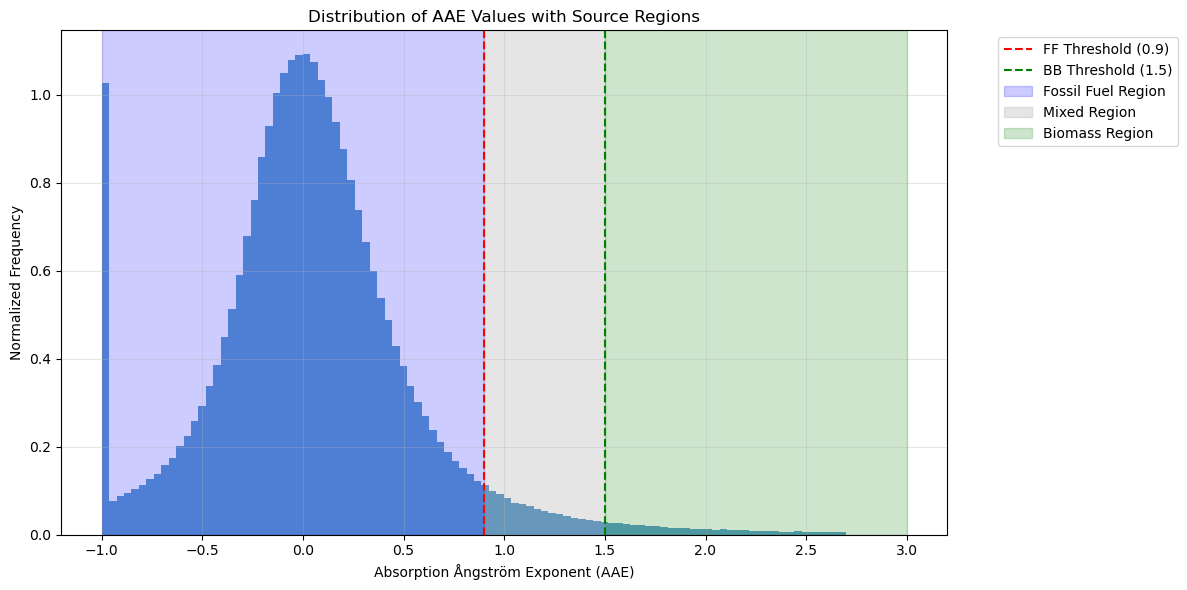

In [29]:
def calculate_corrected_aae(df):
    """
    Calculate AAE with corrected ratio orientation and proper filtering
    """
    # 1. Basic data filtering
    valid_mask = (df['UV BCc'] > 0) & (df['IR BCc'] > 0)
    print(f"Valid measurements: {valid_mask.sum():,} of {len(df):,}")
    
    # 2. Calculate ratio (IR/UV instead of UV/IR)
    bc_ratio = df.loc[valid_mask, 'IR BCc'] / df.loc[valid_mask, 'UV BCc']
    
    # 3. Filter extreme ratios
    reasonable_ratio = (bc_ratio > 0.1) & (bc_ratio < 10)
    bc_ratio = bc_ratio[reasonable_ratio]
    print(f"Measurements after ratio filtering: {len(bc_ratio):,}")
    
    # 4. Calculate AAE
    wavelength_ratio = np.log(880/375)
    aae = np.log(bc_ratio) / wavelength_ratio
    
    # 5. Remove extreme AAE values
    aae_filtered = aae.clip(-1, 3)
    
    # Print statistics
    print("\nAAE Statistics:")
    print(aae_filtered.describe().round(3))
    
    # Calculate source contributions
    total_valid = len(aae_filtered)
    ff_pct = (aae_filtered < 0.9).sum() / total_valid * 100
    mixed_pct = ((aae_filtered >= 0.9) & (aae_filtered <= 1.5)).sum() / total_valid * 100
    bb_pct = (aae_filtered > 1.5).sum() / total_valid * 100
    
    print("\nSource Attribution:")
    print(f"Fossil Fuel (AAE < 0.9): {ff_pct:.1f}%")
    print(f"Mixed (0.9 ≤ AAE ≤ 1.5): {mixed_pct:.1f}%")
    print(f"Biomass (AAE > 1.5): {bb_pct:.1f}%")
    
    # Create visualization
    plt.figure(figsize=(12, 6))
    plt.hist(aae_filtered, bins=100, alpha=0.7, density=True)
    
    # Add thresholds
    plt.axvline(x=0.9, color='r', linestyle='--', label='FF Threshold (0.9)')
    plt.axvline(x=1.5, color='g', linestyle='--', label='BB Threshold (1.5)')
    
    # Add source regions
    plt.axvspan(-1, 0.9, alpha=0.2, color='blue', label='Fossil Fuel Region')
    plt.axvspan(0.9, 1.5, alpha=0.2, color='gray', label='Mixed Region')
    plt.axvspan(1.5, 3, alpha=0.2, color='green', label='Biomass Region')
    
    plt.xlabel('Absorption Ångström Exponent (AAE)')
    plt.ylabel('Normalized Frequency')
    plt.title('Distribution of AAE Values with Source Regions')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    
    return aae_filtered, bc_ratio

aae_corrected, ratio_corrected = calculate_corrected_aae(df)
plt.show()

#Section 1.12:


MAC Values - UV: 7.77, IR: 7.77
Overall Mean AAE: 0.060
Overall Median AAE: 0.023

Source Attribution:
Fossil Fuel: 94.4%
Mixed: 3.5%
Biomass: 2.1%

Seasonal Statistics:

Dry Season:
Mean AAE: 0.069
Median AAE: 0.023
Source distribution:
  Fossil Fuel: 93.1%
  Mixed: 4.2%
  Biomass: 2.7%

Belg Rainy Season:
Mean AAE: 0.049
Median AAE: 0.014
Source distribution:
  Fossil Fuel: 94.8%
  Mixed: 3.2%
  Biomass: 1.9%

Kiremt Rainy Season:
Mean AAE: 0.061
Median AAE: 0.029
Source distribution:
  Fossil Fuel: 95.4%
  Mixed: 3.0%
  Biomass: 1.6%

MAC Values - UV: 10.0, IR: 7.77
Overall Mean AAE: -0.219
Overall Median AAE: -0.273

Source Attribution:
Fossil Fuel: 96.7%
Mixed: 1.9%
Biomass: 1.4%

Seasonal Statistics:

Dry Season:
Mean AAE: -0.206
Median AAE: -0.272
Source distribution:
  Fossil Fuel: 95.8%
  Mixed: 2.3%
  Biomass: 1.9%

Belg Rainy Season:
Mean AAE: -0.231
Median AAE: -0.282
Source distribution:
  Fossil Fuel: 97.0%
  Mixed: 1.7%
  Biomass: 1.3%

Kiremt Rainy Season:
Mean AAE: -0

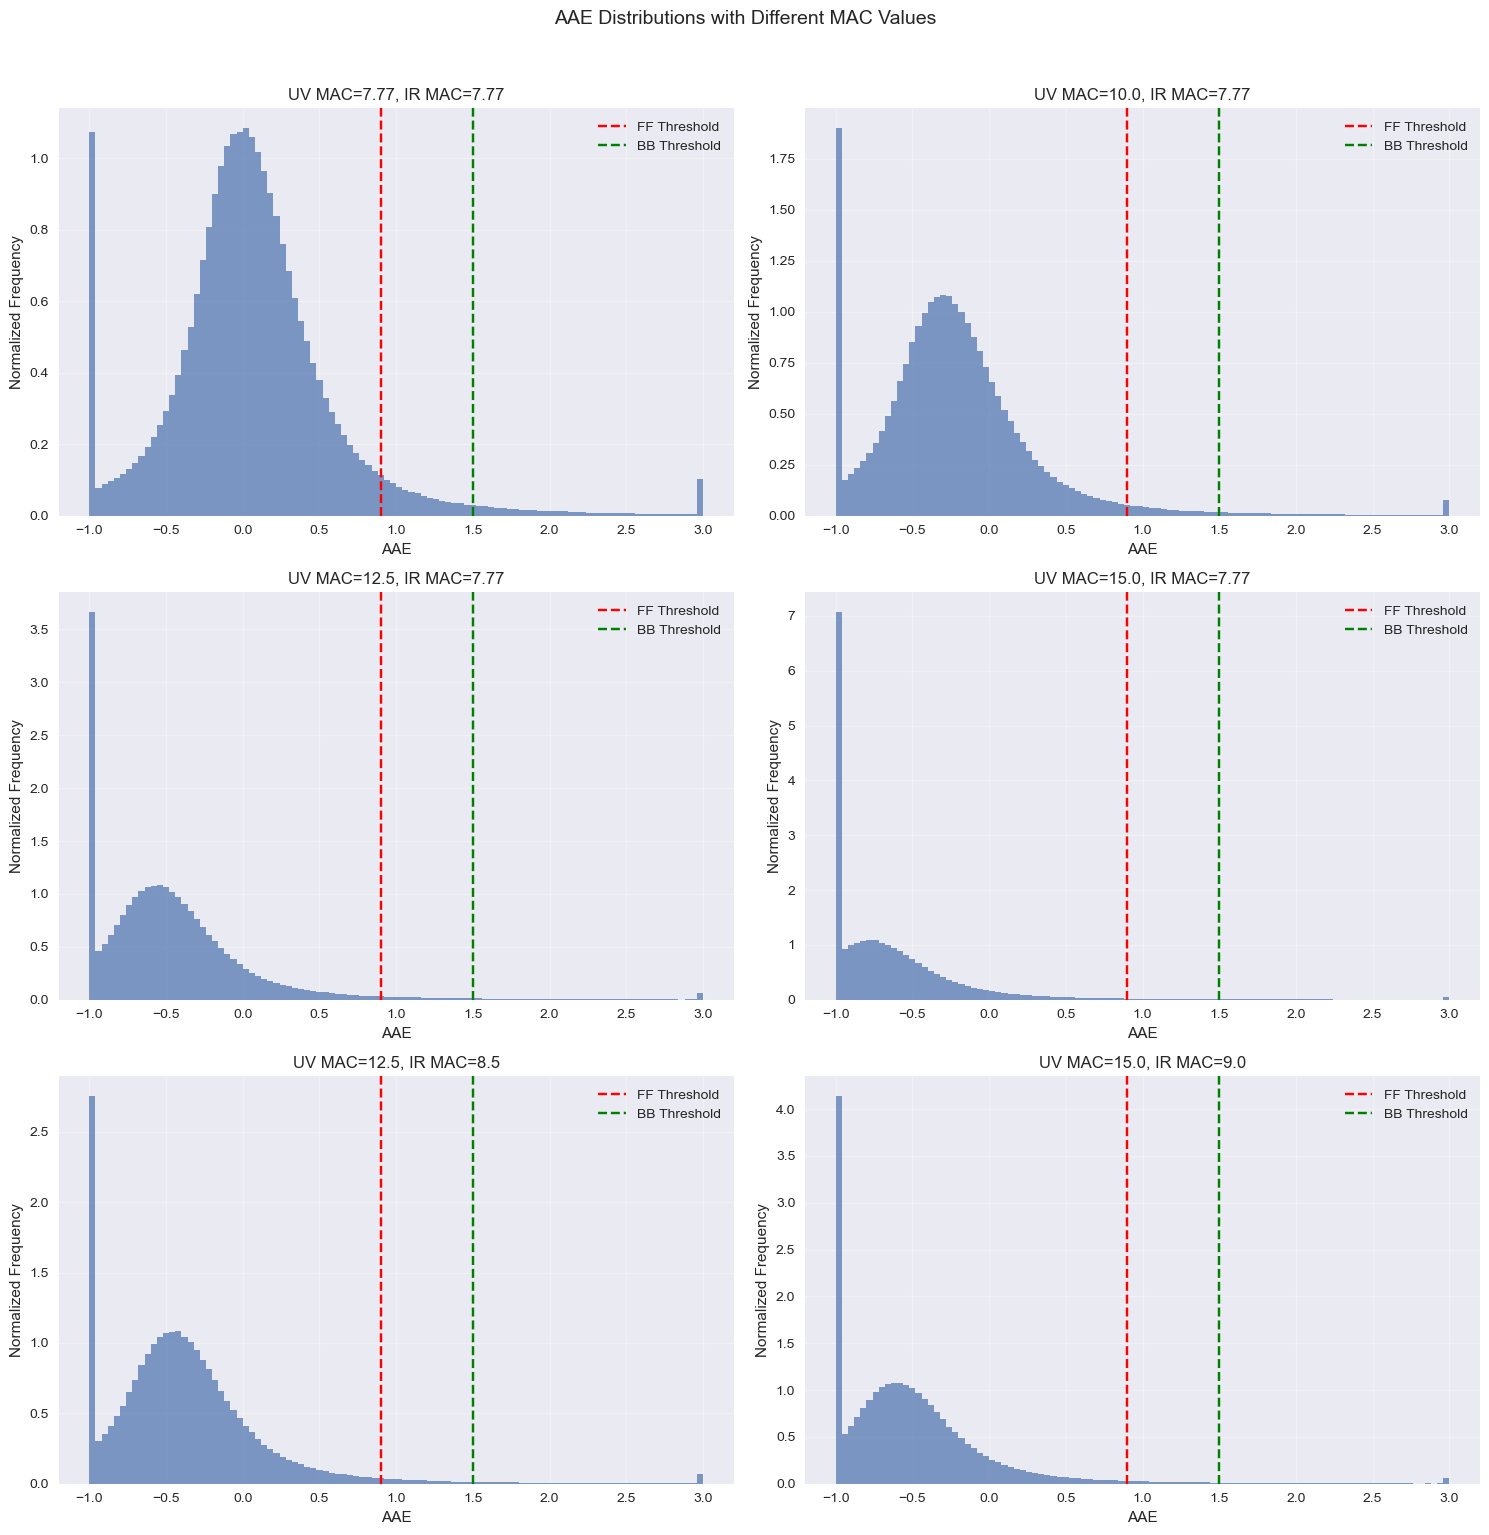

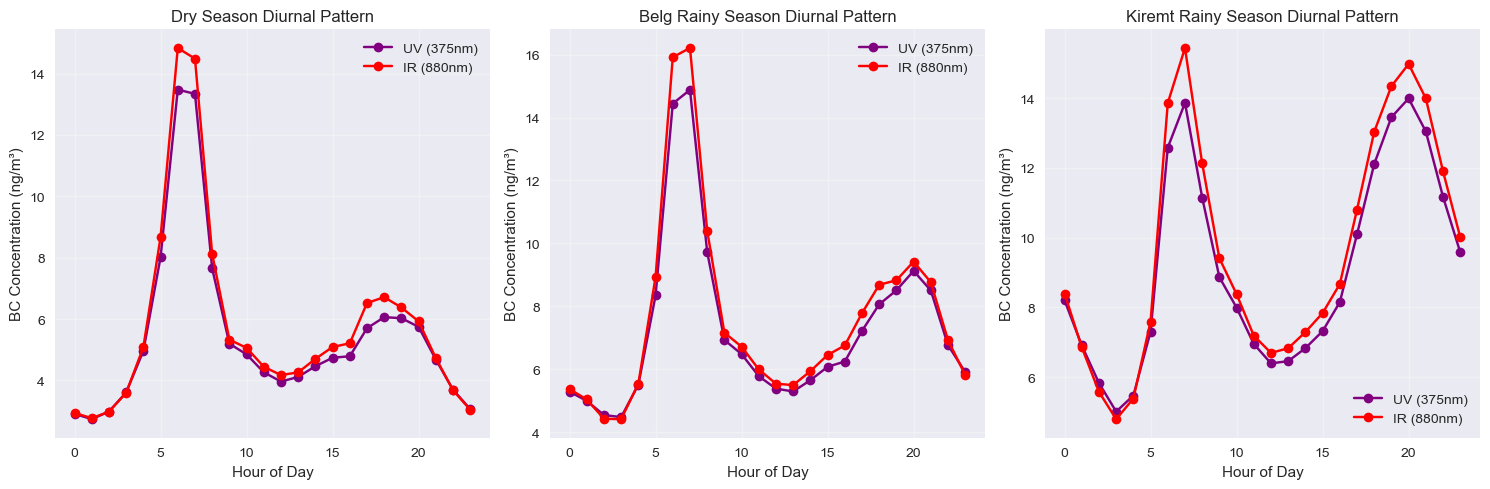

In [36]:
def analyze_aae_with_macs(df, mac_combinations):
    """
    Analyze AAE with different MAC value combinations
    
    Parameters:
    -----------
    df : pandas DataFrame
        DataFrame with 'UV BCc', 'IR BCc' columns and datetime index
    mac_combinations : list of tuples
        List of (uv_mac, ir_mac) combinations to test
    """
    plt.style.use('seaborn-v0_8')  # Updated to use the correct style name
    
    # Setup seasonal classification
    if not isinstance(df.index, pd.DatetimeIndex):
        df.index = pd.to_datetime(df.index)
    
    df_analysis = df.copy()
    df_analysis['Month'] = df_analysis.index.month
    df_analysis['Hour'] = df_analysis.index.hour
    df_analysis['Ethiopian_Season'] = df_analysis['Month'].map(lambda month: 
        'Dry Season' if month in [10, 11, 12, 1, 2] else
        'Belg Rainy Season' if month in [3, 4, 5] else
        'Kiremt Rainy Season'
    )
    
    wavelength_ratio = np.log(880/375)
    results = {}
    
    # Create figure for all MAC combinations
    n_combinations = len(mac_combinations)
    fig_rows = (n_combinations + 1) // 2
    fig, axes = plt.subplots(fig_rows, 2, figsize=(15, 5*fig_rows))
    fig.suptitle('AAE Distributions with Different MAC Values', fontsize=14, y=1.02)
    
    if fig_rows == 1:
        axes = axes.reshape(1, -1)
    
    for idx, (uv_mac, ir_mac) in enumerate(mac_combinations):
        row = idx // 2
        col = idx % 2
        
        # Calculate AAE
        df_analysis['UV_abs'] = df_analysis['UV BCc'] * uv_mac
        df_analysis['IR_abs'] = df_analysis['IR BCc'] * ir_mac
        
        valid_mask = (df_analysis['UV_abs'] > 0) & (df_analysis['IR_abs'] > 0)
        ratio = df_analysis.loc[valid_mask, 'IR_abs'] / df_analysis.loc[valid_mask, 'UV_abs']
        aae = pd.Series(np.log(ratio) / wavelength_ratio).clip(-1, 3)
        
        # Calculate seasonal statistics
        seasonal_stats = {}
        for season in ['Dry Season', 'Belg Rainy Season', 'Kiremt Rainy Season']:
            season_mask = df_analysis['Ethiopian_Season'] == season
            season_data = df_analysis[season_mask & valid_mask]
            season_ratio = season_data['IR_abs'] / season_data['UV_abs']
            season_aae = pd.Series(np.log(season_ratio) / wavelength_ratio).clip(-1, 3)
            
            total_valid = len(season_aae)
            seasonal_stats[season] = {
                'n': total_valid,
                'mean_aae': season_aae.mean(),
                'median_aae': season_aae.median(),
                'ff_pct': (season_aae < 0.9).sum() / total_valid * 100,
                'mixed_pct': ((season_aae >= 0.9) & (season_aae <= 1.5)).sum() / total_valid * 100,
                'bb_pct': (season_aae > 1.5).sum() / total_valid * 100
            }
        
        # Plot AAE distribution
        ax = axes[row, col]
        ax.hist(aae, bins=100, alpha=0.7, density=True)
        ax.axvline(x=0.9, color='r', linestyle='--', label='FF Threshold')
        ax.axvline(x=1.5, color='g', linestyle='--', label='BB Threshold')
        ax.set_title(f'UV MAC={uv_mac}, IR MAC={ir_mac}')
        ax.set_xlabel('AAE')
        ax.set_ylabel('Normalized Frequency')
        ax.grid(True, alpha=0.3)
        ax.legend()
        
        # Store results
        results[(uv_mac, ir_mac)] = {
            'aae': aae,
            'seasonal_stats': seasonal_stats
        }
        
        # Print statistics
        print(f"\nMAC Values - UV: {uv_mac}, IR: {ir_mac}")
        print(f"Overall Mean AAE: {aae.mean():.3f}")
        print(f"Overall Median AAE: {aae.median():.3f}")
        print("\nSource Attribution:")
        total = len(aae)
        print(f"Fossil Fuel: {(aae < 0.9).sum() / total * 100:.1f}%")
        print(f"Mixed: {((aae >= 0.9) & (aae <= 1.5)).sum() / total * 100:.1f}%")
        print(f"Biomass: {(aae > 1.5).sum() / total * 100:.1f}%")
        
        print("\nSeasonal Statistics:")
        for season, stats in seasonal_stats.items():
            print(f"\n{season}:")
            print(f"Mean AAE: {stats['mean_aae']:.3f}")
            print(f"Median AAE: {stats['median_aae']:.3f}")
            print(f"Source distribution:")
            print(f"  Fossil Fuel: {stats['ff_pct']:.1f}%")
            print(f"  Mixed: {stats['mixed_pct']:.1f}%")
            print(f"  Biomass: {stats['bb_pct']:.1f}%")
    
    plt.tight_layout()
    
    # Create seasonal diurnal patterns plot
    plt.figure(figsize=(15, 5))
    seasons = ['Dry Season', 'Belg Rainy Season', 'Kiremt Rainy Season']
    for idx, season in enumerate(seasons):
        plt.subplot(1, 3, idx+1)
        season_data = df_analysis[df_analysis['Ethiopian_Season'] == season]
        hourly_avg = season_data.groupby('Hour')[['UV BCc', 'IR BCc']].mean()
        
        plt.plot(hourly_avg.index, hourly_avg['UV BCc'], 
                label='UV (375nm)', marker='o', color='purple')
        plt.plot(hourly_avg.index, hourly_avg['IR BCc'], 
                label='IR (880nm)', marker='o', color='red')
        plt.title(f'{season} Diurnal Pattern')
        plt.xlabel('Hour of Day')
        plt.ylabel('BC Concentration (ng/m³)')
        plt.grid(True, alpha=0.3)
        plt.legend()
    
    plt.tight_layout()
    
    return results

# Test with several MAC combinations
mac_combinations = [
    (7.77, 7.77),   # Equal MACs
    (10.0, 7.77),   # Higher UV
    (12.5, 7.77),   # Standard
    (15.0, 7.77),   # Much higher UV
    (12.5, 8.5),    # Both adjusted
    (15.0, 9.0)     # Both high
]

# Run analysis
results = analyze_aae_with_macs(df, mac_combinations)
plt.show()


MAC Values - UV: 7.77, IR: 7.77

Seasonal Statistics:

Dry Season:
Number of measurements: 372,518
Mean AAE: 0.069
Median AAE: 0.023
Source distribution:
  Fossil Fuel: 93.1%
  Mixed: 4.2%
  Biomass: 2.7%

Belg Rainy Season:
Number of measurements: 294,965
Mean AAE: 0.049
Median AAE: 0.014
Source distribution:
  Fossil Fuel: 94.8%
  Mixed: 3.2%
  Biomass: 1.9%

Kiremt Rainy Season:
Number of measurements: 348,584
Mean AAE: 0.061
Median AAE: 0.029
Source distribution:
  Fossil Fuel: 95.4%
  Mixed: 3.0%
  Biomass: 1.6%

MAC Values - UV: 10.0, IR: 7.77

Seasonal Statistics:

Dry Season:
Number of measurements: 372,518
Mean AAE: -0.206
Median AAE: -0.272
Source distribution:
  Fossil Fuel: 95.8%
  Mixed: 2.3%
  Biomass: 1.9%

Belg Rainy Season:
Number of measurements: 294,965
Mean AAE: -0.231
Median AAE: -0.282
Source distribution:
  Fossil Fuel: 97.0%
  Mixed: 1.7%
  Biomass: 1.3%

Kiremt Rainy Season:
Number of measurements: 348,584
Mean AAE: -0.222
Median AAE: -0.266
Source distributio

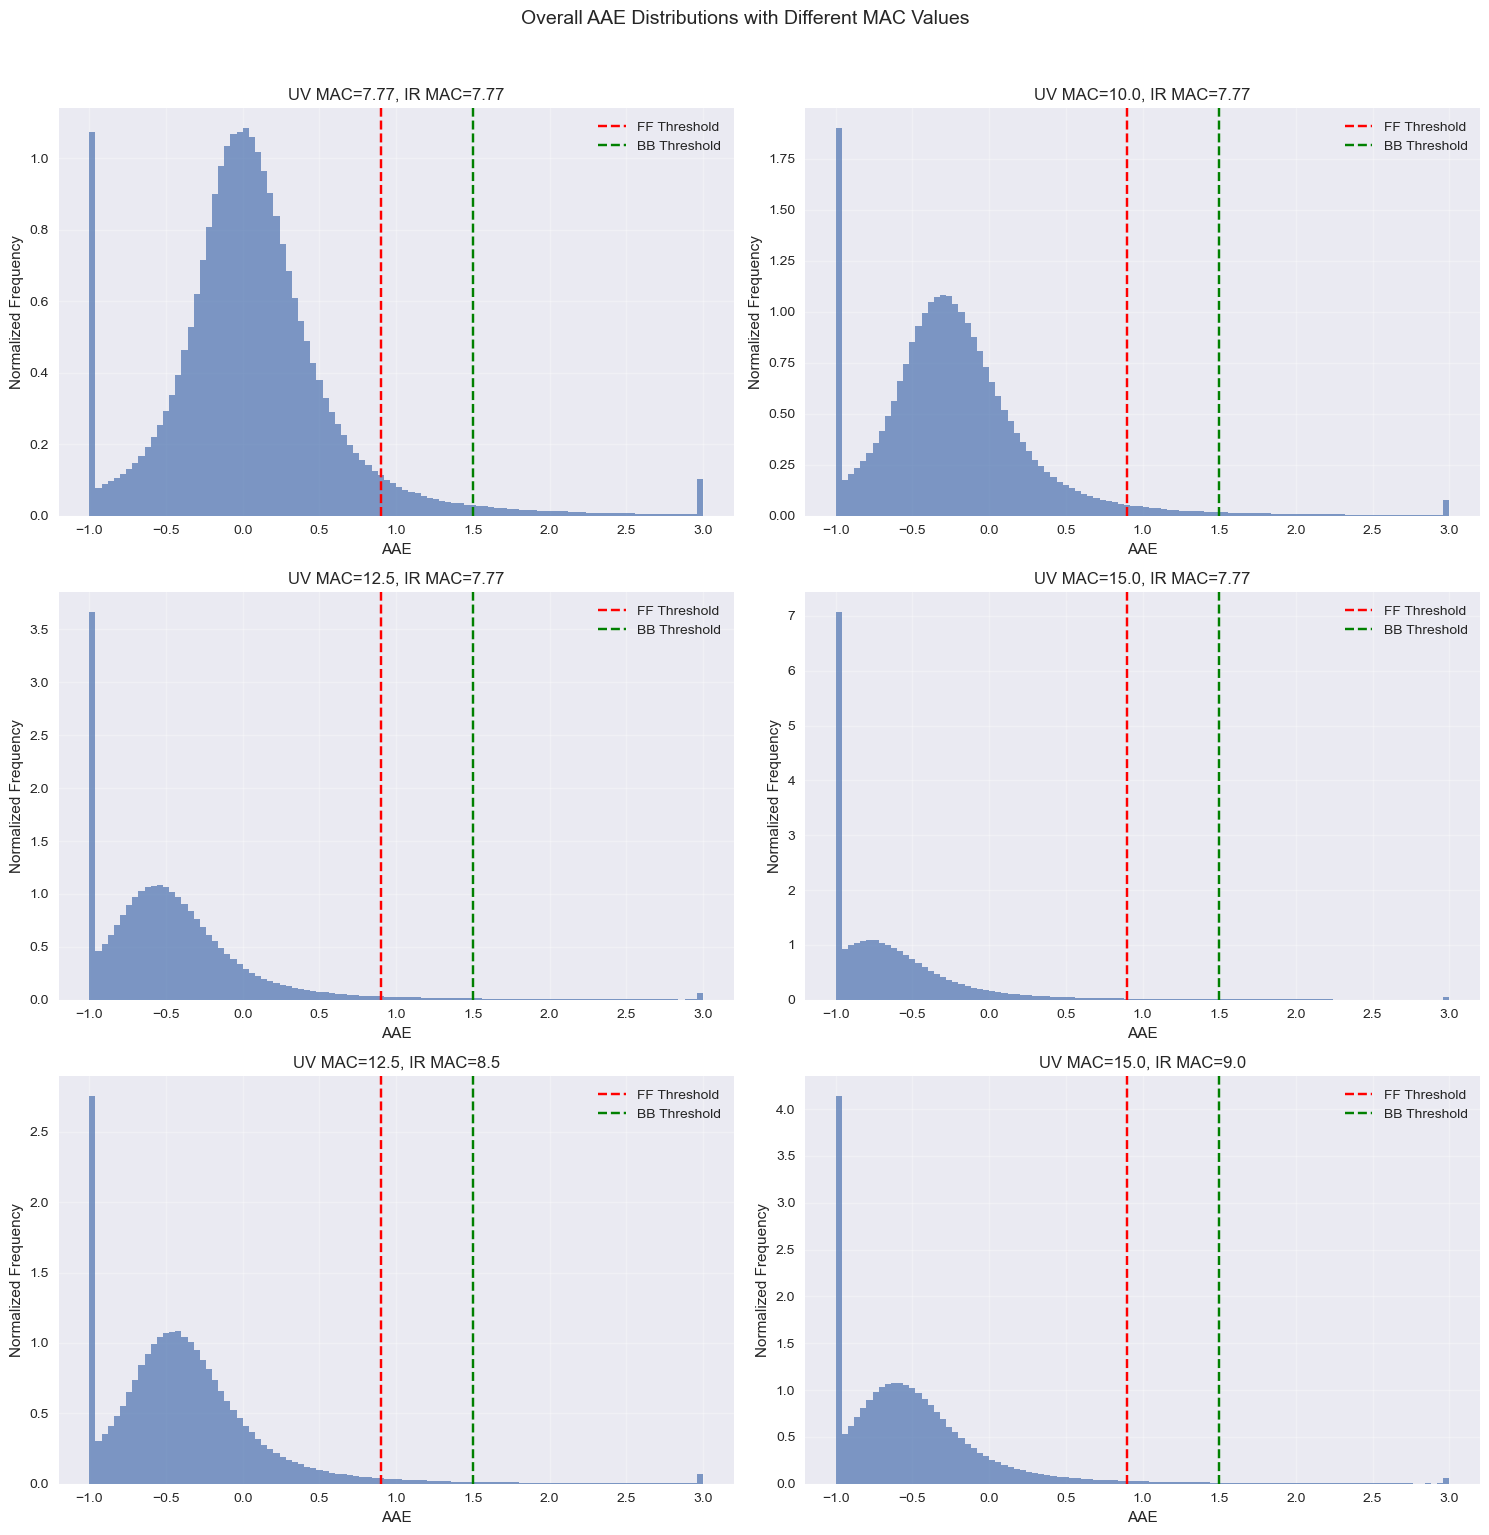

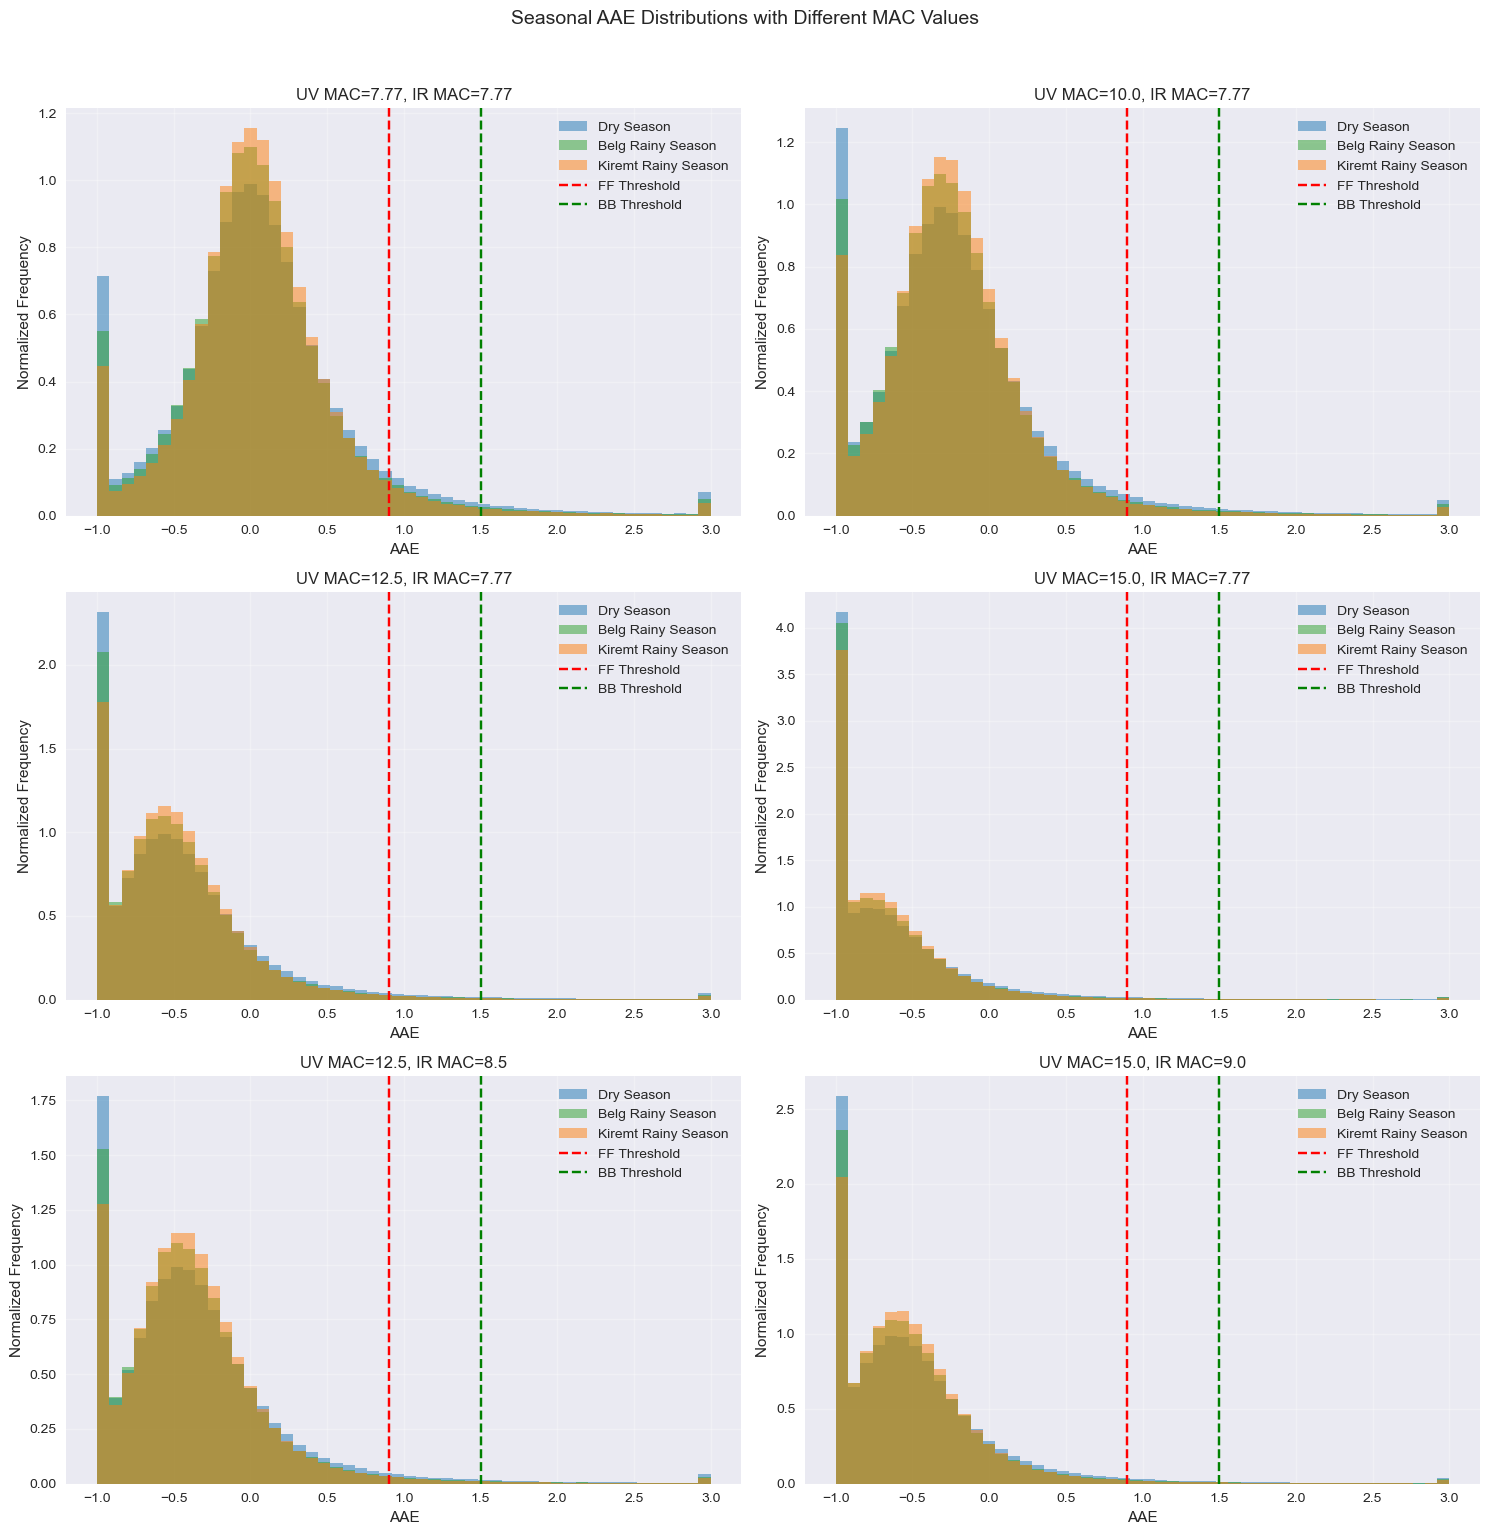

In [ ]:
def analyze_seasonal_aae_with_macs(df, mac_combinations):
    """
    Analyze AAE by season with different MAC value combinations
    """
    plt.style.use('seaborn-v0_8')  # Updated to use the correct style name
    
    # Setup seasonal classification
    if not isinstance(df.index, pd.DatetimeIndex):
        df.index = pd.to_datetime(df.index)
    
    df_analysis = df.copy()
    df_analysis['Month'] = df_analysis.index.month
    df_analysis['Hour'] = df_analysis.index.hour
    df_analysis['Ethiopian_Season'] = df_analysis['Month'].map(lambda month: 
        'Dry Season' if month in [10, 11, 12, 1, 2] else
        'Belg Rainy Season' if month in [3, 4, 5] else
        'Kiremt Rainy Season'
    )
    
    wavelength_ratio = np.log(880/375)
    seasons = ['Dry Season', 'Belg Rainy Season', 'Kiremt Rainy Season']
    colors = ['#1f77b4', '#2ca02c', '#ff7f0e']  # Different color for each season
    
    # Create figures - one for overall and one for seasonal comparisons
    n_combinations = len(mac_combinations)
    fig_rows = (n_combinations + 1) // 2
    
    # Figure 1: Overall AAE distributions
    fig1, axes1 = plt.subplots(fig_rows, 2, figsize=(15, 5*fig_rows))
    fig1.suptitle('Overall AAE Distributions with Different MAC Values', fontsize=14, y=1.02)
    
    # Figure 2: Seasonal AAE distributions
    fig2, axes2 = plt.subplots(fig_rows, 2, figsize=(15, 5*fig_rows))
    fig2.suptitle('Seasonal AAE Distributions with Different MAC Values', fontsize=14, y=1.02)
    
    if fig_rows == 1:
        axes1 = axes1.reshape(1, -1)
        axes2 = axes2.reshape(1, -1)
    
    results = {}
    
    for idx, (uv_mac, ir_mac) in enumerate(mac_combinations):
        row = idx // 2
        col = idx % 2
        
        # Calculate absorption
        df_analysis['UV_abs'] = df_analysis['UV BCc'] * uv_mac
        df_analysis['IR_abs'] = df_analysis['IR BCc'] * ir_mac
        
        # Overall AAE calculation
        valid_mask = (df_analysis['UV_abs'] > 0) & (df_analysis['IR_abs'] > 0)
        ratio = df_analysis.loc[valid_mask, 'IR_abs'] / df_analysis.loc[valid_mask, 'UV_abs']
        aae = pd.Series(np.log(ratio) / wavelength_ratio).clip(-1, 3)
        
        # Plot overall distribution
        ax1 = axes1[row, col]
        ax1.hist(aae, bins=100, alpha=0.7, density=True)
        ax1.axvline(x=0.9, color='r', linestyle='--', label='FF Threshold')
        ax1.axvline(x=1.5, color='g', linestyle='--', label='BB Threshold')
        ax1.set_title(f'UV MAC={uv_mac}, IR MAC={ir_mac}')
        ax1.set_xlabel('AAE')
        ax1.set_ylabel('Normalized Frequency')
        ax1.grid(True, alpha=0.3)
        ax1.legend()
        
        # Plot seasonal distributions
        ax2 = axes2[row, col]
        for season, color in zip(seasons, colors):
            season_mask = df_analysis['Ethiopian_Season'] == season
            season_data = df_analysis[season_mask & valid_mask]
            season_ratio = season_data['IR_abs'] / season_data['UV_abs']
            season_aae = pd.Series(np.log(season_ratio) / wavelength_ratio).clip(-1, 3)
            
            ax2.hist(season_aae, bins=50, alpha=0.5, density=True, 
                    label=season, color=color)
            
            # Calculate and store statistics
            total_valid = len(season_aae)
            if (uv_mac, ir_mac) not in results:
                results[(uv_mac, ir_mac)] = {}
            
            results[(uv_mac, ir_mac)][season] = {
                'n': total_valid,
                'mean_aae': season_aae.mean(),
                'median_aae': season_aae.median(),
                'ff_pct': (season_aae < 0.9).sum() / total_valid * 100,
                'mixed_pct': ((season_aae >= 0.9) & (season_aae <= 1.5)).sum() / total_valid * 100,
                'bb_pct': (season_aae > 1.5).sum() / total_valid * 100
            }
        
        # Add details to seasonal plot
        ax2.axvline(x=0.9, color='r', linestyle='--', label='FF Threshold')
        ax2.axvline(x=1.5, color='g', linestyle='--', label='BB Threshold')
        ax2.set_title(f'UV MAC={uv_mac}, IR MAC={ir_mac}')
        ax2.set_xlabel('AAE')
        ax2.set_ylabel('Normalized Frequency')
        ax2.grid(True, alpha=0.3)
        ax2.legend()
        
        # Print statistics
        print(f"\nMAC Values - UV: {uv_mac}, IR: {ir_mac}")
        print("\nSeasonal Statistics:")
        for season in seasons:
            stats = results[(uv_mac, ir_mac)][season]
            print(f"\n{season}:")
            print(f"Number of measurements: {stats['n']:,}")
            print(f"Mean AAE: {stats['mean_aae']:.3f}")
            print(f"Median AAE: {stats['median_aae']:.3f}")
            print(f"Source distribution:")
            print(f"  Fossil Fuel: {stats['ff_pct']:.1f}%")
            print(f"  Mixed: {stats['mixed_pct']:.1f}%")
            print(f"  Biomass: {stats['bb_pct']:.1f}%")
    
    fig1.tight_layout()
    fig2.tight_layout()
    
    return results

# Test with same MAC combinations
mac_combinations = [
    (7.77, 7.77),   # Equal MACs
    (10.0, 7.77),   # Higher UV
    (12.5, 7.77),   # Standard
    (15.0, 7.77),   # Much higher UV
    (12.5, 8.5),    # Both adjusted
    (15.0, 9.0)     # Both high
]

# Run analysis
results = analyze_seasonal_aae_with_macs(df, mac_combinations)
plt.show()

### 1.2 AAE Time Series Plot

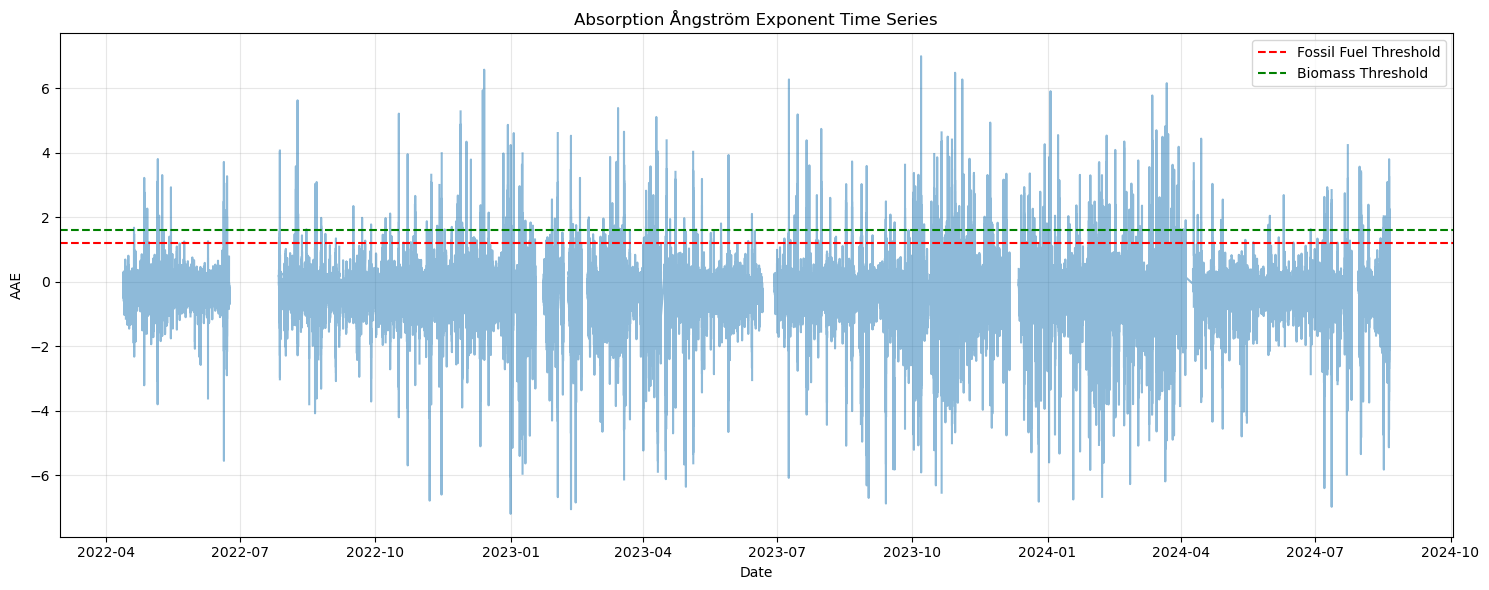

In [10]:
plt.figure(figsize=(15, 6))
plt.plot(df.index, aae, alpha=0.5)
plt.axhline(y=1.2, color='r', linestyle='--', label='Fossil Fuel Threshold')
plt.axhline(y=1.6, color='g', linestyle='--', label='Biomass Threshold')
plt.title('Absorption Ångström Exponent Time Series')
plt.xlabel('Date')
plt.ylabel('AAE')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(dirs['plots'], 'aae_time_series.png'))
plt.show()

### 1.3 Source Contribution Pie Chart

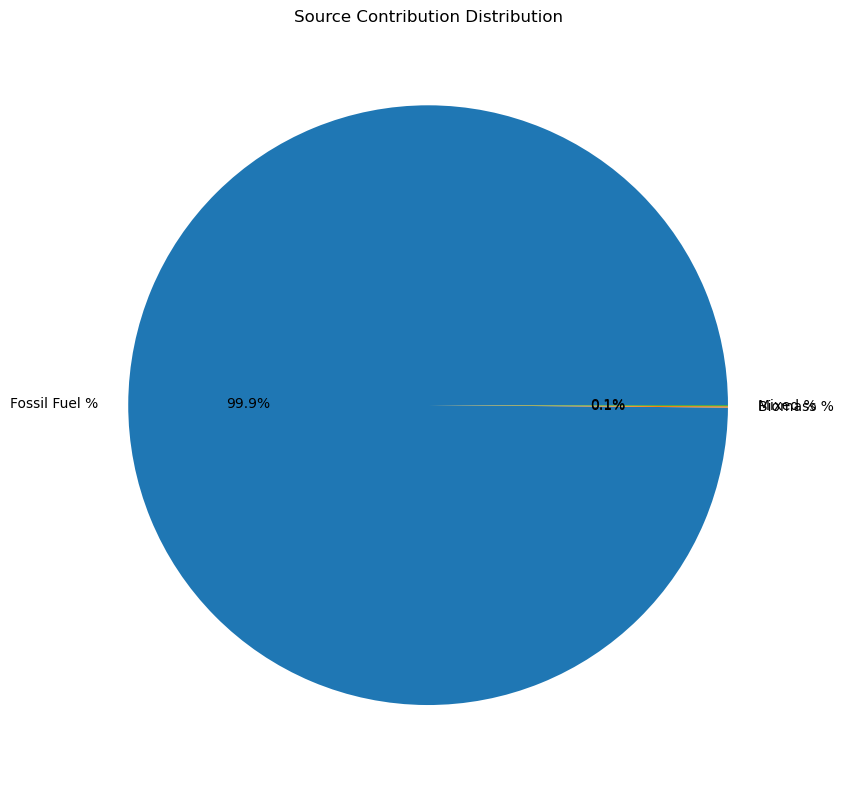

In [11]:
plt.figure(figsize=(10, 8))
plt.pie(source_contribution.values(), labels=source_contribution.keys(), autopct='%1.1f%%')
plt.title('Source Contribution Distribution')
plt.tight_layout()
plt.savefig(os.path.join(dirs['plots'], 'source_contribution_pie.png'))
plt.show()

## 2. Daily Pattern Analysis

### 2.1 IR vs UV Daily Pattern

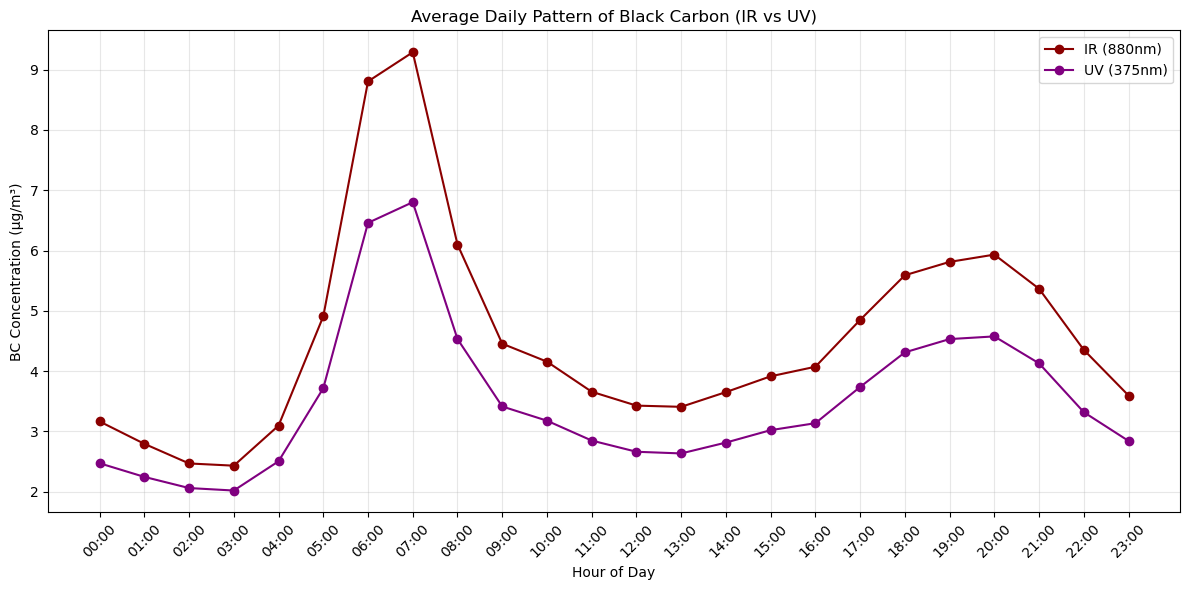

In [12]:
hourly_avg = df.groupby('Hour')[['IR BC1', 'UV BC1']].mean()

plt.figure(figsize=(12, 6))
plt.plot(hourly_avg.index, hourly_avg['IR BC1'], 
        label='IR (880nm)', marker='o', color='darkred')
plt.plot(hourly_avg.index, hourly_avg['UV BC1'], 
        label='UV (375nm)', marker='o', color='purple')
plt.title('Average Daily Pattern of Black Carbon (IR vs UV)')
plt.xlabel('Hour of Day')
plt.ylabel('BC Concentration (µg/m³)')
plt.xticks(range(24), [f'{h:02d}:00' for h in range(24)], rotation=45)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(dirs['plots'], 'bc_daily_pattern_ir_uv.png'))
plt.show()

### 2.2 All Wavelengths Daily Pattern

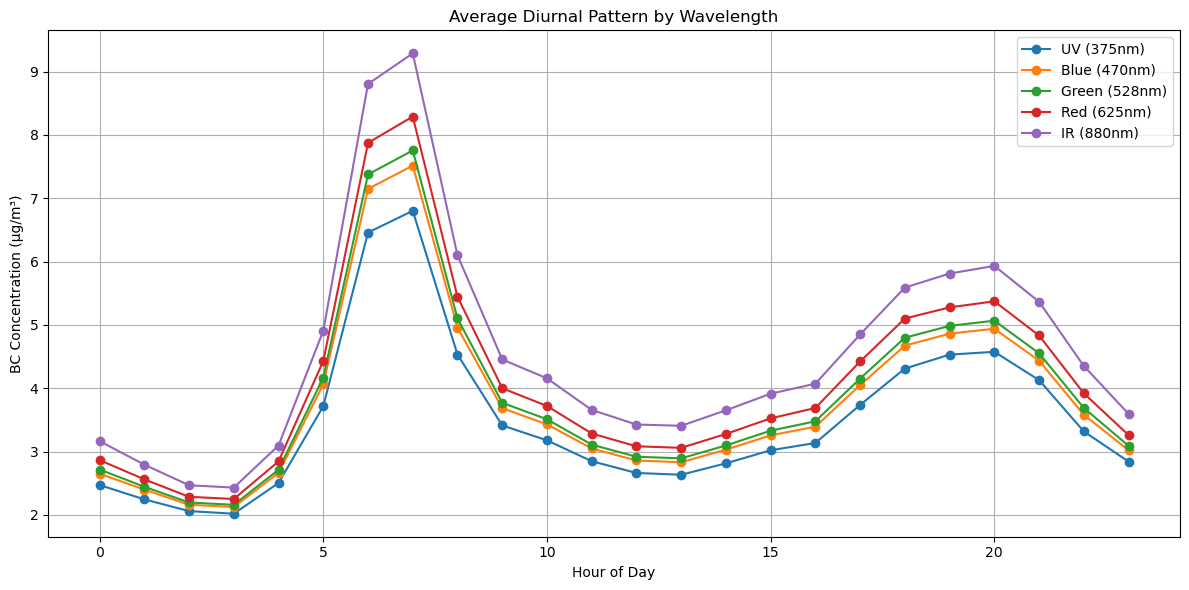

In [13]:
hourly_avg_all = df.groupby('Hour')[bc_columns].mean()
plt.figure(figsize=(12, 6))
for col in bc_columns:
    wave = col.split()[0]
    plt.plot(hourly_avg_all.index, hourly_avg_all[col], 
            label=f'{wave} ({wavelengths[wave]}nm)', marker='o')
plt.title('Average Diurnal Pattern by Wavelength')
plt.xlabel('Hour of Day')
plt.ylabel('BC Concentration (µg/m³)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(dirs['plots'], 'bc_diurnal_all_wavelengths.png'))
plt.show()

## 3. Time Series Analysis

### 3.1 Monthly Averages by Wavelength

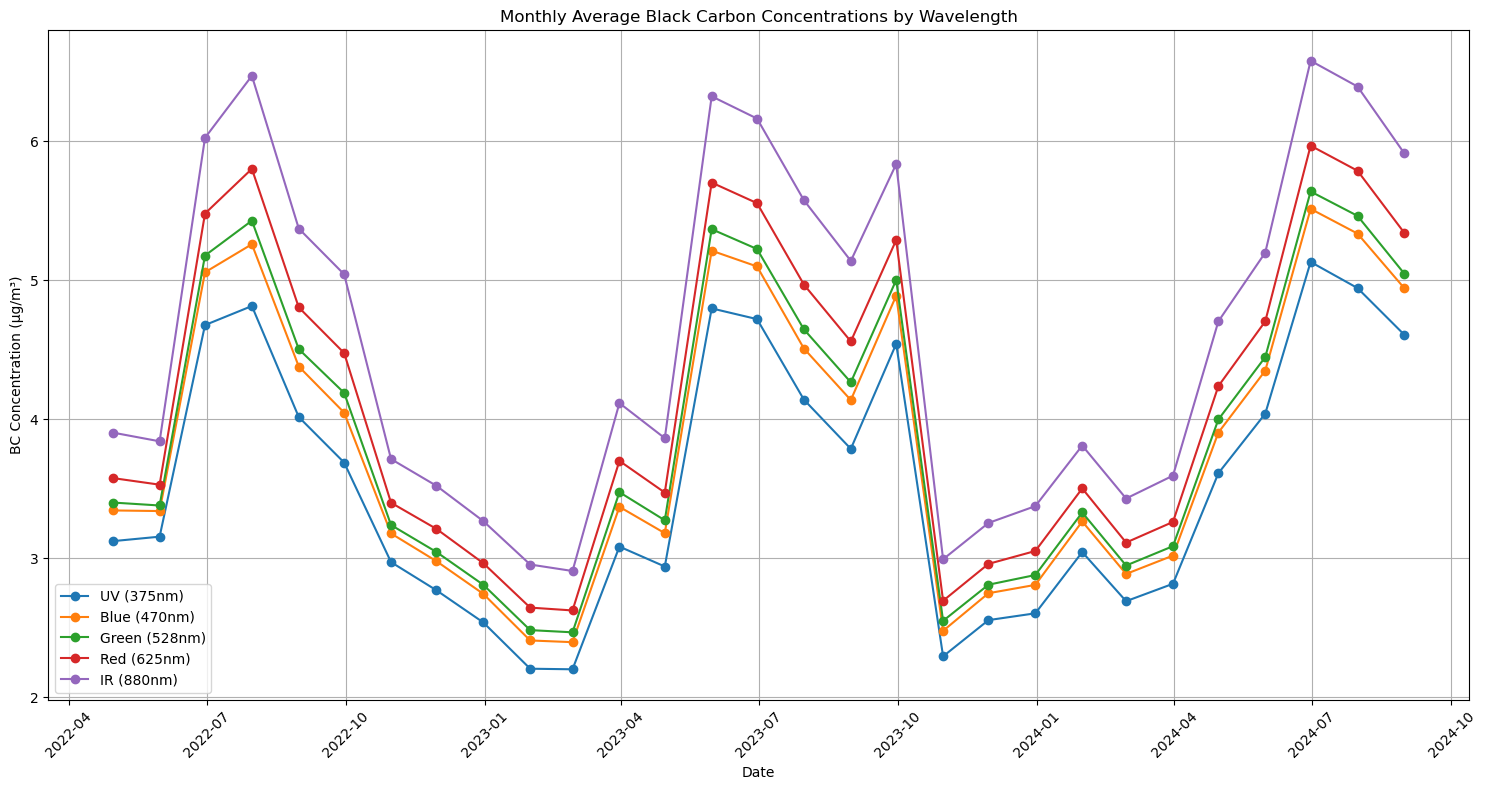

In [14]:
monthly_avg = df[bc_columns].resample('ME').mean()
plt.figure(figsize=(15, 8))
for col in bc_columns:
    wave = col.split()[0]
    plt.plot(monthly_avg.index, monthly_avg[col], 
            label=f'{wave} ({wavelengths[wave]}nm)', marker='o')
plt.title('Monthly Average Black Carbon Concentrations by Wavelength')
plt.xlabel('Date')
plt.ylabel('BC Concentration (µg/m³)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(os.path.join(dirs['plots'], 'bc_monthly_wavelengths.png'))
plt.show()

### 3.2 Rolling Statistics Plot

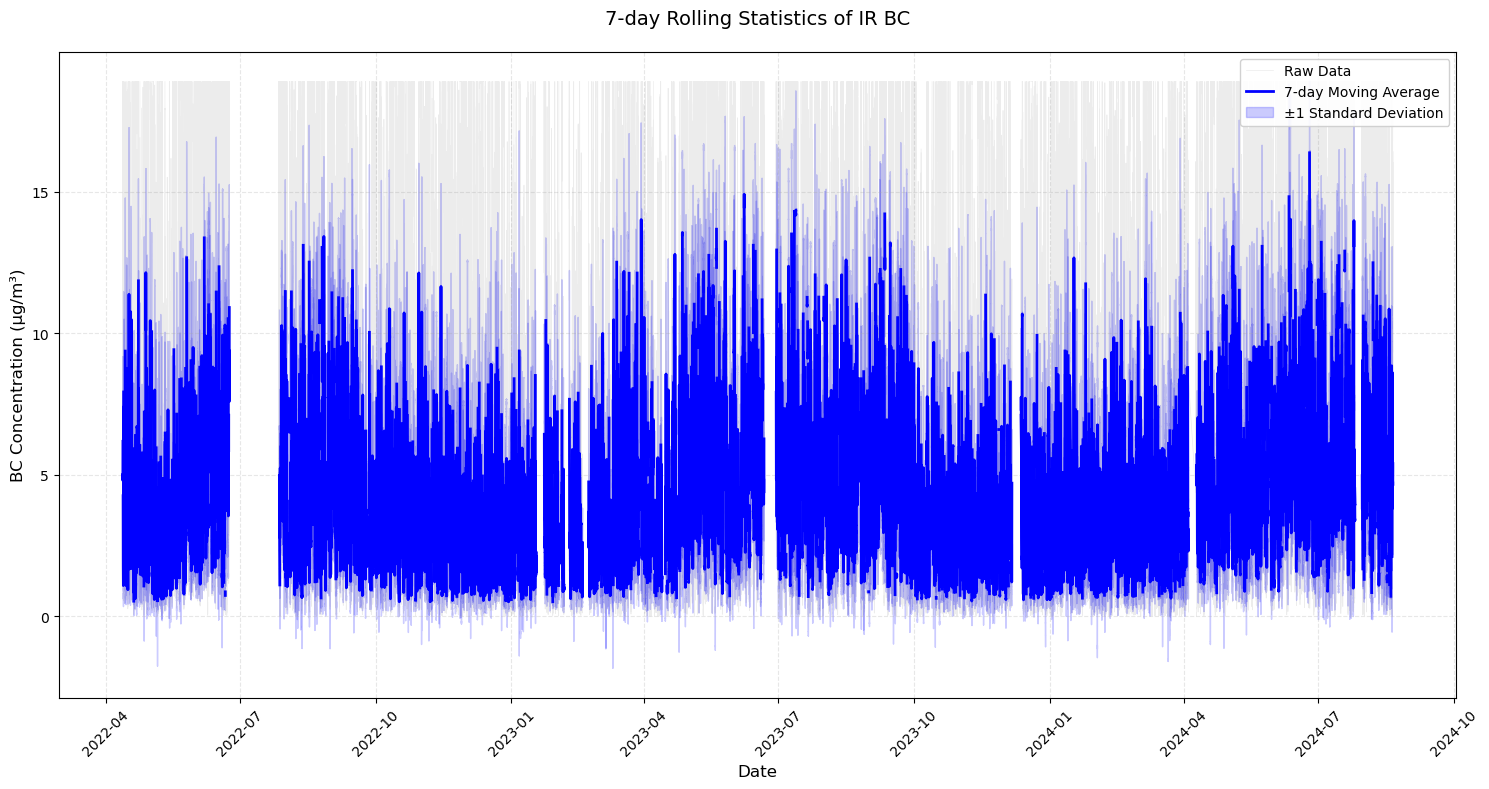

In [15]:
# Create a copy of the data for processing
plot_data = df['IR BC1'].copy()
upper_limit = plot_data.quantile(0.99)
plot_data = plot_data.clip(upper=upper_limit)

# Calculate rolling statistics
rolling_mean = plot_data.rolling(window=24*7).mean()  # 7-day rolling average
rolling_std = plot_data.rolling(window=24*7).std()

plt.figure(figsize=(15, 8))
plt.plot(df.index, plot_data, alpha=0.15, label='Raw Data', color='gray', linewidth=0.5)
plt.plot(rolling_mean.index, rolling_mean, 
        label='7-day Moving Average', 
        color='blue', 
        linewidth=2)
plt.fill_between(rolling_mean.index, 
                rolling_mean - rolling_std,
                rolling_mean + rolling_std,
                alpha=0.2, color='blue',
                label='±1 Standard Deviation')

plt.title('7-day Rolling Statistics of IR BC', pad=20, fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('BC Concentration (µg/m³)', fontsize=12)
plt.legend(loc='upper right', framealpha=0.9, fontsize=10)
plt.grid(True, alpha=0.3, linestyle='--')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(os.path.join(dirs['plots'], 'bc_rolling_statistics.png'))
plt.show()

## 4. Correlation Analysis

### 4.1 Wavelength Correlation Matrix

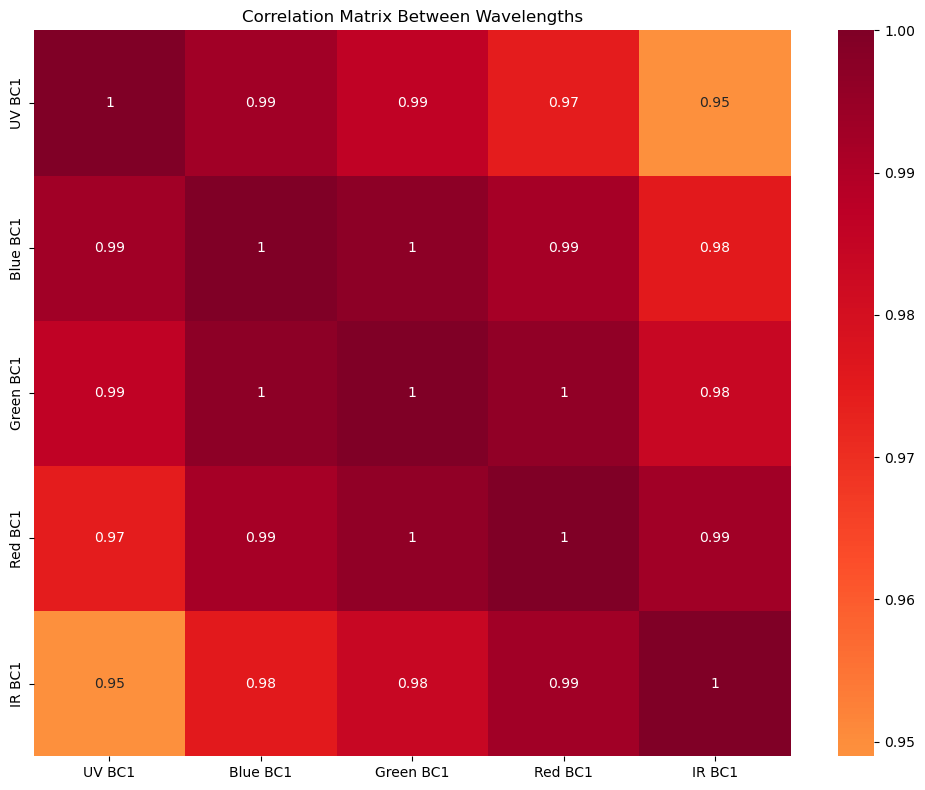

In [16]:
plt.figure(figsize=(10, 8))
correlation_matrix = df[bc_columns].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='YlOrRd', center=0.95)
plt.title('Correlation Matrix Between Wavelengths')
plt.tight_layout()
plt.savefig(os.path.join(dirs['plots'], 'bc_wavelength_correlations.png'))
plt.show()

### 4.2 IR vs UV Scatter Plot

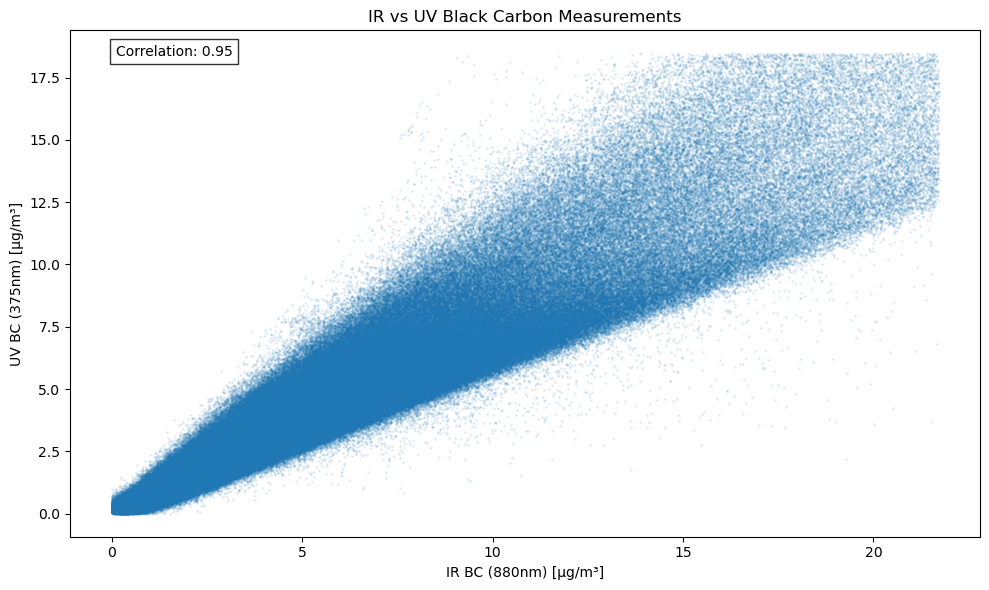

In [17]:
plt.figure(figsize=(10, 6))
valid_data = df[['IR BC1', 'UV BC1']].dropna()
plt.scatter(valid_data['IR BC1'], valid_data['UV BC1'], alpha=0.1, s=1)
corr = valid_data['IR BC1'].corr(valid_data['UV BC1'])
plt.text(0.05, 0.95, f'Correlation: {corr:.2f}', 
         transform=plt.gca().transAxes, 
         bbox=dict(facecolor='white', alpha=0.8))
plt.xlabel('IR BC (880nm) [µg/m³]')
plt.ylabel('UV BC (375nm) [µg/m³]')
plt.title('IR vs UV Black Carbon Measurements')
plt.tight_layout()
plt.savefig(os.path.join(dirs['plots'], 'bc_correlation.png'))
plt.show()

## 5. Seasonal Analysis

### 5.1 Seasonal Distribution Plots

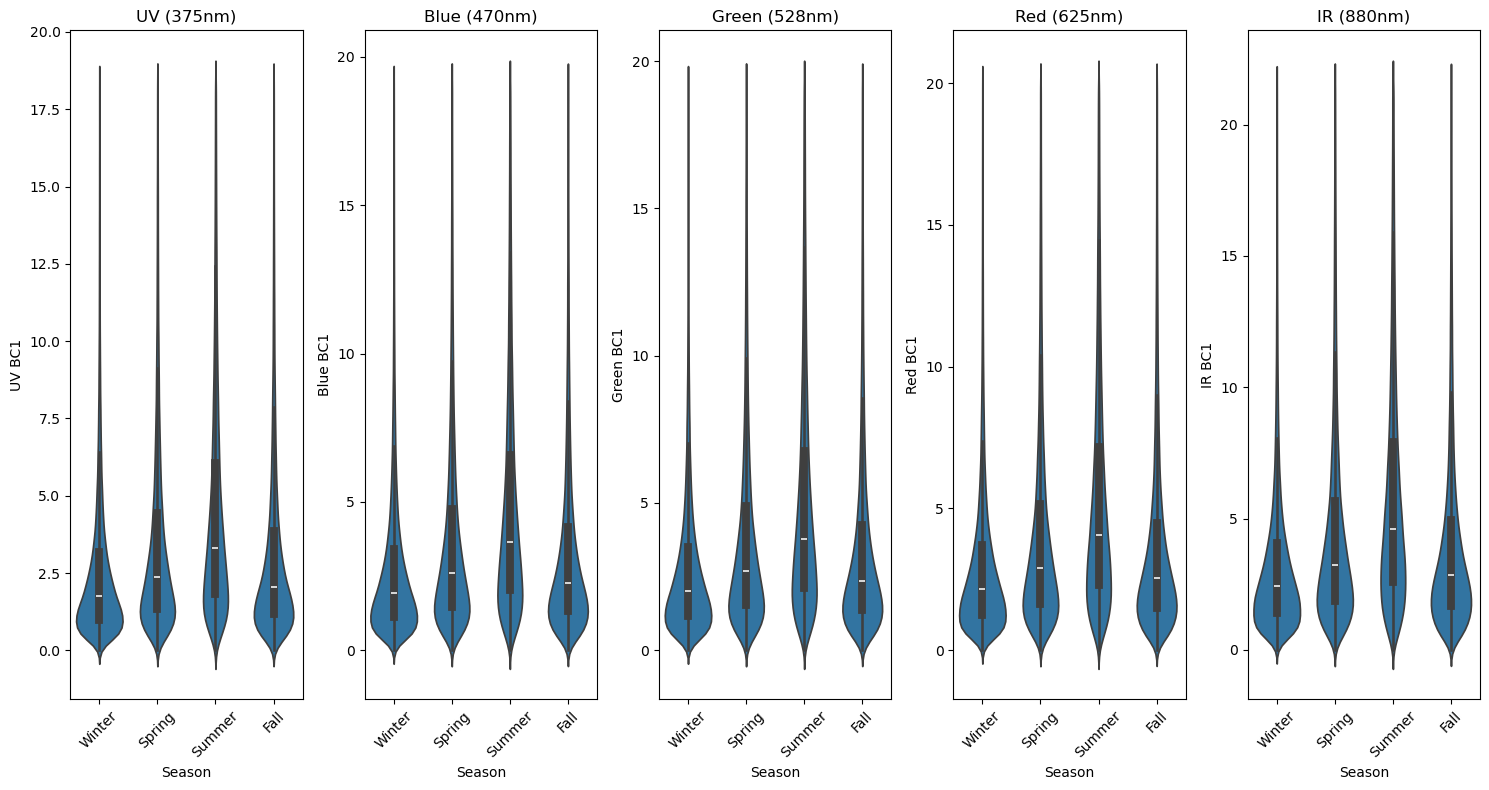

In [18]:
plt.figure(figsize=(15, 8))
seasons_order = ['Winter', 'Spring', 'Summer', 'Fall']
for i, col in enumerate(bc_columns, 1):
    plt.subplot(1, 5, i)
    sns.violinplot(data=df, x='Season', y=col, order=seasons_order)
    wave = col.split()[0]
    plt.title(f'{wave} ({wavelengths[wave]}nm)')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(os.path.join(dirs['plots'], 'bc_seasonal_distribution.png'))
plt.show()

### 5.2 Seasonal Daily Patterns (Polar Plots)

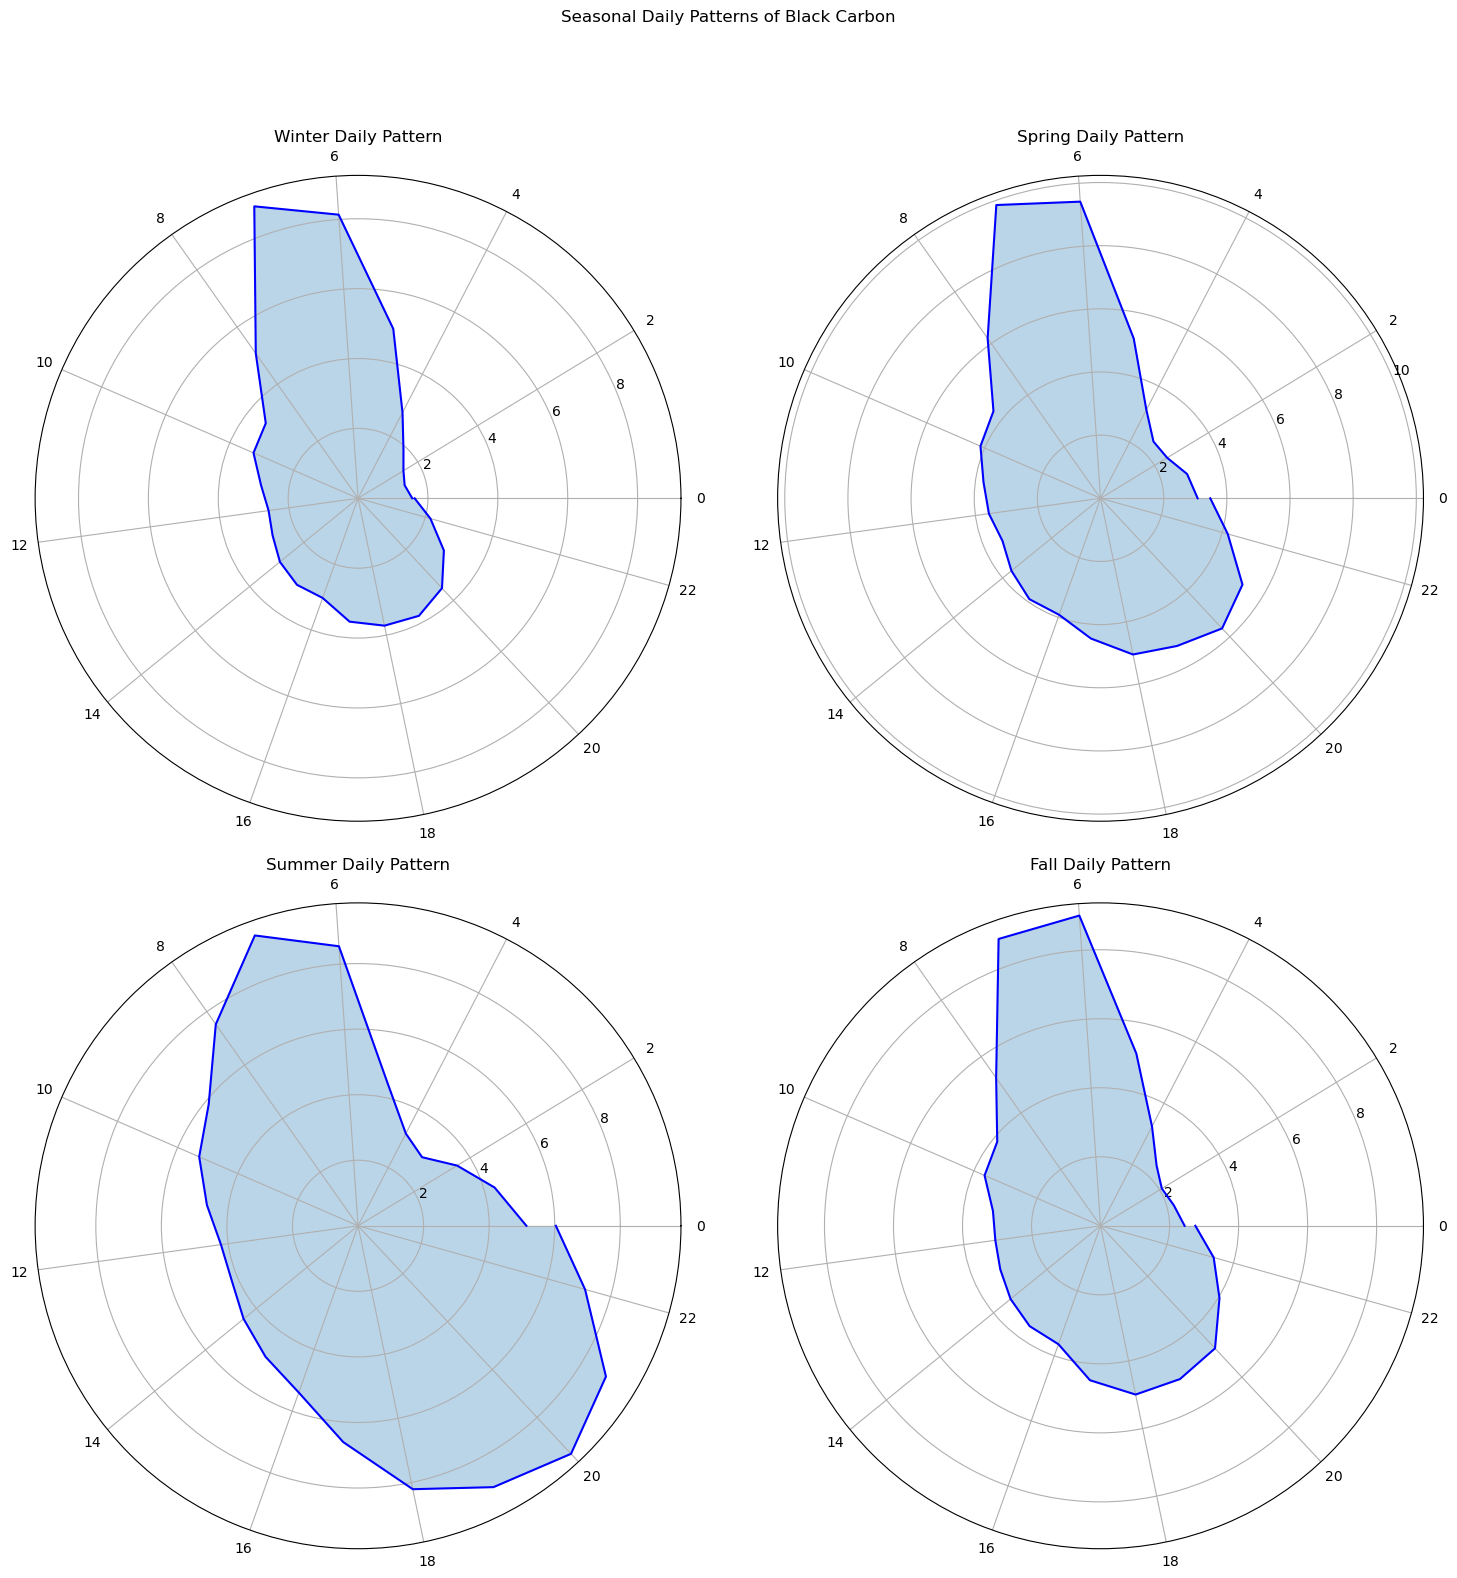

In [19]:
fig, axes = plt.subplots(2, 2, figsize=(15, 15), subplot_kw=dict(projection='polar'))
axes = axes.flatten()

for i, season in enumerate(seasons_order):
    season_data = df[df['Season'] == season]
    hours = np.linspace(0, 2*np.pi, 24)
    avg_conc = season_data.groupby('Hour')['IR BC1'].mean()
    
    axes[i].plot(hours, avg_conc.values, color='blue')
    axes[i].fill(hours, avg_conc.values, alpha=0.3)
    axes[i].set_title(f'{season} Daily Pattern')
    axes[i].set_xticks(hours[::2])
    axes[i].set_xticklabels([str(h) for h in range(0, 24, 2)])

plt.suptitle('Seasonal Daily Patterns of Black Carbon', y=1.05)
plt.tight_layout()
plt.savefig(os.path.join(dirs['plots'], 'bc_seasonal_polar.png'))
plt.show()

# 6. Summary Statistics Analysis

## 6.1 Basic Dataset Summary

In [20]:
# Calculate and display basic summary statistics
summary = {
    'Total Measurements': len(df),
    'Date Range': f"{df.index.min().strftime('%Y-%m-%d')} to {df.index.max().strftime('%Y-%m-%d')}",
    'Average Concentrations (µg/m³)': {col: round(df[col].mean(), 3) for col in bc_columns},
    'Data Completeness (%)': round(100 * df[bc_columns].count().mean() / len(df), 2)
}

# Display summary
for key, value in summary.items():
    print(f"\n{key}:")
    if isinstance(value, dict):
        for k, v in value.items():
            print(f"  {k}: {v}")
    else:
        print(f"  {value}")


Total Measurements:
  1095086

Date Range:
  2022-04-12 to 2024-08-20

Average Concentrations (µg/m³):
  UV BC1: 3.469
  Blue BC1: 3.747
  Green BC1: 3.841
  Red BC1: 4.069
  IR BC1: 4.503

Data Completeness (%):
  97.8


## 6.2 Detailed Statistics by Timeframe

In [21]:
# Calculate comprehensive statistics
stats = {
    'Daily Statistics': df[bc_columns].resample('D').agg(['mean', 'std', 'min', 'max']),
    'Seasonal Statistics': df.groupby('Season')[bc_columns].agg(['mean', 'std', 'min', 'max']),
    'Weekday vs Weekend': {
        'Weekday': df[df['DayOfWeek'] < 5][bc_columns].mean(),
        'Weekend': df[df['DayOfWeek'] >= 5][bc_columns].mean()
    },
    'Peak Hours': df.groupby('Hour')[bc_columns].mean().idxmax(),
}

# Display daily statistics summary
print("Daily Statistics Summary:")
display(stats['Daily Statistics'].describe())

# Display seasonal statistics
print("\nSeasonal Statistics:")
display(stats['Seasonal Statistics'])

Daily Statistics Summary:


UV BC1                                        Blue BC1              \
             mean         std         min         max        mean         std   
count  795.000000  795.000000  795.000000  795.000000  795.000000  795.000000   
mean     3.556914    2.805969    0.318678   16.517654    3.836182    2.961002   
std      1.577315    0.939557    0.668611    3.240072    1.655370    0.965575   
min      0.487262    0.298052    0.000000    1.607000    0.559074    0.334054   
25%      2.512308    2.185549    0.043500   16.434000    2.710296    2.347684   
50%      3.257791    2.803233    0.172000   18.045000    3.523260    2.963237   
75%      4.359153    3.426799    0.385000   18.370500    4.709445    3.638283   
max     15.686736    5.962741   13.095000   18.471000   15.592222    6.507549   

                                Green BC1                                      \
              min         max        mean         std         min         max   
count  795.000000  795.000000  795.000000  795.000000  795.000000  795.000000   
mean     0.363165   17.344001    3.930077    2.997851    0.332795   17.500501   
std      0.683049    3.161211    1.681580    0.966451    0.679987    3.104330   
min      0.000000    1.989000    0.616708    0.378755    0.000000    2.013000   
25%      0.076000   17.120500    2.771228    2.394636    0.042000   17.259500   
50%      0.230000   18.842000    3.611790    2.999536    0.174000   18.965000   
75%      0.442500   19.150500    4.837808    3.668129    0.422000   19.285000   
max     13.430000   19.244000   15.504478    6.523163   13.509000   19.374000   

          Red BC1                                          IR BC1              \
             mean         std         min         max        mean         std   
count  795.000000  795.000000  795.000000  795.000000  795.000000  795.000000   
mean     4.159093    3.131487    0.387814   18.263136    4.595270    3.405131   
std      1.751122    0.998050    0.698937    3.126002    1.887320    1.065005   
min      0.649243    0.406991    0.000000    2.372000    0.755403    0.485106   
25%      2.946325    2.504049    0.069500   17.910500    3.264679    2.710276   
50%      3.809698    3.145950    0.230000   19.714000    4.178671    3.402373   
75%      5.116681    3.826028    0.478500   20.012500    5.666175    4.139221   
max     15.415253    6.635155   13.427000   20.121000   15.401265    6.789117   

                               
              min         max  
count  795.000000  795.000000  
mean     0.406699   19.800819  
std      0.708699    3.250379  
min      0.000000    2.529000  
25%      0.063000   19.618000  
50%      0.231000   21.312000  
75%      0.502000   21.605500  
max     13.112000   21.712000


Seasonal Statistics:


UV BC1                         Blue BC1                         \
            mean       std  min     max      mean       std  min     max   
Season                                                                     
Fall    3.102726  3.032439  0.0  18.469  3.348243  3.185402  0.0  19.243   
Spring  3.463975  3.193664  0.0  18.471  3.734241  3.370377  0.0  19.243   
Summer  4.491670  3.685723  0.0  18.471  4.862696  3.881264  0.0  19.244   
Winter  2.579013  2.540601  0.0  18.467  2.783819  2.673053  0.0  19.242   

       Green BC1                          Red BC1                         \
            mean       std  min     max      mean       std  min     max   
Season                                                                     
Fall    3.432471  3.222302  0.0  19.374  3.627631  3.353174  0.0  20.121   
Spring  3.824227  3.414423  0.0  19.374  4.045155  3.568399  0.0  20.120   
Summer  4.988912  3.925314  0.0  19.374  5.302663  4.109974  0.0  20.121   
Winter  2.851022  2.702580  0.0  19.369  3.015401  2.815136  0.0  20.120   

          IR BC1                         
            mean       std  min     max  
Season                                   
Fall    4.009280  3.635551  0.0  21.711  
Spring  4.467894  3.873161  0.0  21.711  
Summer  5.892007  4.473491  0.0  21.712  
Winter  3.323718  3.044296  0.0  21.710

## 6.3 Data Completeness Analysis

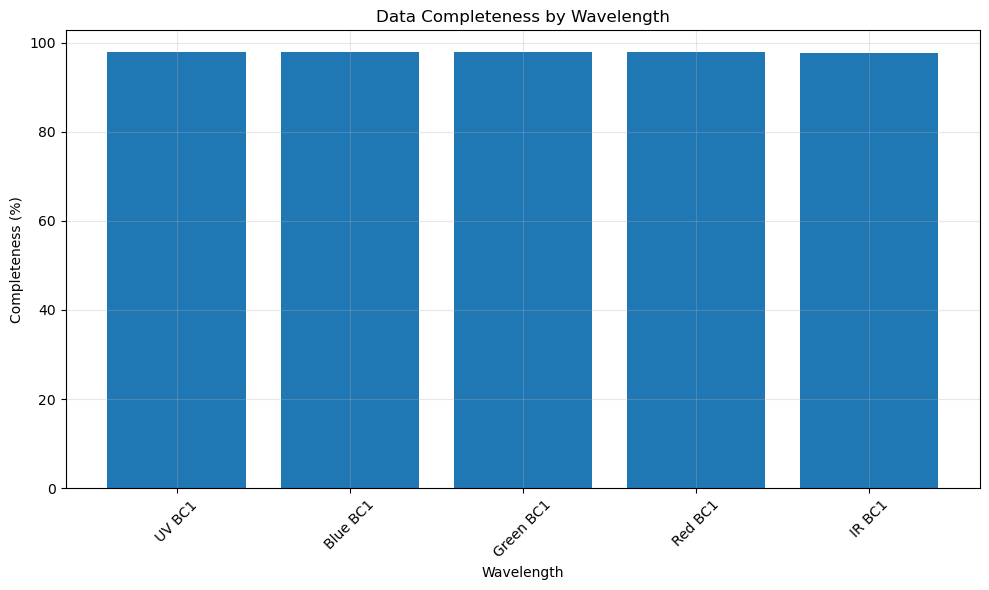


Data Completeness Summary:
UV BC1: 97.83%
Blue BC1: 97.84%
Green BC1: 97.78%
Red BC1: 97.80%
IR BC1: 97.75%


In [22]:
# Calculate and visualize data completeness
completeness = {col: (df[col].count() / len(df)) * 100 for col in bc_columns}

plt.figure(figsize=(10, 6))
plt.bar(completeness.keys(), completeness.values())
plt.title('Data Completeness by Wavelength')
plt.xlabel('Wavelength')
plt.ylabel('Completeness (%)')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\nData Completeness Summary:")
for col, comp in completeness.items():
    print(f"{col}: {comp:.2f}%")

## 6.4 Weekday vs Weekend Analysis

<Figure size 1200x600 with 0 Axes>

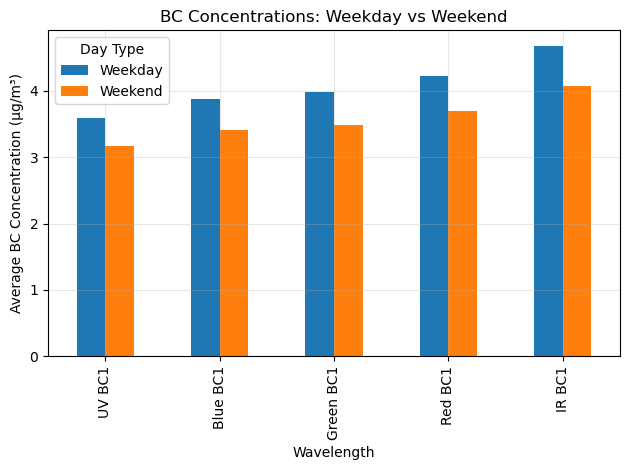


Weekday vs Weekend Average Concentrations:


Weekday   Weekend
UV BC1     3.592100  3.167769
Blue BC1   3.884043  3.411794
Green BC1  3.983625  3.490883
Red BC1    4.222885  3.691800
IR BC1     4.677202  4.076478

In [23]:
# Create a comparison plot of weekday vs weekend concentrations
weekday_weekend = pd.DataFrame({
    'Weekday': stats['Weekday vs Weekend']['Weekday'],
    'Weekend': stats['Weekday vs Weekend']['Weekend']
})

plt.figure(figsize=(12, 6))
weekday_weekend.plot(kind='bar')
plt.title('BC Concentrations: Weekday vs Weekend')
plt.xlabel('Wavelength')
plt.ylabel('Average BC Concentration (µg/m³)')
plt.legend(title='Day Type')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\nWeekday vs Weekend Average Concentrations:")
display(weekday_weekend)

## 6.5 Peak Hours Analysis

Peak Hours for Each Wavelength:
UV BC1: 07:00
Blue BC1: 07:00
Green BC1: 07:00
Red BC1: 07:00
IR BC1: 07:00


<Figure size 1200x600 with 0 Axes>

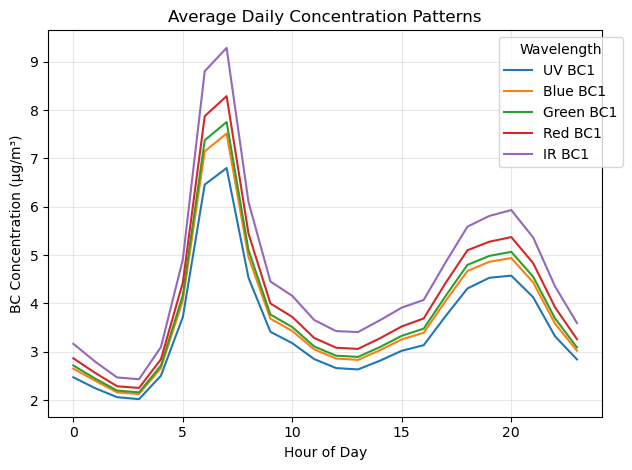

In [24]:
# Display peak hours for each wavelength
print("Peak Hours for Each Wavelength:")
for col, hour in stats['Peak Hours'].items():
    print(f"{col}: {hour:02d}:00")

# Create a visualization of hourly patterns
hourly_means = df.groupby('Hour')[bc_columns].mean()

plt.figure(figsize=(12, 6))
hourly_means.plot()
plt.title('Average Daily Concentration Patterns')
plt.xlabel('Hour of Day')
plt.ylabel('BC Concentration (µg/m³)')
plt.grid(True, alpha=0.3)
plt.legend(title='Wavelength', bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()

## 6.6 Statistical Distribution Analysis

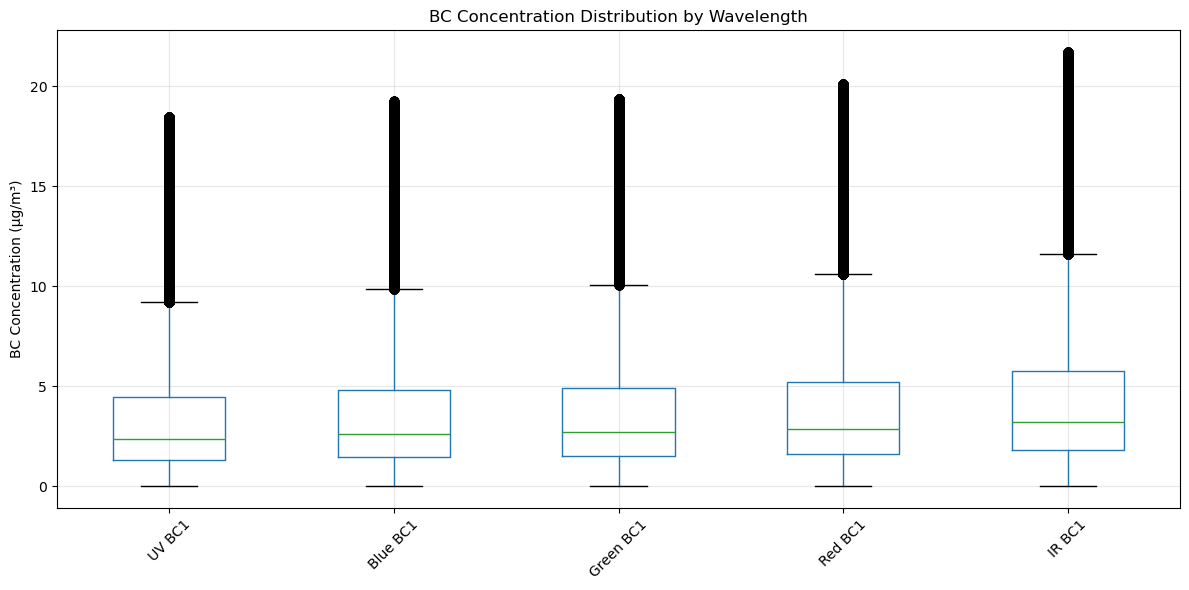


Detailed Statistical Summary:


UV BC1      Blue BC1     Green BC1       Red BC1        IR BC1
count  1.071306e+06  1.071432e+06  1.070778e+06  1.071008e+06  1.070475e+06
mean   3.469134e+00  3.747070e+00  3.840671e+00  4.068742e+00  4.502664e+00
std    3.250096e+00  3.427835e+00  3.471254e+00  3.630208e+00  3.948746e+00
min    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00
25%    1.285000e+00  1.431000e+00  1.491000e+00  1.608000e+00  1.827000e+00
50%    2.350000e+00  2.588000e+00  2.681000e+00  2.870000e+00  3.221000e+00
75%    4.456000e+00  4.810000e+00  4.927000e+00  5.211000e+00  5.747000e+00
max    1.847100e+01  1.924400e+01  1.937400e+01  2.012100e+01  2.171200e+01

In [25]:
# Create box plots for each wavelength
plt.figure(figsize=(12, 6))
df[bc_columns].boxplot()
plt.title('BC Concentration Distribution by Wavelength')
plt.ylabel('BC Concentration (µg/m³)')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Display detailed statistical summary
print("\nDetailed Statistical Summary:")
display(df[bc_columns].describe())

# 7. Ethiopian Seasonal Analysis

## 7.1 Remap Seasons to Ethiopian Calendar

In [26]:
# Define Ethiopian seasons based on months
def map_ethiopian_seasons(month):
    if month in [10, 11, 12, 1, 2]:
        return 'Dry Season'
    elif month in [3, 4, 5]:
        return 'Belg Rainy Season'
    else:  # months 6-9
        return 'Kiremt Rainy Season'

# Add Ethiopian seasons to the dataframe
df['Ethiopian_Season'] = df.index.map(lambda x: map_ethiopian_seasons(x.month))

## 7.2 Seasonal BC Concentration Analysis

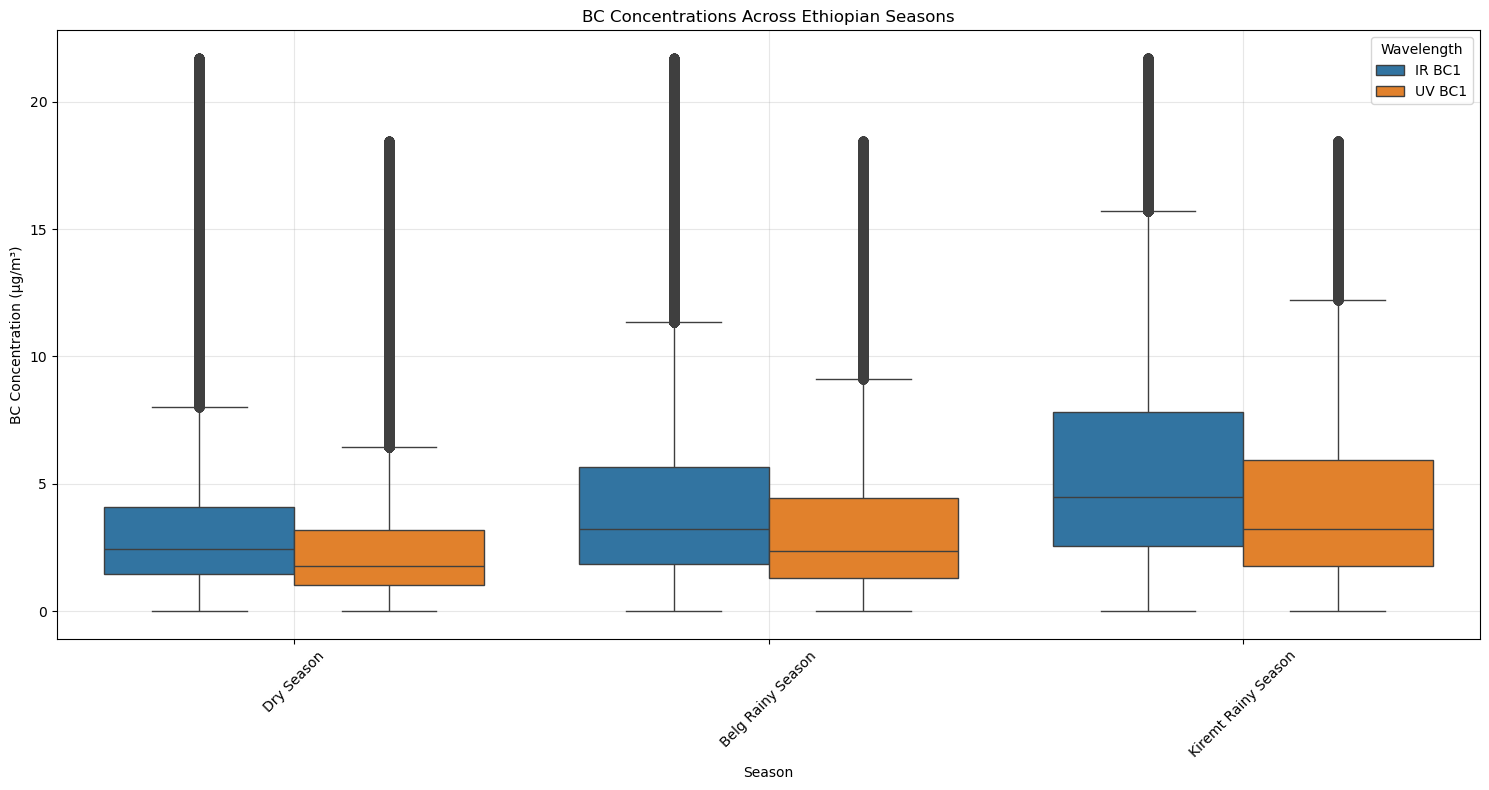


Seasonal Statistics:


UV BC1                   Blue BC1                   \
                         mean       std median      mean       std median   
Ethiopian_Season                                                            
Belg Rainy Season    3.463975  3.193664  2.380  3.734241  3.370377  2.610   
Dry Season           2.608927  2.575208  1.772  2.810800  2.702698  1.958   
Kiremt Rainy Season  4.418132  3.671107  3.221  4.785507  3.862785  3.559   

                    Green BC1                    Red BC1                   \
                         mean       std median      mean       std median   
Ethiopian_Season                                                            
Belg Rainy Season    3.824227  3.414423  2.698  4.045155  3.568399  2.882   
Dry Season           2.877106  2.729047  2.036  3.037414  2.834390  2.182   
Kiremt Rainy Season  4.911765  3.907128  3.689  5.220079  4.087539  3.964   

                       IR BC1                    
                         mean       std  median  
Ethiopian_Season                                 
Belg Rainy Season    4.467894  3.873161  3.2250  
Dry Season           3.343977  3.056413  2.4580  
Kiremt Rainy Season  5.802512  4.448218  4.4765

In [27]:
# Calculate seasonal statistics
seasonal_stats = df.groupby('Ethiopian_Season')[bc_columns].agg(['mean', 'std', 'median'])

# Create the plot
plt.figure(figsize=(15, 8))
seasons_order = ['Dry Season', 'Belg Rainy Season', 'Kiremt Rainy Season']

# Prepare the data for plotting
melted_df = df.melt(value_vars=['IR BC1', 'UV BC1'], 
                    id_vars=['Ethiopian_Season'],
                    var_name='Wavelength', 
                    value_name='Concentration')

# Create the boxplot
sns.boxplot(data=melted_df,
            x='Ethiopian_Season', 
            y='Concentration', 
            hue='Wavelength',
            order=seasons_order)

plt.title('BC Concentrations Across Ethiopian Seasons')
plt.xlabel('Season')
plt.ylabel('BC Concentration (µg/m³)')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Display seasonal statistics
print("\nSeasonal Statistics:")
display(seasonal_stats)

## 7.3 Seasonal Source Apportionment

/opt/anaconda3/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


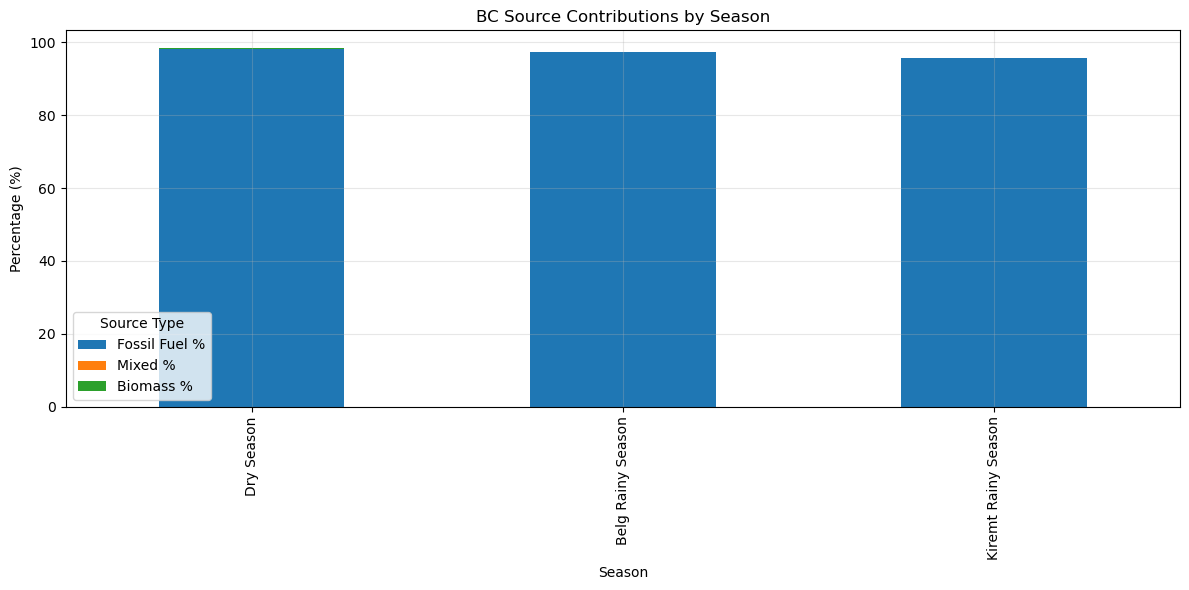

In [28]:
# Calculate AAE statistics by season
aae = np.log(df['UV BC1'] / df['IR BC1']) / np.log(880/375)
df['AAE'] = aae

seasonal_sources = {}
for season in seasons_order:
    season_data = df[df['Ethiopian_Season'] == season]['AAE']
    seasonal_sources[season] = {
        'Fossil Fuel %': (season_data < 1.2).mean() * 100,
        'Mixed %': ((season_data >= 1.2) & (season_data <= 1.6)).mean() * 100,
        'Biomass %': (season_data > 1.6).mean() * 100
    }

# Create stacked bar plot for source contributions
source_df = pd.DataFrame(seasonal_sources).T
source_df.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('BC Source Contributions by Season')
plt.xlabel('Season')
plt.ylabel('Percentage (%)')
plt.legend(title='Source Type')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 7.4 Seasonal Diurnal Patterns

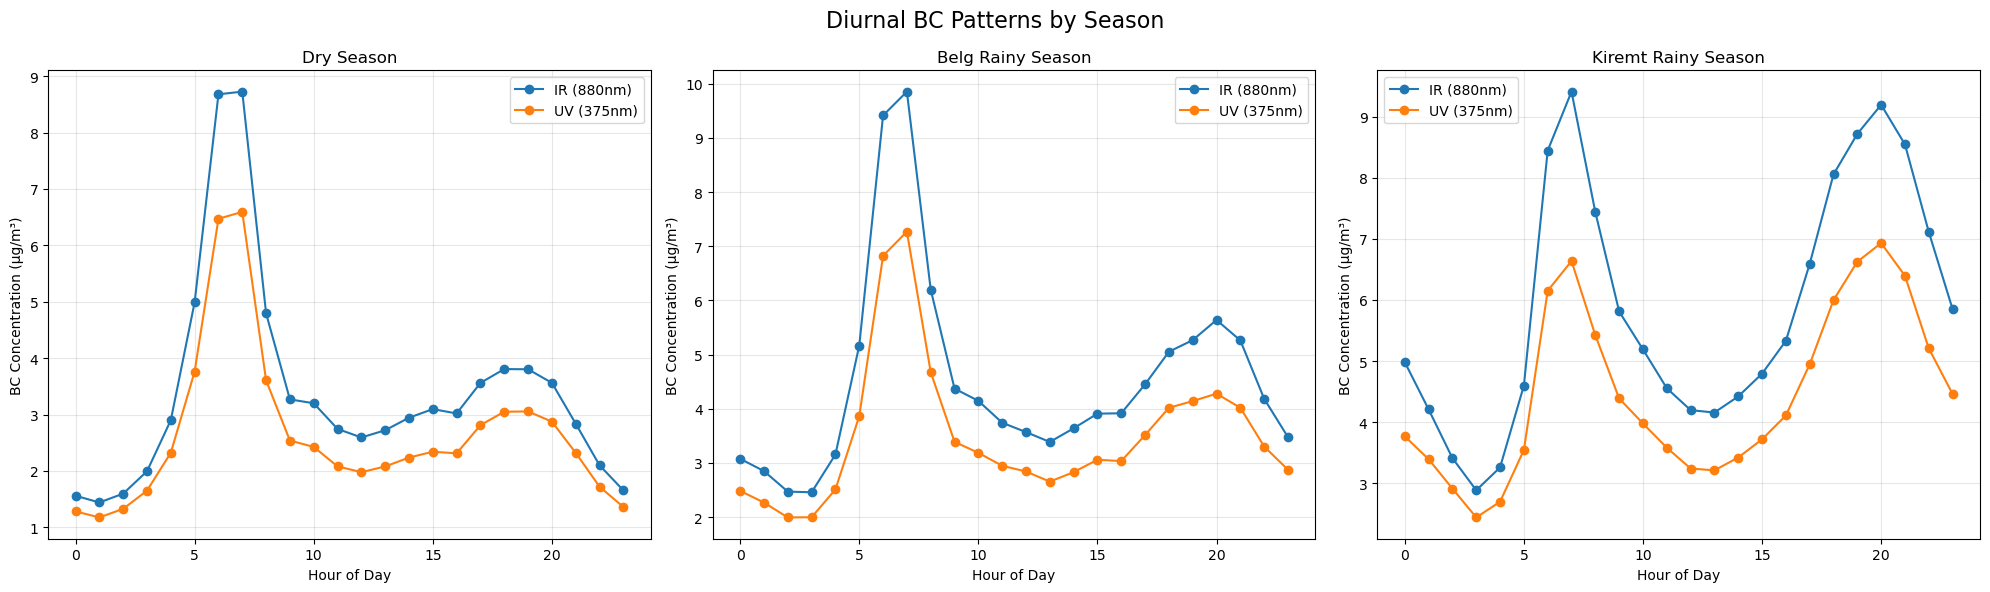

In [29]:
# Create subplots for diurnal patterns in each season
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle('Diurnal BC Patterns by Season', fontsize=16)

for idx, season in enumerate(seasons_order):
    season_data = df[df['Ethiopian_Season'] == season]
    hourly_avg = season_data.groupby('Hour')[['IR BC1', 'UV BC1']].mean()
    
    axes[idx].plot(hourly_avg.index, hourly_avg['IR BC1'], 
                  label='IR (880nm)', marker='o')
    axes[idx].plot(hourly_avg.index, hourly_avg['UV BC1'], 
                  label='UV (375nm)', marker='o')
    axes[idx].set_title(season)
    axes[idx].set_xlabel('Hour of Day')
    axes[idx].set_ylabel('BC Concentration (µg/m³)')
    axes[idx].grid(True, alpha=0.3)
    axes[idx].legend()

plt.tight_layout()
plt.show()

## 7.5 Environmental Correlations by Season

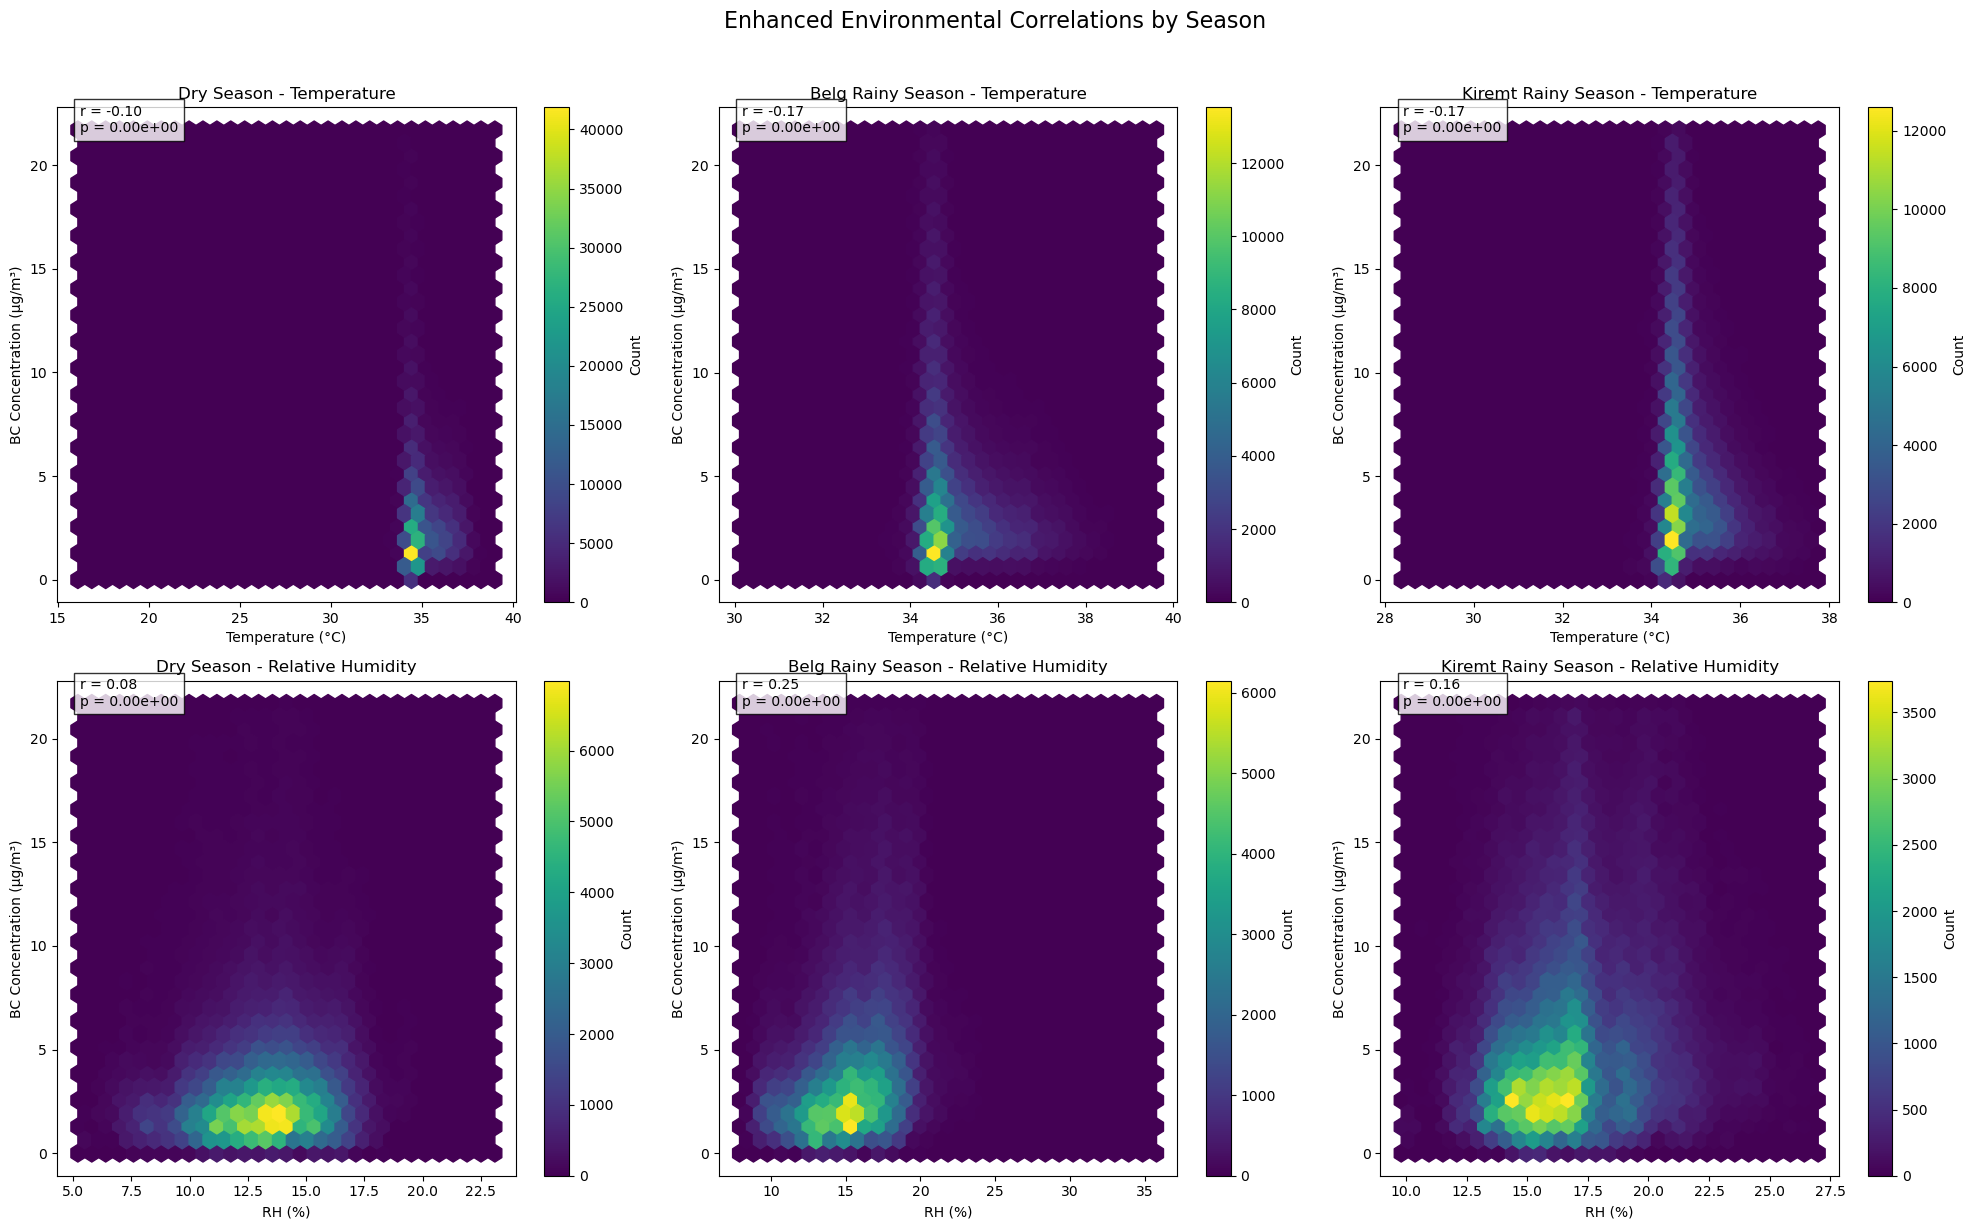


Detailed Environmental Correlation Statistics:

Dry Season
------------------------------

Temperature Relationship:
  Correlation: -0.101
  P-value: 0.00e+00
  Temperature Range: 16.1°C to 39.0°C
  Mean Temperature: 35.0°C
  Temperature Std Dev: 1.0°C

Humidity Relationship:
  Correlation: 0.079
  P-value: 0.00e+00
  Humidity Range: 5.2% to 27.0%
  Mean Humidity: 13.2%
  Humidity Std Dev: 2.3%

Belg Rainy Season
------------------------------

Temperature Relationship:
  Correlation: -0.172
  P-value: 0.00e+00
  Temperature Range: 30.1°C to 39.6°C
  Mean Temperature: 35.0°C
  Temperature Std Dev: 0.8°C

Humidity Relationship:
  Correlation: 0.247
  P-value: 0.00e+00
  Humidity Range: 7.9% to 36.3%
  Mean Humidity: 15.3%
  Humidity Std Dev: 2.7%

Kiremt Rainy Season
------------------------------

Temperature Relationship:
  Correlation: -0.173
  P-value: 0.00e+00
  Temperature Range: 28.4°C to 37.8°C
  Mean Temperature: 34.8°C
  Temperature Std Dev: 0.6°C

Humidity Relationship:
  Co

In [30]:
from scipy.stats import pearsonr

# Create enhanced environmental correlation plots
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle('Enhanced Environmental Correlations by Season', fontsize=16, y=1.02)

seasons_order = ['Dry Season', 'Belg Rainy Season', 'Kiremt Rainy Season']
cmap = 'viridis'

# Dictionary to store statistics
stat_results = {}

for idx, season in enumerate(seasons_order):
    season_data = df[df['Ethiopian_Season'] == season]
    stat_results[season] = {}
    
    # Temperature correlation with hexbin plot
    hb = axes[0, idx].hexbin(season_data['Sample temp (C)'], 
                            season_data['IR BC1'],
                            gridsize=30,
                            cmap=cmap)
    
    # Add trendline
    temp_z = np.polyfit(season_data['Sample temp (C)'], season_data['IR BC1'], 2)
    temp_p = np.poly1d(temp_z)
    temp_x_new = np.linspace(season_data['Sample temp (C)'].min(), 
                            season_data['Sample temp (C)'].max(), 100)
    axes[0, idx].plot(temp_x_new, temp_p(temp_x_new), 'r--', linewidth=2)
    
    # Calculate temperature statistics
    temp_data = season_data[['Sample temp (C)', 'IR BC1']].dropna()
    temp_corr, temp_p_val = pearsonr(temp_data['Sample temp (C)'], 
                                    temp_data['IR BC1'])
    
    stat_results[season]['Temperature'] = {
        'correlation': temp_corr,
        'p_value': temp_p_val,
        'range': (season_data['Sample temp (C)'].min(), season_data['Sample temp (C)'].max()),
        'mean': season_data['Sample temp (C)'].mean(),
        'std': season_data['Sample temp (C)'].std()
    }
    
    axes[0, idx].text(0.05, 0.95, f'r = {temp_corr:.2f}\np = {temp_p_val:.2e}', 
                     transform=axes[0, idx].transAxes,
                     bbox=dict(facecolor='white', alpha=0.8))
    
    axes[0, idx].set_title(f'{season} - Temperature')
    axes[0, idx].set_xlabel('Temperature (°C)')
    axes[0, idx].set_ylabel('BC Concentration (µg/m³)')
    fig.colorbar(hb, ax=axes[0, idx], label='Count')
    
    # Humidity correlation with hexbin plot
    hb = axes[1, idx].hexbin(season_data['Sample RH (%)'], 
                            season_data['IR BC1'],
                            gridsize=30,
                            cmap=cmap)
    
    # Add trendline
    rh_z = np.polyfit(season_data['Sample RH (%)'], season_data['IR BC1'], 2)
    rh_p = np.poly1d(rh_z)
    rh_x_new = np.linspace(season_data['Sample RH (%)'].min(), 
                          season_data['Sample RH (%)'].max(), 100)
    axes[1, idx].plot(rh_x_new, rh_p(rh_x_new), 'r--', linewidth=2)
    
    # Calculate humidity statistics
    rh_data = season_data[['Sample RH (%)', 'IR BC1']].dropna()
    rh_corr, rh_p_val = pearsonr(rh_data['Sample RH (%)'], 
                                rh_data['IR BC1'])
    
    stat_results[season]['Humidity'] = {
        'correlation': rh_corr,
        'p_value': rh_p_val,
        'range': (season_data['Sample RH (%)'].min(), season_data['Sample RH (%)'].max()),
        'mean': season_data['Sample RH (%)'].mean(),
        'std': season_data['Sample RH (%)'].std()
    }
    
    axes[1, idx].text(0.05, 0.95, f'r = {rh_corr:.2f}\np = {rh_p_val:.2e}', 
                     transform=axes[1, idx].transAxes,
                     bbox=dict(facecolor='white', alpha=0.8))
    
    axes[1, idx].set_title(f'{season} - Relative Humidity')
    axes[1, idx].set_xlabel('RH (%)')
    axes[1, idx].set_ylabel('BC Concentration (µg/m³)')
    fig.colorbar(hb, ax=axes[1, idx], label='Count')

plt.tight_layout()
plt.show()

# Print detailed statistics
print("\nDetailed Environmental Correlation Statistics:")
print("=" * 50)
for season in seasons_order:
    print(f"\n{season}")
    print("-" * 30)
    
    # Temperature statistics
    temp_stats = stat_results[season]['Temperature']
    print("\nTemperature Relationship:")
    print(f"  Correlation: {temp_stats['correlation']:.3f}")
    print(f"  P-value: {temp_stats['p_value']:.2e}")
    print(f"  Temperature Range: {temp_stats['range'][0]:.1f}°C to {temp_stats['range'][1]:.1f}°C")
    print(f"  Mean Temperature: {temp_stats['mean']:.1f}°C")
    print(f"  Temperature Std Dev: {temp_stats['std']:.1f}°C")
    
    # Humidity statistics
    rh_stats = stat_results[season]['Humidity']
    print("\nHumidity Relationship:")
    print(f"  Correlation: {rh_stats['correlation']:.3f}")
    print(f"  P-value: {rh_stats['p_value']:.2e}")
    print(f"  Humidity Range: {rh_stats['range'][0]:.1f}% to {rh_stats['range'][1]:.1f}%")
    print(f"  Mean Humidity: {rh_stats['mean']:.1f}%")
    print(f"  Humidity Std Dev: {rh_stats['std']:.1f}%")

In [31]:
# Print RH value distribution
print("Relative Humidity Distribution:")
print("\nOverall RH Statistics:")
print(df['Sample RH (%)'].describe())

print("\nRH Value Counts (binned):")
print(pd.cut(df['Sample RH (%)'], bins=10).value_counts().sort_index())

# Check for any potential scaling issues
print("\nSample of raw RH values:")
print(df['Sample RH (%)'].head(10))

# Check if values might be in decimal form (0-1) instead of percentage
print("\nCheck for values below 1.0:")
print(f"Number of values below 1.0: {(df['Sample RH (%)'] < 1.0).sum()}")

Relative Humidity Distribution:

Overall RH Statistics:
count    1.095086e+06
mean     1.502525e+01
std      2.879299e+00
min      5.200000e+00
25%      1.320000e+01
50%      1.500000e+01
75%      1.690000e+01
max      3.630000e+01
Name: Sample RH (%), dtype: float64

RH Value Counts (binned):
Sample RH (%)
(5.169, 8.31]      12204
(8.31, 11.42]     105248
(11.42, 14.53]    358662
(14.53, 17.64]    440823
(17.64, 20.75]    148629
(20.75, 23.86]     25801
(23.86, 26.97]      3683
(26.97, 30.08]        18
(30.08, 33.19]         9
(33.19, 36.3]          9
Name: count, dtype: int64

Sample of raw RH values:
Time (Local)
2022-04-12 12:46:01+03:00    36.3
2022-04-12 12:47:01+03:00    35.8
2022-04-12 12:48:01+03:00    35.4
2022-04-12 12:49:01+03:00    35.0
2022-04-12 12:50:01+03:00    34.7
2022-04-12 12:51:01+03:00    34.3
2022-04-12 12:52:01+03:00    34.0
2022-04-12 12:53:01+03:00    33.7
2022-04-12 12:54:01+03:00    33.4
2022-04-12 12:55:01+03:00    33.1
Name: Sample RH (%), dtype: float64



Analyzing Ethiopian seasonal patterns...


/var/folders/q8/4q55gl35679357bs417130z40000gn/T/ipykernel_10620/3528632990.py:64: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  peak_hours = season_data.groupby('DayOfWeek').apply(
/var/folders/q8/4q55gl35679357bs417130z40000gn/T/ipykernel_10620/3528632990.py:64: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  peak_hours = season_data.groupby('DayOfWeek').apply(
/var/folders/q8/4q55gl35679357bs417130z40000gn


Weekly Pattern Analysis by Ethiopian Season:

Dry Season:

Daily Averages:
DayOfWeek
0    3.352
1    3.532
2    3.594
3    3.552
4    3.384
5    3.343
6    2.675
Name: mean, dtype: float64

Peak Hours by Day:
  Monday: 06:00
  Tuesday: 07:00
  Wednesday: 06:00
  Thursday: 07:00
  Friday: 07:00
  Saturday: 06:00
  Sunday: 06:00

Belg Rainy Season:

Daily Averages:
DayOfWeek
0    4.411
1    4.434
2    4.654
3    4.963
4    4.555
5    4.594
6    3.688
Name: mean, dtype: float64

Peak Hours by Day:
  Monday: 07:00
  Tuesday: 07:00
  Wednesday: 07:00
  Thursday: 06:00
  Friday: 07:00
  Saturday: 07:00
  Sunday: 07:00

Kiremt Rainy Season:

Daily Averages:
DayOfWeek
0    5.693
1    6.126
2    6.130
3    6.171
4    6.162
5    5.692
6    4.678
Name: mean, dtype: float64

Peak Hours by Day:
  Monday: 07:00
  Tuesday: 20:00
  Wednesday: 07:00
  Thursday: 20:00
  Friday: 07:00
  Saturday: 07:00
  Sunday: 20:00


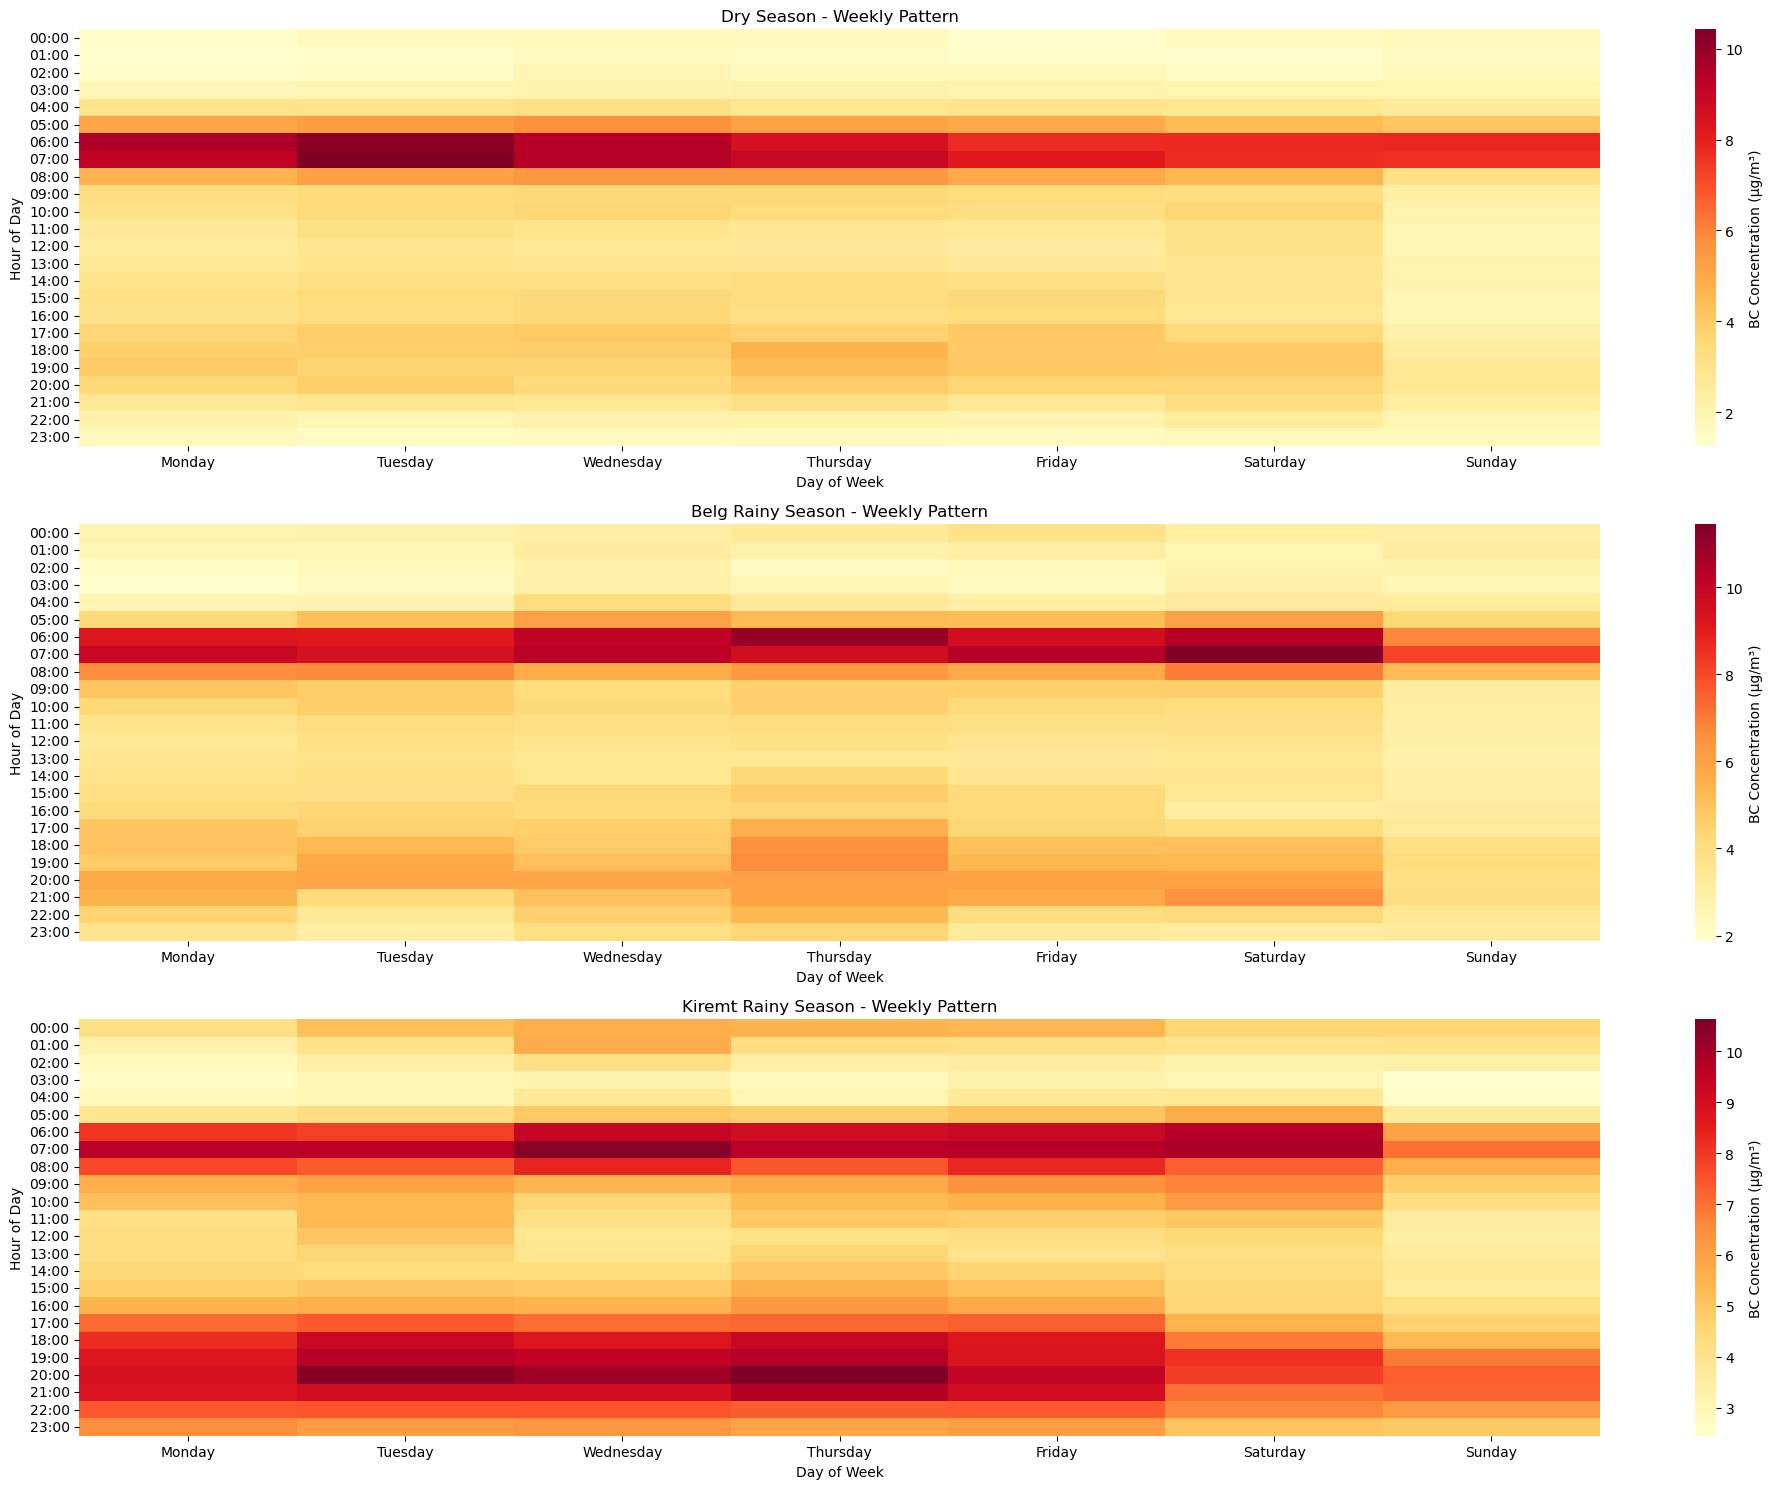

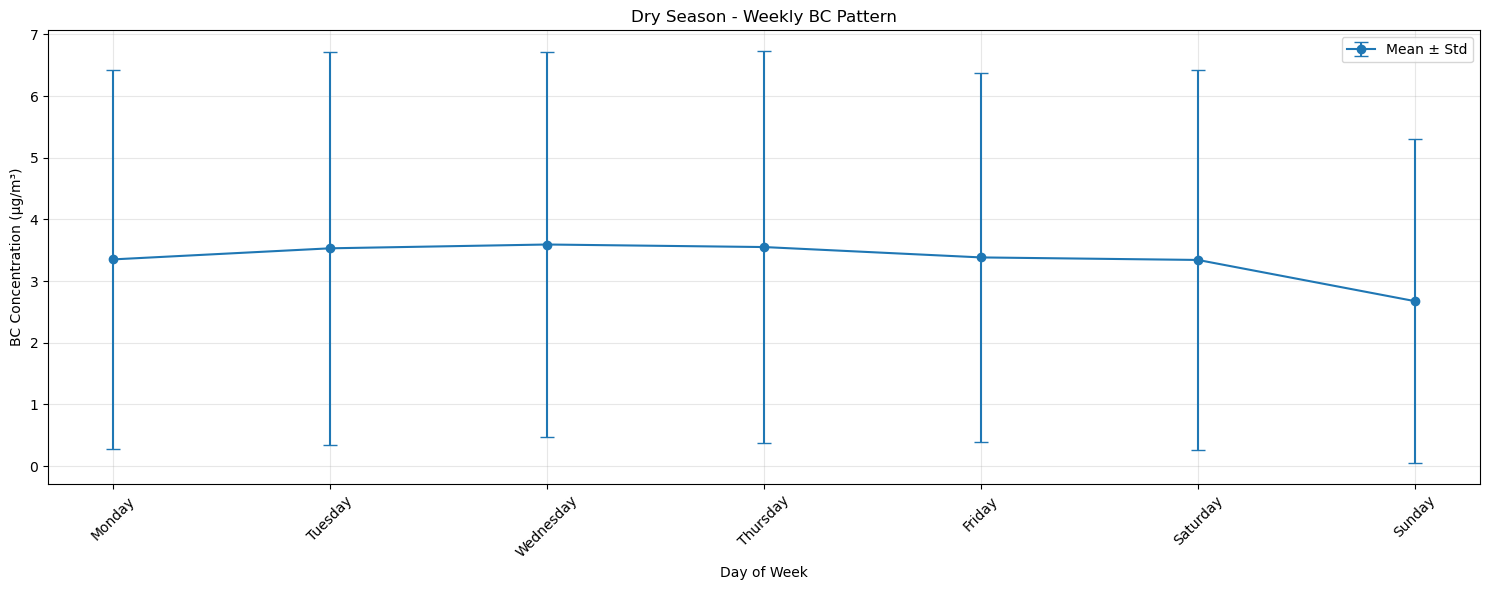

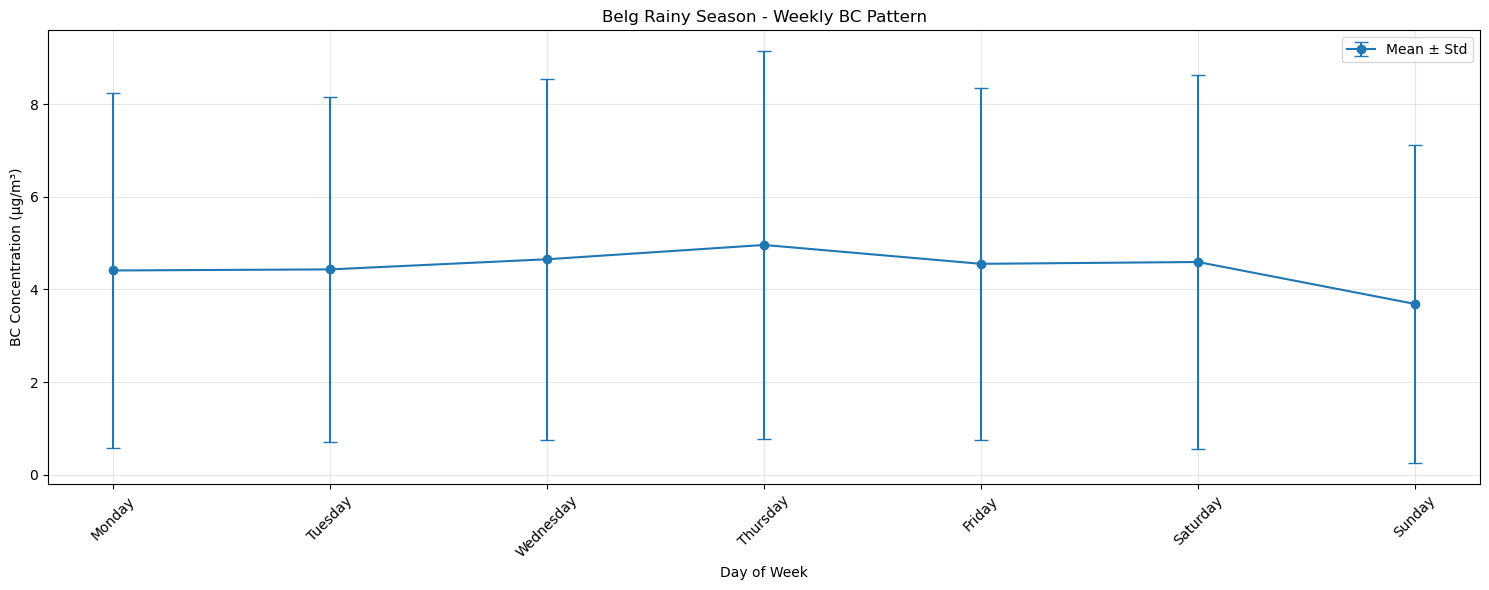

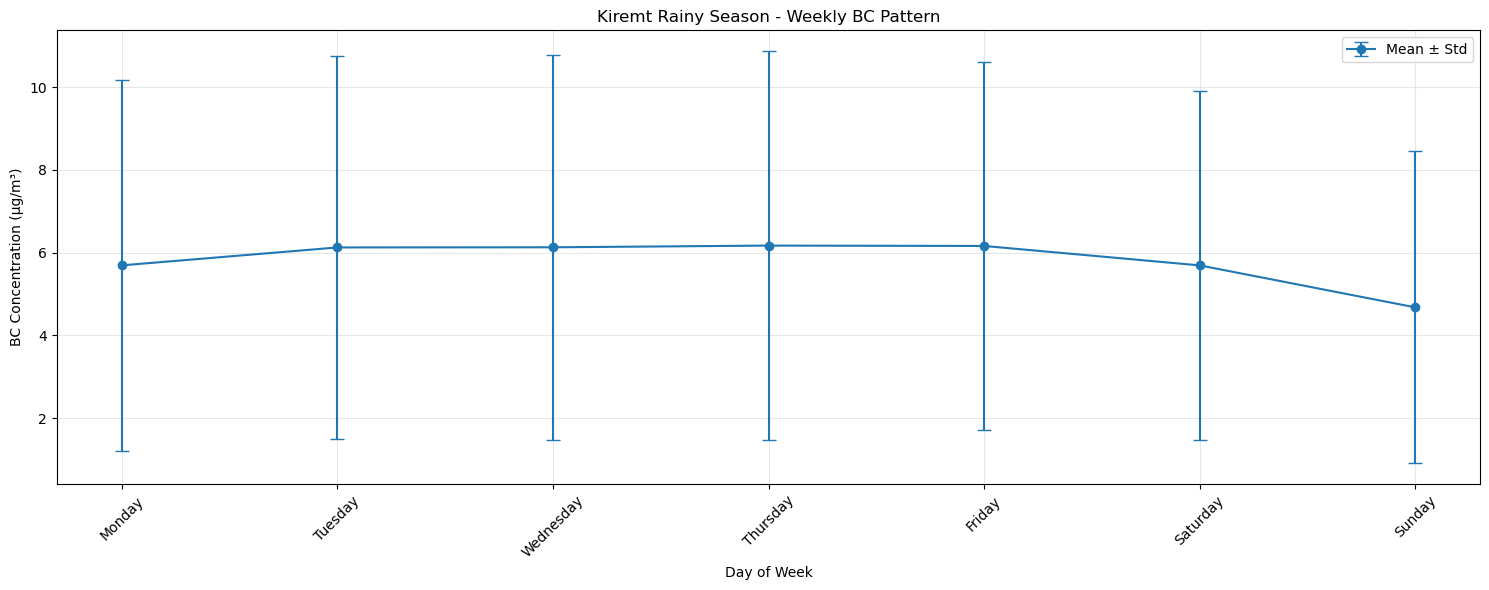

In [32]:
def analyze_ethiopian_seasonal_patterns(df):
    """Analyze weekly and daily patterns for each Ethiopian season"""
    print("\nAnalyzing Ethiopian seasonal patterns...")
    
    # Define Ethiopian seasons based on months
    def map_ethiopian_seasons(month):
        if month in [10, 11, 12, 1, 2]:
            return 'Dry Season'
        elif month in [3, 4, 5]:
            return 'Belg Rainy Season'
        else:  # months 6-9
            return 'Kiremt Rainy Season'
    
    # Add Ethiopian seasons if not already present
    if 'Ethiopian_Season' not in df.columns:
        df['Ethiopian_Season'] = df.index.map(lambda x: map_ethiopian_seasons(x.month))
    
    # Add day of week if not present
    if 'DayOfWeek' not in df.columns:
        df['DayOfWeek'] = df.index.dayofweek
    
    seasons_order = ['Dry Season', 'Belg Rainy Season', 'Kiremt Rainy Season']
    
    # Create weekly pattern heatmaps for each season
    plt.figure(figsize=(20, 15))
    
    for idx, season in enumerate(seasons_order, 1):
        season_data = df[df['Ethiopian_Season'] == season]
        
        # Create pivot table for weekly pattern
        weekly_pattern = season_data.pivot_table(
            values='IR BC1',
            index='Hour',
            columns='DayOfWeek',
            aggfunc='mean'
        )
        
        plt.subplot(3, 1, idx)
        sns.heatmap(
            weekly_pattern,
            cmap='YlOrRd',
            xticklabels=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],
            yticklabels=[f'{h:02d}:00' for h in range(24)],
            cbar_kws={'label': 'BC Concentration (µg/m³)'}
        )
        plt.title(f'{season} - Weekly Pattern')
        plt.xlabel('Day of Week')
        plt.ylabel('Hour of Day')
    
    plt.tight_layout()
    plt.show
    
    # Calculate statistics for each season
    seasonal_stats = {}
    for season in seasons_order:
        season_data = df[df['Ethiopian_Season'] == season]
        
        # Weekly statistics
        weekly_stats = season_data.groupby('DayOfWeek')['IR BC1'].agg([
            'mean', 'std', 'min', 'max'
        ])
        
        # Peak hours by day
        peak_hours = season_data.groupby('DayOfWeek').apply(
            lambda x: x.groupby('Hour')['IR BC1'].mean().idxmax()
        )
        
        # Store statistics
        seasonal_stats[season] = {
            'weekly_stats': weekly_stats,
            'peak_hours': peak_hours
        }
        
        # Create detailed weekly pattern plot
        plt.figure(figsize=(15, 6))
        weekly_means = season_data.groupby('DayOfWeek')['IR BC1'].mean()
        weekly_std = season_data.groupby('DayOfWeek')['IR BC1'].std()
        
        plt.errorbar(
            range(7),
            weekly_means,
            yerr=weekly_std,
            fmt='o-',
            capsize=5,
            label='Mean ± Std'
        )
        
        plt.title(f'{season} - Weekly BC Pattern')
        plt.xlabel('Day of Week')
        plt.ylabel('BC Concentration (µg/m³)')
        plt.xticks(
            range(7),
            ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],
            rotation=45
        )
        plt.grid(True, alpha=0.3)
        plt.legend()
        plt.tight_layout()
        plt.show

    
    # Print summary statistics
    print("\nWeekly Pattern Analysis by Ethiopian Season:")
    for season in seasons_order:
        print(f"\n{season}:")
        print("\nDaily Averages:")
        print(seasonal_stats[season]['weekly_stats']['mean'].round(3))
        print("\nPeak Hours by Day:")
        for day, hour in seasonal_stats[season]['peak_hours'].items():
            day_name = calendar.day_name[day]
            print(f"  {day_name}: {hour:02d}:00")
    
    return seasonal_stats

# Run the analysis
seasonal_stats = analyze_ethiopian_seasonal_patterns(df)

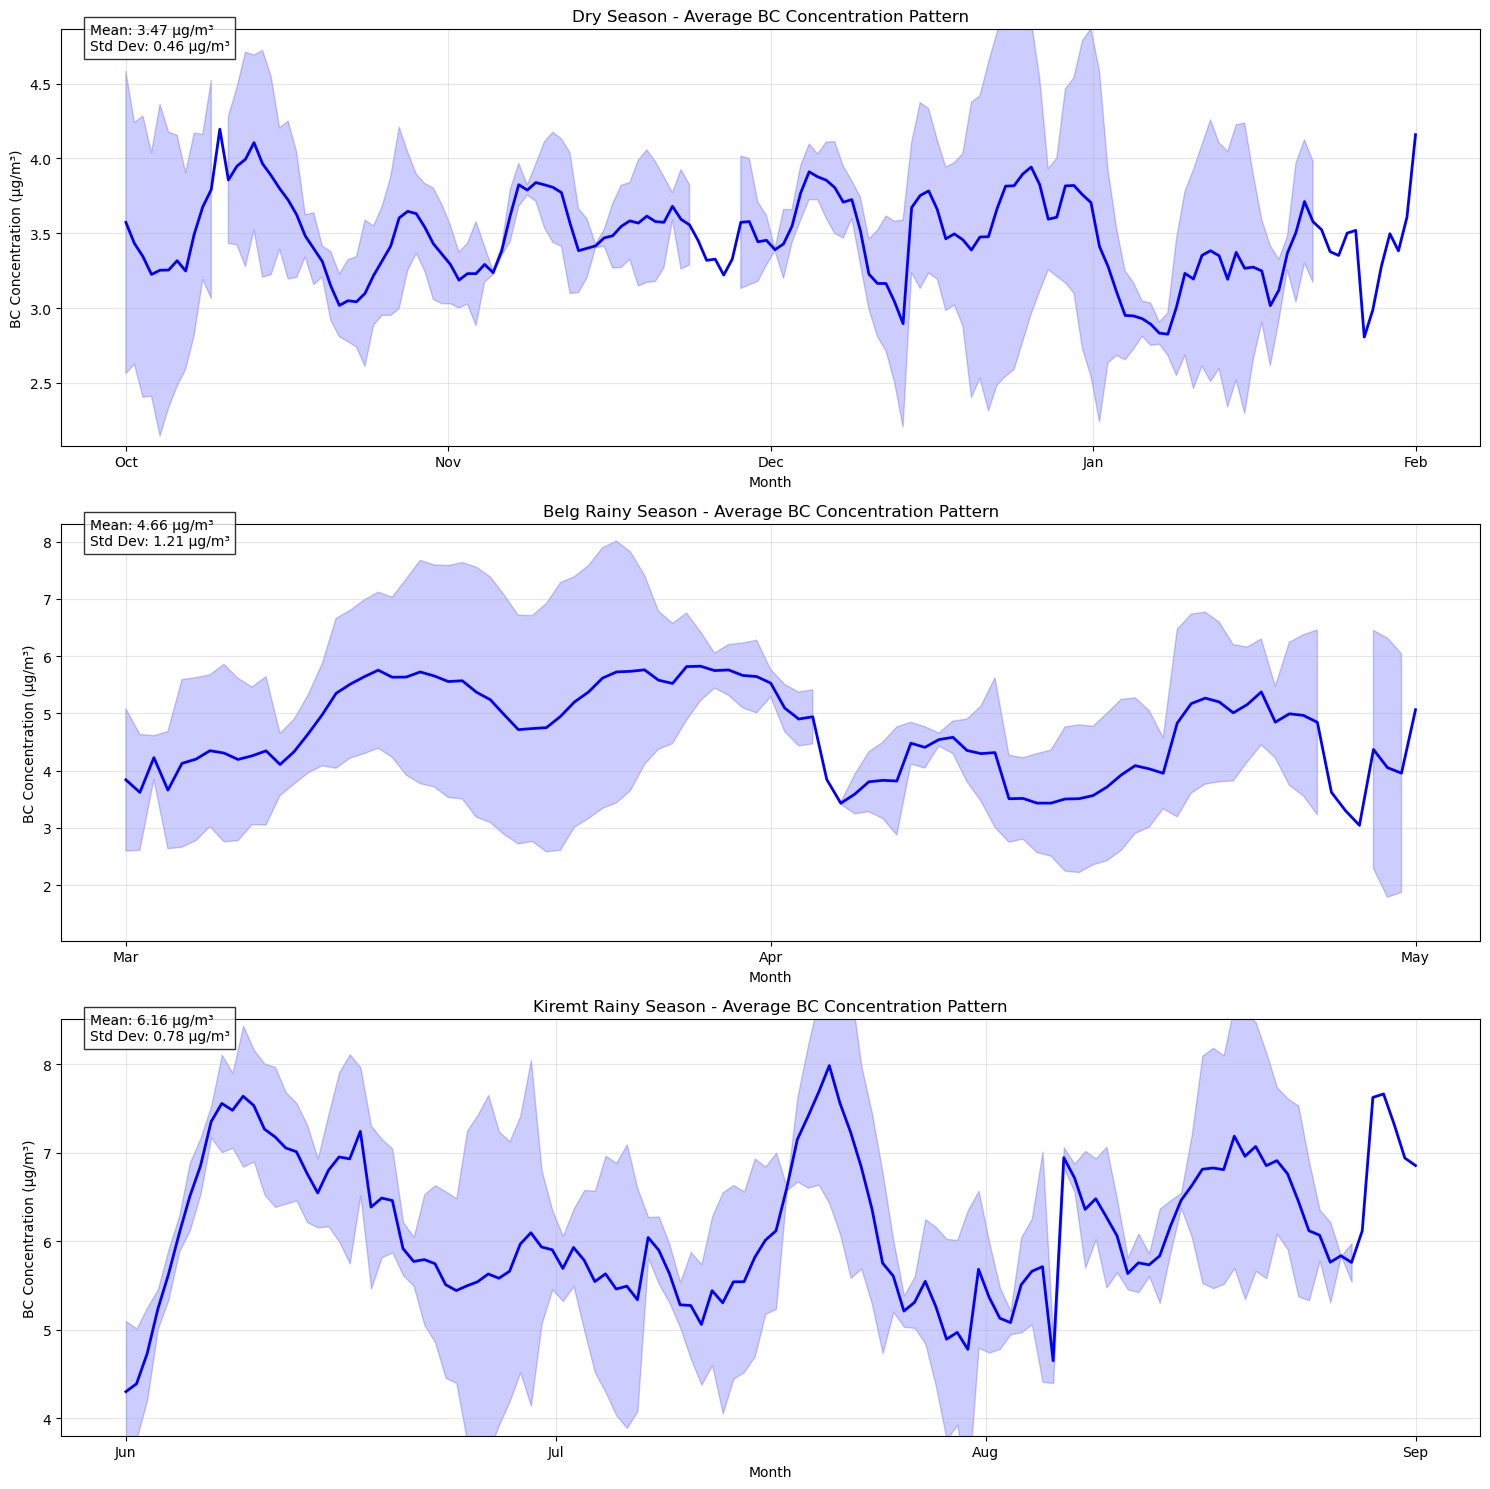

In [33]:
fig, axes = plt.subplots(3, 1, figsize=(15, 15))

season_months = {
    'Dry Season': [10, 11, 12, 1, 2],
    'Belg Rainy Season': [3, 4, 5],
    'Kiremt Rainy Season': [6, 7, 8, 9]
}

for idx, season in enumerate(seasons_order):
    # Get data for this season
    season_data = df[df['Ethiopian_Season'] == season].copy()
    
    # Create a day-of-season column
    season_data['dayofseason'] = season_data.index.dayofyear
    if season == 'Dry Season':
        # Adjust for dry season crossing year boundary
        season_data.loc[season_data.index.month >= 10, 'dayofseason'] = \
            season_data.loc[season_data.index.month >= 10].index.dayofyear
        season_data.loc[season_data.index.month < 3, 'dayofseason'] = \
            season_data.loc[season_data.index.month < 3].index.dayofyear + 365
    
    # First calculate 7-day rolling averages for each year
    all_years_data = []
    years = sorted(season_data.index.year.unique())
    
    for year in years:
        year_data = season_data[season_data.index.year == year]
        
        # Calculate hourly means first to handle multiple measurements per hour
        hourly_means = year_data.groupby(['dayofseason', 
                                        year_data.index.hour])['IR BC1'].mean()
        
        # Then calculate daily means
        daily_means = hourly_means.groupby('dayofseason').mean()
        
        # Calculate rolling average
        rolling_avg = daily_means.rolling(window=7, center=True, min_periods=1).mean()
        all_years_data.append(rolling_avg)
    
    # Combine all years' data
    all_years_df = pd.DataFrame(all_years_data).T  # Each column is a year
    
    # Calculate mean and std across years
    mean_series = all_years_df.mean(axis=1)
    std_series = all_years_df.std(axis=1)
    
    # Plot
    x_values = range(len(mean_series))
    axes[idx].plot(x_values, mean_series, 'b-', linewidth=2)
    axes[idx].fill_between(x_values, 
                          mean_series - std_series,
                          mean_series + std_series,
                          alpha=0.2, color='blue')
    
    # Set month ticks
    if season == 'Dry Season':
        month_labels = ['Oct', 'Nov', 'Dec', 'Jan', 'Feb']
    elif season == 'Belg Rainy Season':
        month_labels = ['Mar', 'Apr', 'May']
    else:
        month_labels = ['Jun', 'Jul', 'Aug', 'Sep']
        
    tick_positions = np.linspace(0, len(mean_series)-1, len(month_labels))
    axes[idx].set_xticks(tick_positions)
    axes[idx].set_xticklabels(month_labels)
    
    # Add labels and title
    axes[idx].set_title(f'{season} - Average BC Concentration Pattern')
    axes[idx].set_xlabel('Month')
    axes[idx].set_ylabel('BC Concentration (µg/m³)')
    
    # Add statistics
    mean_val = mean_series.mean()
    std_val = std_series.mean()
    axes[idx].text(0.02, 0.95, 
                  f'Mean: {mean_val:.2f} µg/m³\nStd Dev: {std_val:.2f} µg/m³',
                  transform=axes[idx].transAxes,
                  bbox=dict(facecolor='white', alpha=0.8))
    
    # Add grid
    axes[idx].grid(True, alpha=0.3)
    
    # Set y-axis limits to focus on the main variation
    y_min = mean_series.mean() - 3*std_series.mean()
    y_max = mean_series.mean() + 3*std_series.mean()
    axes[idx].set_ylim(y_min, y_max)

plt.tight_layout()
plt.show()

## 7.6 Key Findings

In [34]:
# Calculate key seasonal metrics
seasonal_summary = pd.DataFrame(index=seasons_order)

# Average BC levels
seasonal_summary['Avg_BC_IR'] = df.groupby('Ethiopian_Season')['IR BC1'].mean()
seasonal_summary['Avg_BC_UV'] = df.groupby('Ethiopian_Season')['UV BC1'].mean()

# Temperature and RH ranges
for season in seasons_order:
    season_data = df[df['Ethiopian_Season'] == season]
    seasonal_summary.loc[season, 'Temp_Range'] = f"{season_data['Sample temp (C)'].min():.1f}-{season_data['Sample temp (C)'].max():.1f}°C"
    seasonal_summary.loc[season, 'RH_Range'] = f"{season_data['Sample RH (%)'].min():.1f}-{season_data['Sample RH (%)'].max():.1f}%"

# Add daily peak hours (fixed version)
peak_hours = {}
for season in seasons_order:
    season_data = df[df['Ethiopian_Season'] == season]
    peak_hours[season] = season_data.groupby('Hour')['IR BC1'].mean().idxmax()
seasonal_summary['Peak_Hour'] = pd.Series(peak_hours)

# Calculate and add source dominance
wavelength_ratio = np.log(880/375)
df['AAE'] = np.log(df['UV BC1'] / df['IR BC1']) / wavelength_ratio

seasonal_sources = {}
for season in seasons_order:
    season_data = df[df['Ethiopian_Season'] == season]['AAE']
    seasonal_sources[season] = {
        'Fossil Fuel': (season_data < 1.2).mean() * 100,
        'Mixed': ((season_data >= 1.2) & (season_data <= 1.6)).mean() * 100,
        'Biomass': (season_data > 1.6).mean() * 100
    }
    # Add dominant source to summary
    seasonal_summary.loc[season, 'Dominant_Source'] = max(seasonal_sources[season].items(), 
                                                        key=lambda x: x[1])[0]

print("Seasonal Summary:")
display(seasonal_summary)

/opt/anaconda3/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Seasonal Summary:


Avg_BC_IR  Avg_BC_UV   Temp_Range   RH_Range  Peak_Hour  \
Dry Season            3.343977   2.608927  16.1-39.0°C  5.2-27.0%          7   
Belg Rainy Season     4.467894   3.463975  30.1-39.6°C  7.9-36.3%          7   
Kiremt Rainy Season   5.802512   4.418132  28.4-37.8°C  9.8-27.0%          7   

                    Dominant_Source  
Dry Season              Fossil Fuel  
Belg Rainy Season       Fossil Fuel  
Kiremt Rainy Season     Fossil Fuel

# 8. Additional Black Carbon Analysis
# 
# 8.1 Rate of Change Analysis

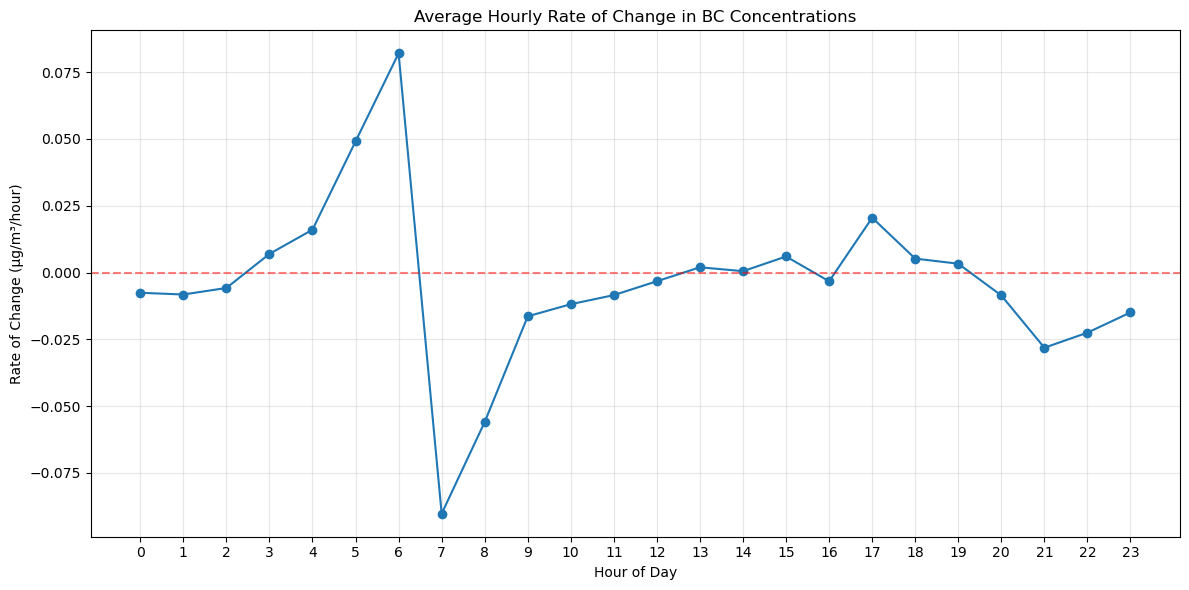


Rate of Change Statistics:
count    1.066180e+06
mean    -3.744788e-03
std      1.202614e+00
min     -1.957000e+01
25%     -4.360000e-01
50%     -2.300000e-02
75%      3.910000e-01
max      1.869000e+01
Name: IR_BC_RateOfChange, dtype: float64


In [35]:
# Calculate rate of change
df['IR_BC_RateOfChange'] = df['IR BC1'].diff()

# Create hourly rate of change plot
plt.figure(figsize=(12, 6))
hourly_rates = df.groupby('Hour')['IR_BC_RateOfChange'].mean()
plt.plot(hourly_rates.index, hourly_rates.values, marker='o')
plt.title('Average Hourly Rate of Change in BC Concentrations')
plt.xlabel('Hour of Day')
plt.ylabel('Rate of Change (µg/m³/hour)')
plt.grid(True, alpha=0.3)
plt.xticks(range(24))
plt.axhline(y=0, color='r', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig(os.path.join(dirs['plots'], 'bc_rate_of_change.png'))
plt.show()

print("\nRate of Change Statistics:")
print(df['IR_BC_RateOfChange'].describe())

# 8.2 Weekend Effect Analysis


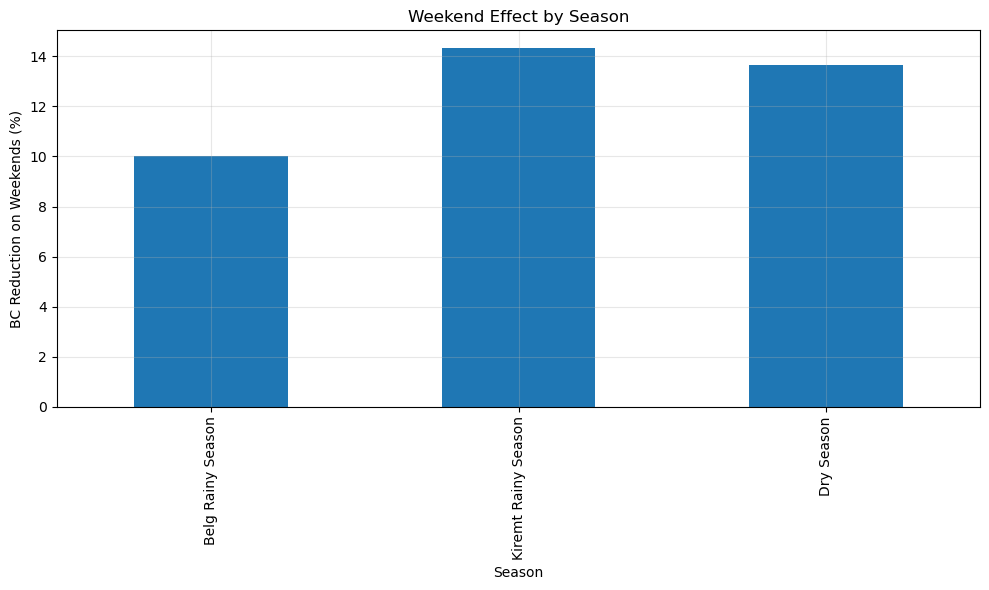


Weekend Effect Analysis:
                     Reduction (%)  Weekday Avg  Weekend Avg
Belg Rainy Season            10.01         4.60         4.14
Kiremt Rainy Season          14.32         6.06         5.19
Dry Season                   13.67         3.48         3.01


In [36]:
# Calculate weekend effect by season
weekend_effect = pd.DataFrame()
for season in df['Ethiopian_Season'].unique():
    season_data = df[df['Ethiopian_Season'] == season]
    weekday_avg = season_data[season_data['DayOfWeek'] < 5]['IR BC1'].mean()
    weekend_avg = season_data[season_data['DayOfWeek'] >= 5]['IR BC1'].mean()
    reduction = ((weekday_avg - weekend_avg) / weekday_avg) * 100
    weekend_effect.loc[season, 'Reduction (%)'] = reduction
    weekend_effect.loc[season, 'Weekday Avg'] = weekday_avg
    weekend_effect.loc[season, 'Weekend Avg'] = weekend_avg

# Plot weekend effect
plt.figure(figsize=(10, 6))
weekend_effect['Reduction (%)'].plot(kind='bar')
plt.title('Weekend Effect by Season')
plt.xlabel('Season')
plt.ylabel('BC Reduction on Weekends (%)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(dirs['plots'], 'weekend_effect.png'))
plt.show()

print("\nWeekend Effect Analysis:")
print(weekend_effect.round(2))

# 8.3 Cross-Wavelength Ratio Analysis

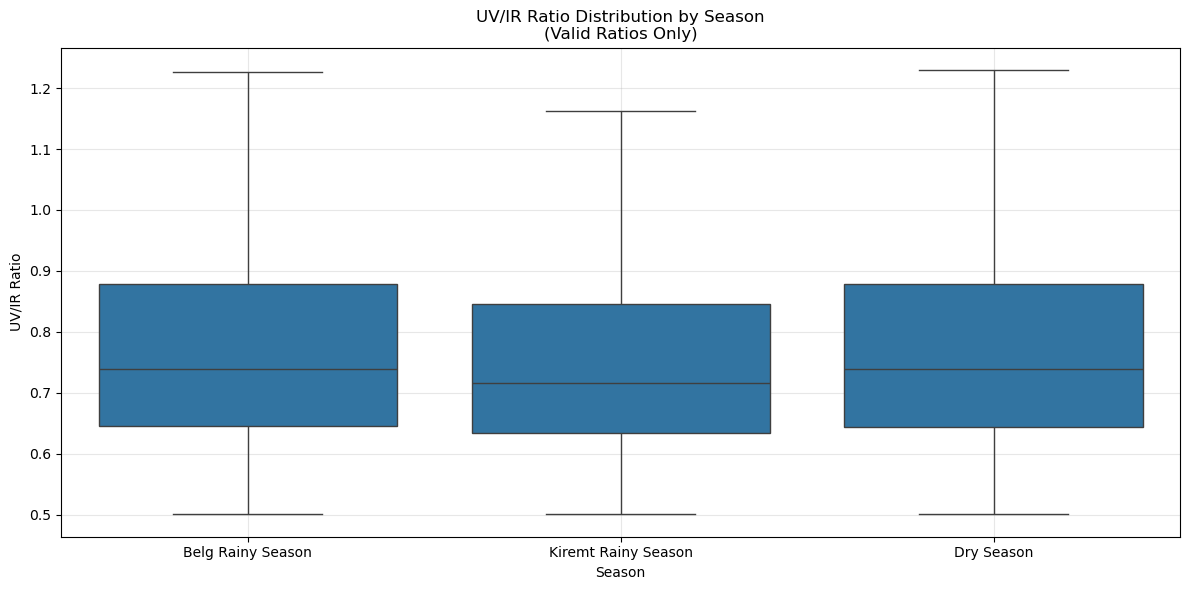

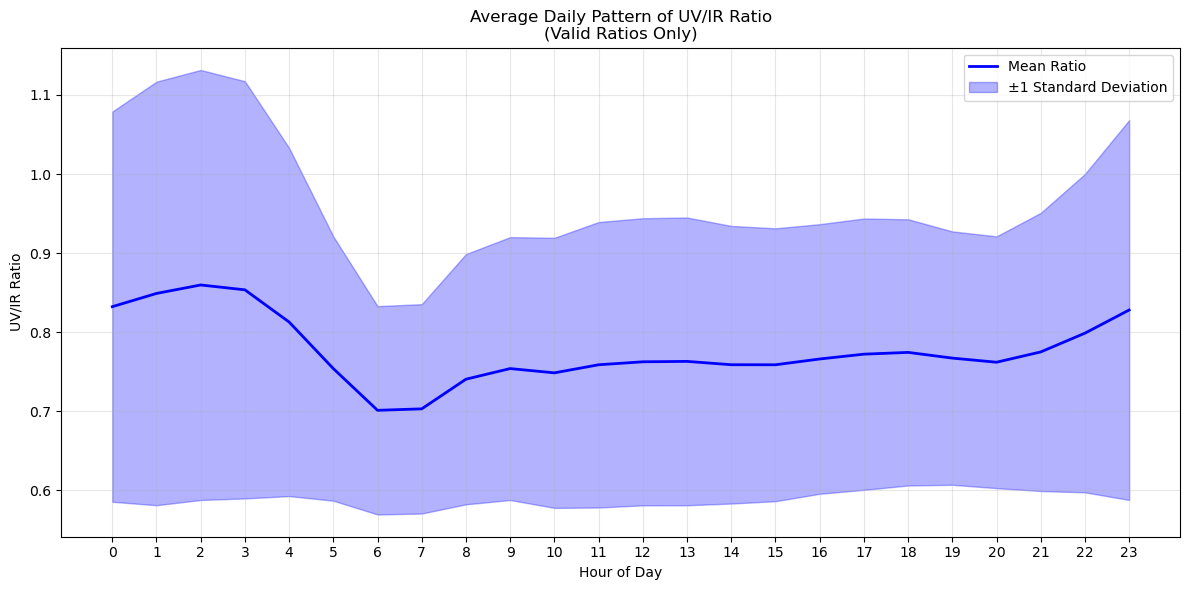


UV/IR Ratio Analysis Summary:
Total measurements: 1095086
Valid ratio measurements: 1022621 (93.4%)

Valid UV/IR Ratio Statistics by Season:
                        count   mean    std  min    25%    50%    75%  max
Ethiopian_Season                                                          
Belg Rainy Season    296162.0  0.784  0.195  0.5  0.646  0.740  0.878  3.0
Dry Season           376699.0  0.786  0.207  0.5  0.644  0.739  0.878  3.0
Kiremt Rainy Season  349760.0  0.763  0.187  0.5  0.633  0.716  0.845  3.0

Belg Rainy Season most common UV/IR ratio range: 0.60-0.70

Kiremt Rainy Season most common UV/IR ratio range: 0.60-0.70

Dry Season most common UV/IR ratio range: 0.60-0.70


In [37]:
# Calculate UV/IR ratio with validation
df['UV_IR_Ratio'] = df['UV BC1'] / df['IR BC1']

# Filter out invalid ratios
valid_ratio_mask = (df['UV_IR_Ratio'] > 0.5) & (df['UV_IR_Ratio'] < 3) & \
                   (df['UV BC1'] > 0) & (df['IR BC1'] > 0)
df_valid = df[valid_ratio_mask].copy()

# Create seasonal boxplot of ratios
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_valid, x='Ethiopian_Season', y='UV_IR_Ratio', 
            showfliers=False)
plt.title('UV/IR Ratio Distribution by Season\n(Valid Ratios Only)')
plt.xlabel('Season')
plt.ylabel('UV/IR Ratio')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(dirs['plots'], 'uv_ir_ratio.png'))
plt.show()

# Improved hourly pattern with shaded area
plt.figure(figsize=(12, 6))
hourly_ratio = df_valid.groupby('Hour')['UV_IR_Ratio'].agg(['mean', 'std'])

# Plot mean line
plt.plot(hourly_ratio.index, hourly_ratio['mean'], 
         color='blue', linewidth=2, label='Mean Ratio')

# Add shaded area for standard deviation
plt.fill_between(hourly_ratio.index,
                 hourly_ratio['mean'] - hourly_ratio['std'],
                 hourly_ratio['mean'] + hourly_ratio['std'],
                 alpha=0.3, color='blue', label='±1 Standard Deviation')

plt.title('Average Daily Pattern of UV/IR Ratio\n(Valid Ratios Only)')
plt.xlabel('Hour of Day')
plt.ylabel('UV/IR Ratio')
plt.grid(True, alpha=0.3)
plt.xticks(range(24))
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(dirs['plots'], 'uv_ir_ratio_daily.png'))
plt.show()

# Print statistics and data quality information
print("\nUV/IR Ratio Analysis Summary:")
print(f"Total measurements: {len(df)}")
print(f"Valid ratio measurements: {len(df_valid)} ({len(df_valid)/len(df)*100:.1f}%)")
print("\nValid UV/IR Ratio Statistics by Season:")
print(df_valid.groupby('Ethiopian_Season')['UV_IR_Ratio'].describe().round(3))

# Calculate and print the modal ratio range for each season
bins = np.linspace(0.5, 3, 26)
for season in df_valid['Ethiopian_Season'].unique():
    season_data = df_valid[df_valid['Ethiopian_Season'] == season]['UV_IR_Ratio']
    hist, bin_edges = np.histogram(season_data, bins=bins)
    modal_bin_index = hist.argmax()
    modal_range = f"{bin_edges[modal_bin_index]:.2f}-{bin_edges[modal_bin_index+1]:.2f}"
    print(f"\n{season} most common UV/IR ratio range: {modal_range}")

## 8.4 Extreme Events Analysis

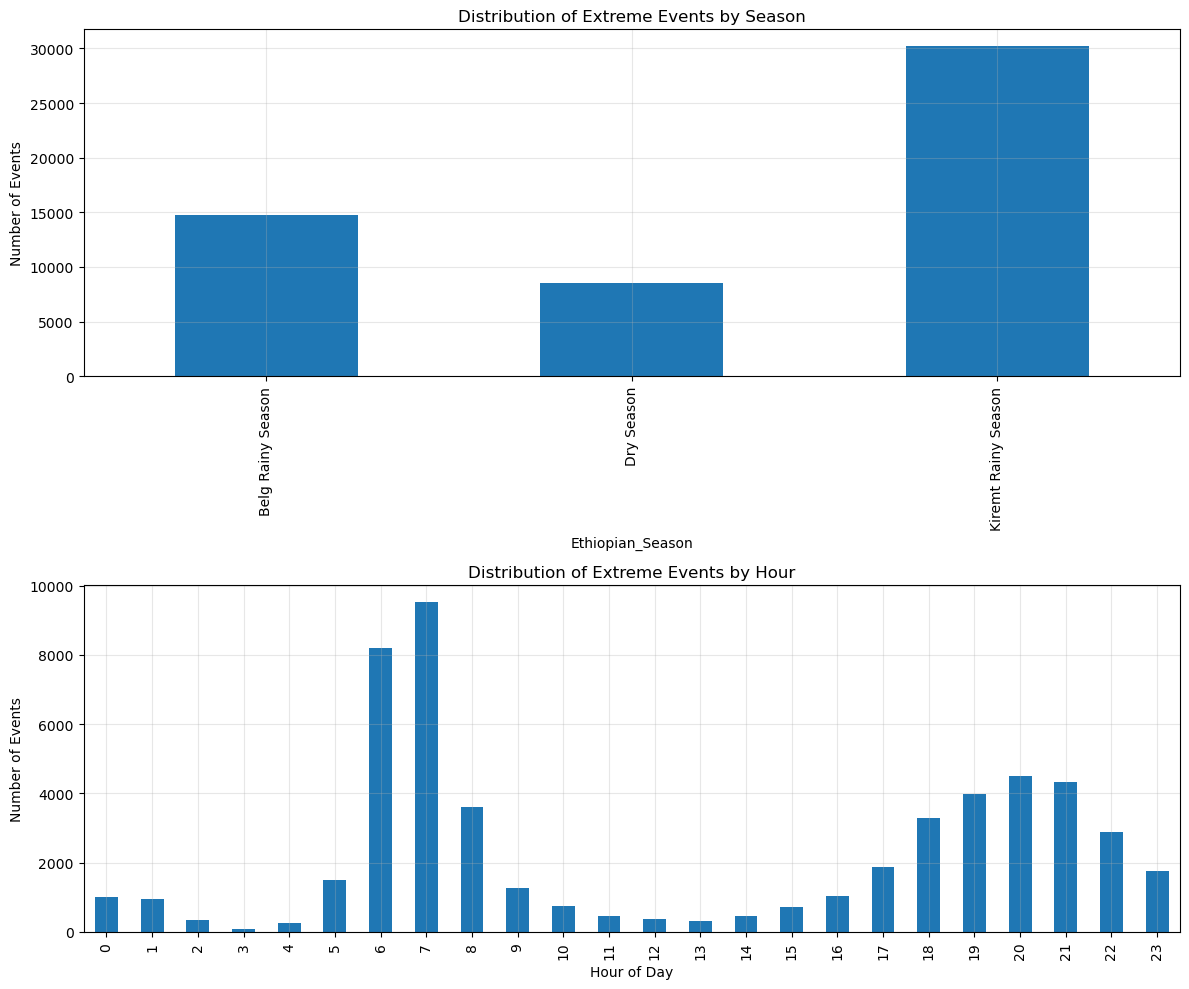


Extreme Events Analysis:
Threshold value (95th percentile): 13.29 µg/m³

Extreme Events by Season:
Ethiopian_Season
Belg Rainy Season      14774
Dry Season              8514
Kiremt Rainy Season    30235
dtype: int64


In [38]:
# Define extreme events (95th percentile)
threshold = df['IR BC1'].quantile(0.95)
extreme_events = df[df['IR BC1'] > threshold].copy()

# Analyze extreme events by season and hour
seasonal_extremes = extreme_events.groupby('Ethiopian_Season').size()
hourly_extremes = extreme_events.groupby('Hour').size()

# Create subplots for extreme events analysis
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Plot 1: Seasonal distribution of extreme events
seasonal_extremes.plot(kind='bar', ax=ax1)
ax1.set_title('Distribution of Extreme Events by Season')
ax1.set_ylabel('Number of Events')
ax1.grid(True, alpha=0.3)

# Plot 2: Hourly distribution of extreme events
hourly_extremes.plot(kind='bar', ax=ax2)
ax2.set_title('Distribution of Extreme Events by Hour')
ax2.set_xlabel('Hour of Day')
ax2.set_ylabel('Number of Events')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(dirs['plots'], 'extreme_events.png'))
plt.show()

print("\nExtreme Events Analysis:")
print(f"Threshold value (95th percentile): {threshold:.2f} µg/m³")
print("\nExtreme Events by Season:")
print(seasonal_extremes)

## 8.5 Persistence Analysis

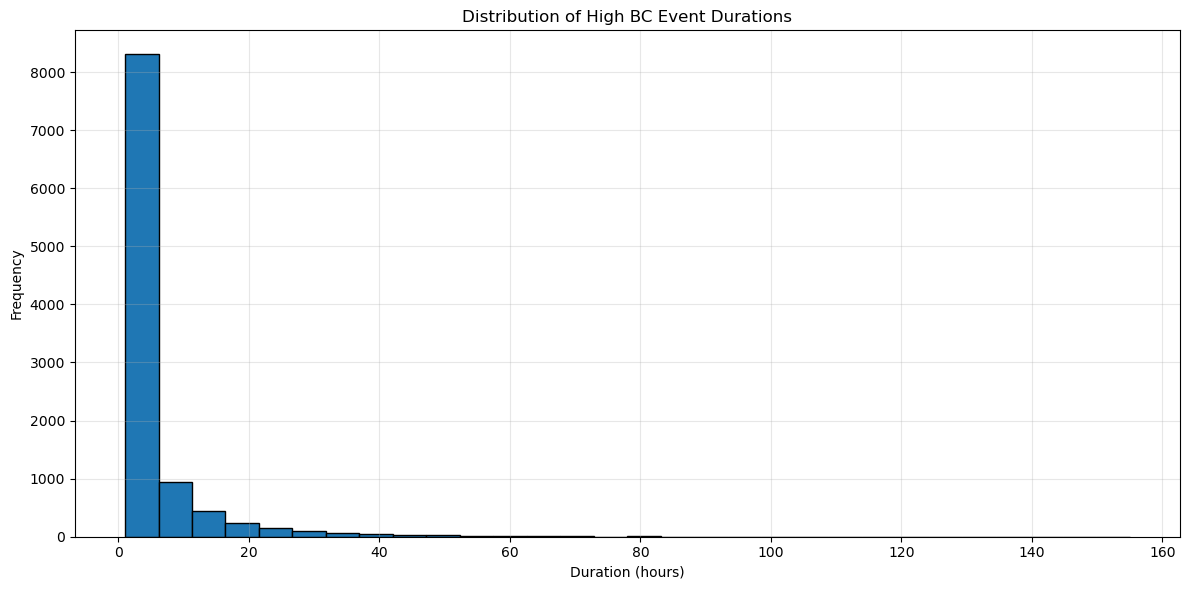


Persistence Analysis:

Event Duration Statistics (hours):
count    10406.00
mean         5.14
std          8.63
min          1.00
25%          1.00
50%          2.00
75%          5.00
max        155.00
dtype: float64


In [39]:
# Calculate event durations
df['High_BC_Event'] = df['IR BC1'] > threshold
df['Event_Duration'] = (df['High_BC_Event'] != df['High_BC_Event'].shift()).cumsum()

# Analyze event durations
event_durations = df[df['High_BC_Event']].groupby('Event_Duration').size()
event_lengths = event_durations.value_counts().sort_index()

# Plot event duration distribution
plt.figure(figsize=(12, 6))
plt.hist(event_durations, bins=30, edgecolor='black')
plt.title('Distribution of High BC Event Durations')
plt.xlabel('Duration (hours)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(dirs['plots'], 'event_durations.png'))
plt.show()

print("\nPersistence Analysis:")
print("\nEvent Duration Statistics (hours):")
print(event_durations.describe().round(2))

# 9. Precipitation and Meteorological Analysis


Precipitation Summary During BC Measurement Period:
Total precipitation: 3428.4 mm
Average daily precipitation: 3.98 mm
Maximum daily precipitation: 32.5 mm
Days with precipitation: 524


/var/folders/q8/4q55gl35679357bs417130z40000gn/T/ipykernel_10620/3646492507.py:43: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_seasons = seasons.resample('H').ffill()



Data Availability Ranges:
BC data: 2022-04-12 12:46:01+03:00 to 2024-08-20 12:01:00+03:00
Meteorological data: 2016-01-01 03:00:00+03:00 to 2024-11-30 03:00:00+03:00

Analysis period: 2022-04-12 12:46:01+03:00 to 2024-08-20 12:01:00+03:00

Seasonal Statistics:

Dry Season:
Static Definition:
  N = 403479
  Mean = 3.34
  Median = 2.46
  Std = 3.06

Dynamic Definition:
  N = 293609
  Mean = 3.51
  Median = 2.55
  Std = 3.21

Belg Rainy Season:
Static Definition:
  N = 315530
  Mean = 4.47
  Median = 3.23
  Std = 3.87

Dynamic Definition:
  N = 103352
  Mean = 3.78
  Median = 2.64
  Std = 3.55

Kiremt Rainy Season:
Static Definition:
  N = 376077
  Mean = 5.80
  Median = 4.48
  Std = 4.45

Dynamic Definition:
  N = 698125
  Mean = 5.03
  Median = 3.70
  Std = 4.18

Precipitation Statistics by Season:
                     mean       std  count
precip_category                           
No Rain          4.594789  3.985063   7523
Light            4.565173  3.594660   1367
Moderate         4

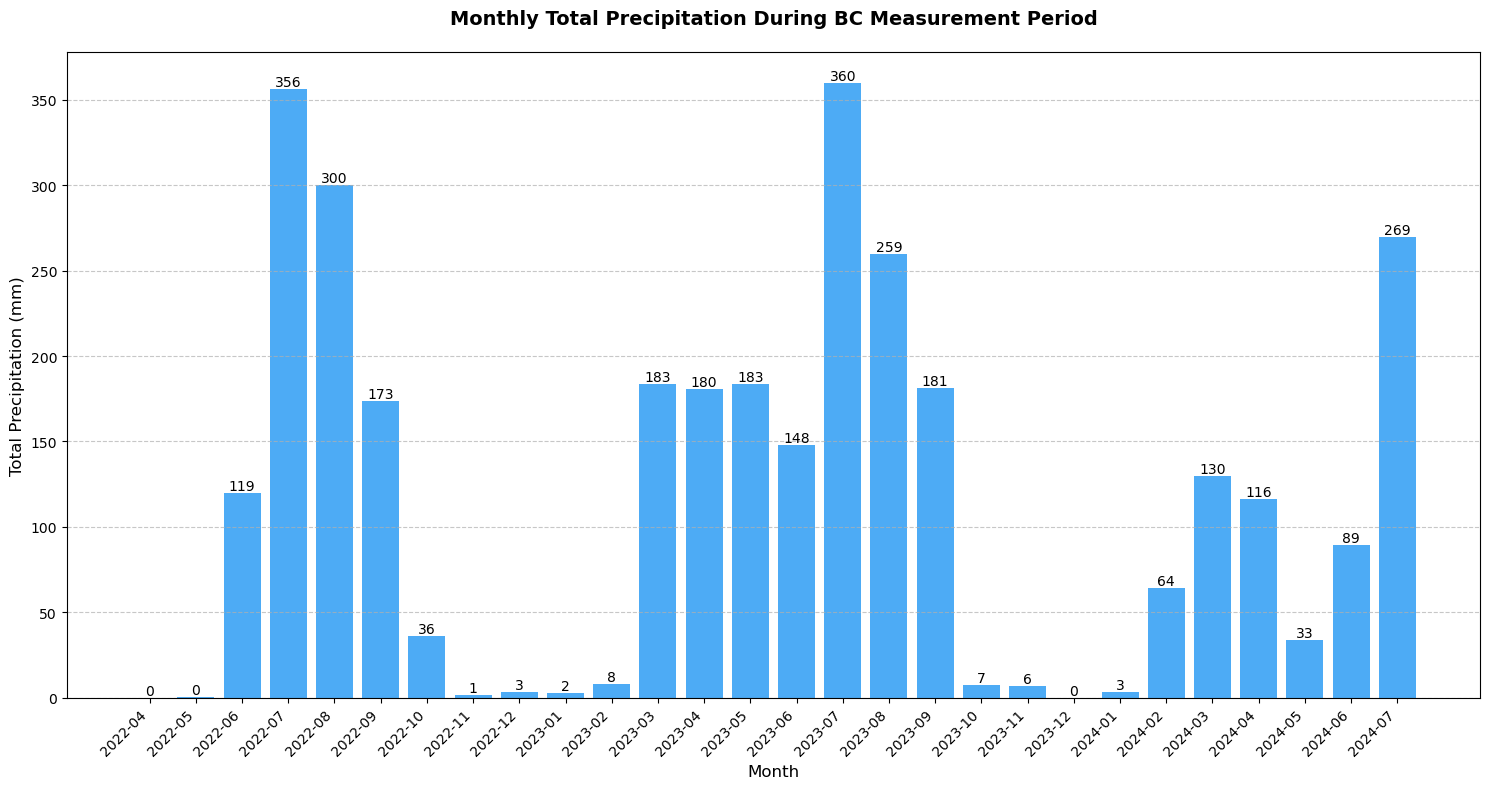

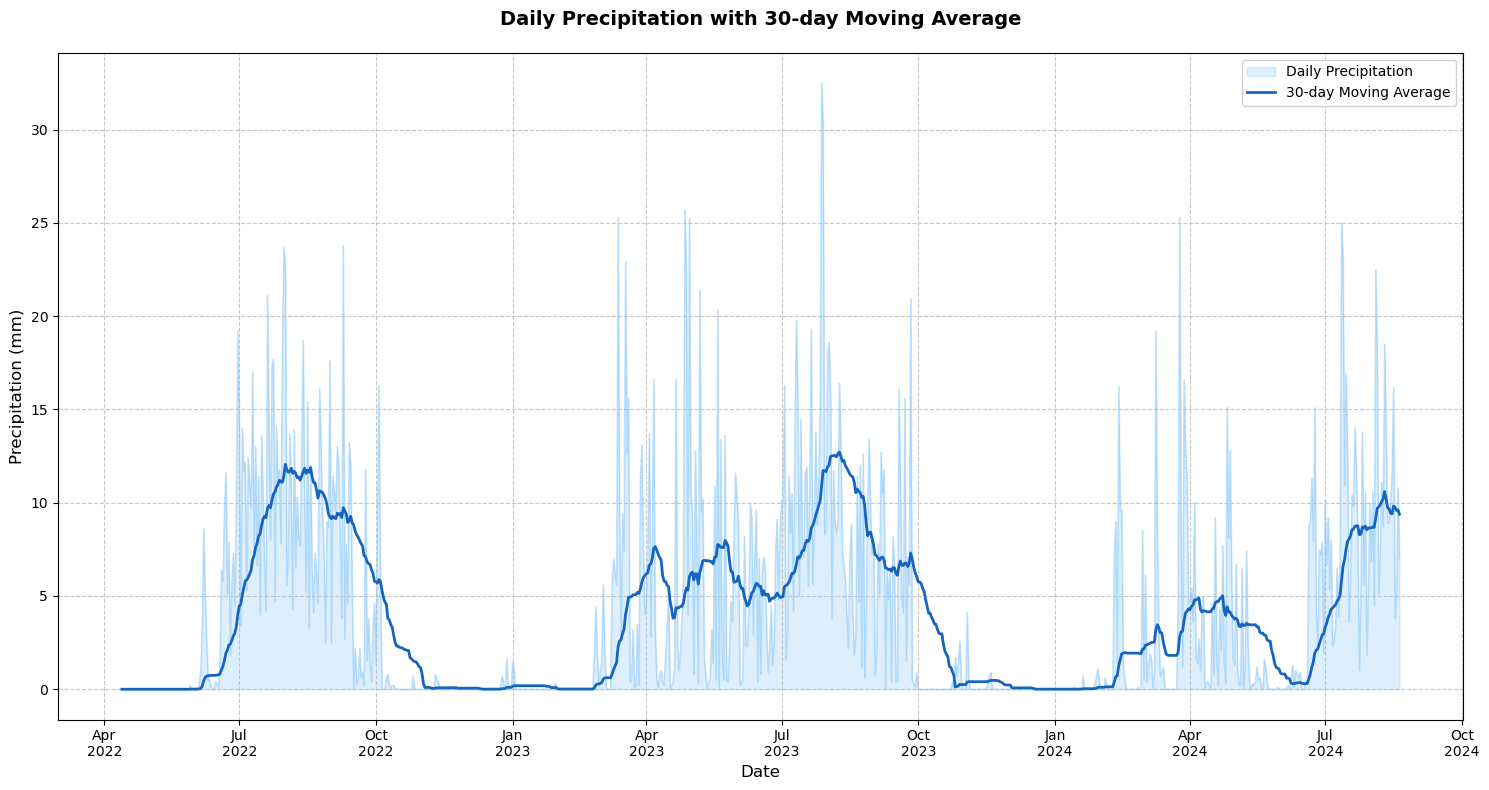

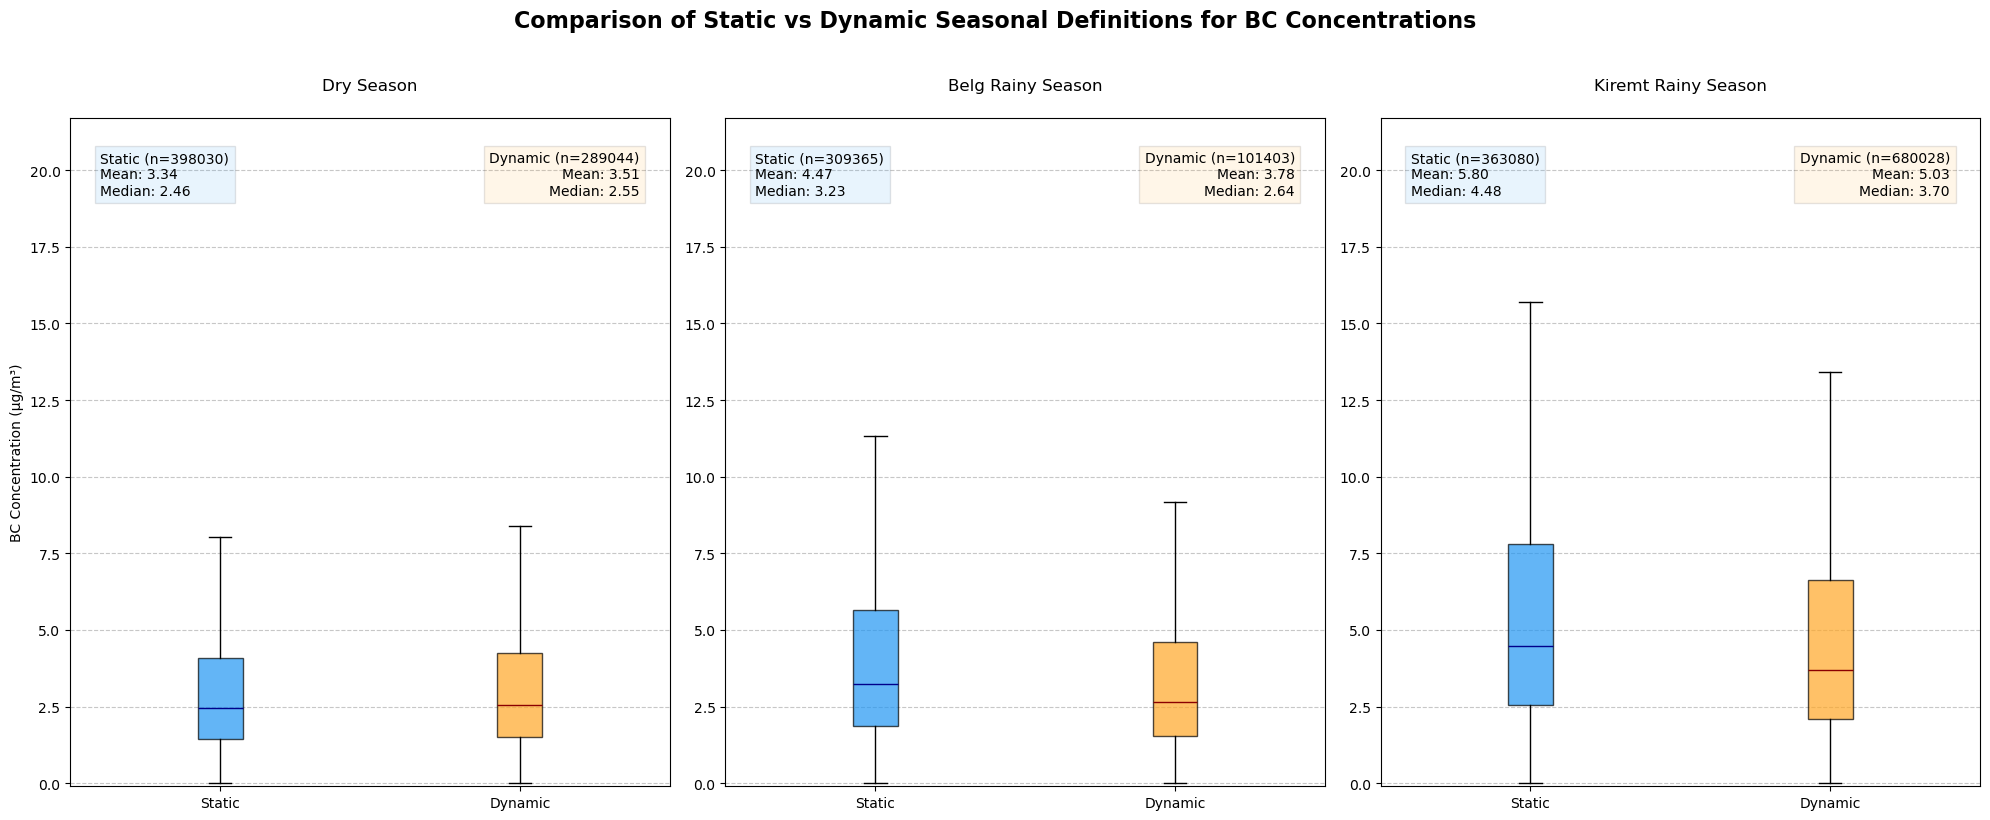

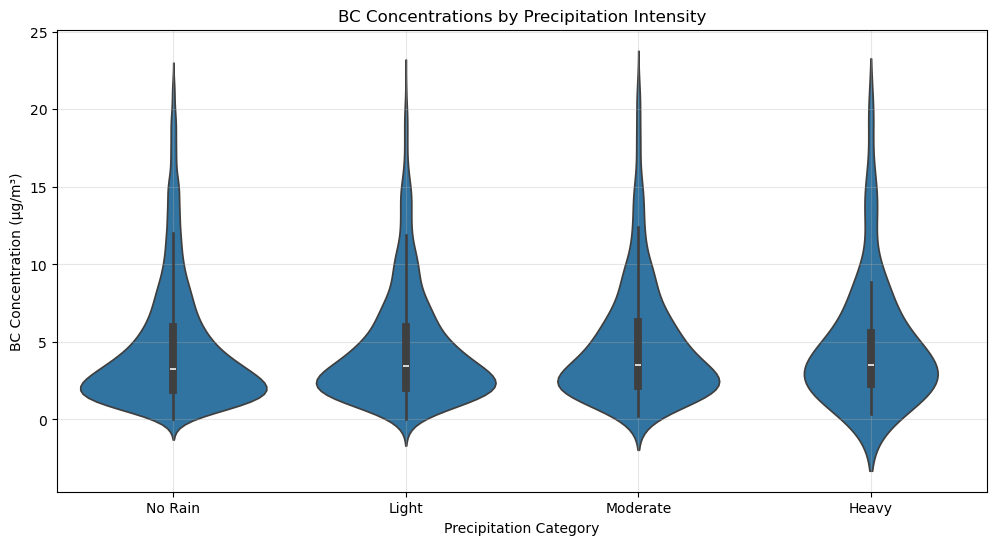

In [40]:
# 9. Precipitation and Meteorological Analysis

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from matplotlib.dates import MonthLocator, DateFormatter  # Add these imports

def load_meteorological_data(filepath):
    """
    Load and process meteorological data
    """
    meteo_df = pd.read_csv(filepath, parse_dates=['timestamp'])
    meteo_df.set_index('timestamp', inplace=True)
    
    # Convert to local timezone to match BC data
    meteo_df.index = meteo_df.index.tz_localize('UTC').tz_convert('Africa/Addis_Ababa')
    
    # Calculate daily precipitation
    daily_precip = meteo_df['precipitation_mm'].resample('D').sum()
    
    # Calculate monthly precipitation (using ME instead of M)
    monthly_precip = meteo_df['precipitation_mm'].resample('ME').sum()
    
    return meteo_df, daily_precip, monthly_precip

def define_dynamic_seasons(daily_precip, threshold_mm=1.0):
    """
    Define seasons dynamically based on precipitation patterns
    threshold_mm: minimum daily precipitation to consider as a rainy day
    """
    # Calculate 30-day rolling sum of precipitation
    rolling_precip = daily_precip.rolling(window=30, min_periods=1).sum()
    
    # Define seasons based on precipitation intensity
    seasons = pd.Series(index=daily_precip.index, dtype='str')
    seasons[rolling_precip <= threshold_mm*5] = 'Dry Season'
    seasons[(rolling_precip > threshold_mm*5) & (rolling_precip <= threshold_mm*15)] = 'Belg Rainy Season'
    seasons[rolling_precip > threshold_mm*15] = 'Kiremt Rainy Season'
    
    # Resample to hourly frequency using forward fill
    hourly_seasons = seasons.resample('H').ffill()
    
    return hourly_seasons

def analyze_precipitation_patterns(bc_df, daily_precip, monthly_precip):
    """
    Create separate visualizations for monthly and daily precipitation patterns
    """
    # Get BC data date range
    start_date = bc_df.index.min()
    end_date = bc_df.index.max()
    
    # Filter precipitation data to BC period
    daily_precip_filtered = daily_precip[start_date:end_date]
    monthly_precip_filtered = monthly_precip[start_date:end_date]
    
    # Create monthly precipitation figure
    fig_monthly = plt.figure(figsize=(15, 8))
    ax_monthly = fig_monthly.add_subplot(111)
    
    # Plot monthly bars with custom colors and style
    monthly_bars = ax_monthly.bar(range(len(monthly_precip_filtered)), 
                                monthly_precip_filtered.values,
                                color='#2196F3', alpha=0.8)
    
    # Format monthly plot
    ax_monthly.grid(True, linestyle='--', alpha=0.7, axis='y', zorder=0)
    ax_monthly.set_title('Monthly Total Precipitation During BC Measurement Period',
                        pad=20, fontsize=14, fontweight='bold')
    ax_monthly.set_xlabel('Month', fontsize=12)
    ax_monthly.set_ylabel('Total Precipitation (mm)', fontsize=12)
    
    # Format x-axis for monthly plot
    ax_monthly.set_xticks(range(len(monthly_precip_filtered)))
    ax_monthly.set_xticklabels([d.strftime('%Y-%m') for d in monthly_precip_filtered.index],
                              rotation=45, ha='right')
    
    # Add value labels on bars
    for bar in monthly_bars:
        height = bar.get_height()
        ax_monthly.text(bar.get_x() + bar.get_width()/2., height,
                       f'{int(height)}',
                       ha='center', va='bottom')
    
    plt.tight_layout()
    
    # Create daily precipitation figure
    fig_daily = plt.figure(figsize=(15, 8))
    ax_daily = fig_daily.add_subplot(111)
    
    # Plot daily precipitation
    ax_daily.fill_between(daily_precip_filtered.index, 
                         daily_precip_filtered.values,
                         color='#90CAF9', alpha=0.3, label='Daily Precipitation')
    ax_daily.plot(daily_precip_filtered.index, 
                 daily_precip_filtered.values,
                 color='#90CAF9', alpha=0.5, linewidth=1)
    
    # Add rolling average
    rolling_avg = daily_precip_filtered.rolling(window=30, min_periods=1).mean()
    ax_daily.plot(rolling_avg.index, rolling_avg.values,
                 color='#1565C0', linewidth=2,
                 label='30-day Moving Average')
    
    # Format daily plot
    ax_daily.grid(True, linestyle='--', alpha=0.7)
    ax_daily.set_title('Daily Precipitation with 30-day Moving Average',
                      pad=20, fontsize=14, fontweight='bold')
    ax_daily.set_xlabel('Date', fontsize=12)
    ax_daily.set_ylabel('Precipitation (mm)', fontsize=12)
    
    # Format dates on x-axis
    ax_daily.xaxis.set_major_locator(MonthLocator(interval=3))
    ax_daily.xaxis.set_major_formatter(DateFormatter('%b\n%Y'))
    ax_daily.legend(loc='upper right', frameon=True, framealpha=0.9)
    
    plt.tight_layout()
    
    return fig_monthly, fig_daily, daily_precip_filtered, monthly_precip_filtered

def compare_seasonal_definitions(bc_filtered):
    """
    Create a combined visualization comparing static and dynamic seasonal definitions
    """
    # Create figure with three subplots
    fig, axes = plt.subplots(1, 3, figsize=(20, 8))
    fig.suptitle('Comparison of Static vs Dynamic Seasonal Definitions for BC Concentrations', 
                fontsize=16, fontweight='bold', y=1.02)
    
    seasons = ['Dry Season', 'Belg Rainy Season', 'Kiremt Rainy Season']
    
    # Define colors for static and dynamic
    static_color = '#2196F3'  # Blue
    dynamic_color = '#FFA726'  # Orange
    
    # First pass to determine reasonable y-axis limits
    all_data = []
    for season in seasons:
        static_data = bc_filtered[bc_filtered['Ethiopian_Season'] == season]['IR BC1'].dropna()
        dynamic_data = bc_filtered[bc_filtered['Dynamic_Season'] == season]['IR BC1'].dropna()
        all_data.extend([static_data, dynamic_data])
    
    # Calculate global limits using 95th percentile instead of outliers
    y_min = -0.1  # Force minimum to 0
    y_max = np.percentile([x for data in all_data for x in data], 100)  # Use 95th percentile
    
    for idx, season in enumerate(seasons):
        # Create paired boxplots for each season
        static_data = bc_filtered[bc_filtered['Ethiopian_Season'] == season]['IR BC1'].dropna()
        dynamic_data = bc_filtered[bc_filtered['Dynamic_Season'] == season]['IR BC1'].dropna()
        
        # Create boxplots
        bp1 = axes[idx].boxplot([static_data, dynamic_data], 
                              positions=[1, 2],
                              tick_labels=['Static', 'Dynamic'],
                              patch_artist=True,
                              showfliers=False)  # Hide outliers
        
        # Color the boxes differently for static and dynamic
        bp1['boxes'][0].set(facecolor=static_color, alpha=0.7)
        bp1['boxes'][1].set(facecolor=dynamic_color, alpha=0.7)
        
        # Color the median lines
        bp1['medians'][0].set(color='darkblue')
        bp1['medians'][1].set(color='darkred')
        
        # Format subplot
        axes[idx].set_title(f'{season}', fontsize=12, pad=20)
        axes[idx].grid(True, linestyle='--', alpha=0.7, axis='y')
        axes[idx].set_ylabel('BC Concentration (µg/m³)' if idx == 0 else '')
        
        # Set consistent y-axis limits across all subplots
        axes[idx].set_ylim(y_min, y_max)
        
        # Add statistics
        static_stats = f'Static (n={len(static_data)})\nMean: {static_data.mean():.2f}\nMedian: {static_data.median():.2f}'
        dynamic_stats = f'Dynamic (n={len(dynamic_data)})\nMean: {dynamic_data.mean():.2f}\nMedian: {dynamic_data.median():.2f}'
        
        # Add text boxes with statistics
        axes[idx].text(0.05, 0.95, static_stats,
                      transform=axes[idx].transAxes,
                      bbox=dict(facecolor=static_color, alpha=0.1),
                      verticalalignment='top',
                      fontsize=10)
        axes[idx].text(0.95, 0.95, dynamic_stats,
                      transform=axes[idx].transAxes,
                      bbox=dict(facecolor=dynamic_color, alpha=0.1),
                      verticalalignment='top',
                      horizontalalignment='right',
                      fontsize=10)
        
        # Add some padding between subplots
        axes[idx].set_xlim(0.5, 2.5)
    
    plt.tight_layout()
    return fig

def analyze_bc_precipitation_relationship(bc_df, meteo_df):
    """
    Analyze relationship between BC concentrations and precipitation
    """
    # Print data availability ranges before merging
    print("\nData Availability Ranges:")
    print(f"BC data: {bc_df.index.min()} to {bc_df.index.max()}")
    print(f"Meteorological data: {meteo_df.index.min()} to {meteo_df.index.max()}")
    
    # Find overlapping period
    start_date = max(bc_df.index.min(), meteo_df.index.min())
    end_date = min(bc_df.index.max(), meteo_df.index.max())
    print(f"\nAnalysis period: {start_date} to {end_date}")
    
    # Filter both datasets to overlapping period
    bc_filtered = bc_df[start_date:end_date]['IR BC1']
    meteo_filtered = meteo_df[start_date:end_date]['precipitation_mm']
    
    # Merge BC and meteorological data on hourly basis
    merged_df = pd.merge(bc_filtered, 
                        meteo_filtered,
                        left_index=True, 
                        right_index=True,
                        how='inner')
    
    # Create precipitation categories
    merged_df['precip_category'] = pd.cut(merged_df['precipitation_mm'],
                                        bins=[-np.inf, 0, 1, 5, np.inf],
                                        labels=['No Rain', 'Light', 'Moderate', 'Heavy'])
    
    # Calculate statistics (with observed=True to address warning)
    stats_df = merged_df.groupby('precip_category', observed=True)['IR BC1'].agg(['mean', 'std', 'count'])
    
    # Create violin plot
    plt.figure(figsize=(12, 6))
    sns.violinplot(data=merged_df, x='precip_category', y='IR BC1')
    plt.title('BC Concentrations by Precipitation Intensity')
    plt.xlabel('Precipitation Category')
    plt.ylabel('BC Concentration (µg/m³)')
    plt.grid(True, alpha=0.3)
    
    return merged_df, stats_df

def update_seasonal_analysis(bc_df, dynamic_seasons, meteo_df):
    """
    Update existing seasonal analysis with dynamically defined seasons
    """
    # Find overlapping period
    start_date = max(bc_df.index.min(), meteo_df.index.min())
    end_date = min(bc_df.index.max(), meteo_df.index.max())
    
    # Filter BC data to overlapping period
    bc_filtered = bc_df[start_date:end_date].copy()
    
    # Add dynamic seasons to filtered data
    # First, reindex dynamic_seasons to match BC data exactly
    aligned_seasons = dynamic_seasons.reindex(bc_filtered.index, method='ffill')
    bc_filtered['Dynamic_Season'] = aligned_seasons
    
    return bc_filtered

# Load meteorological data
meteo_path = "/Users/ahmadjalil/Library/CloudStorage/GoogleDrive-ahzs645@gmail.com/My Drive/University/Research/Grad/UC Davis Ann/NASA MAIA/Data/Weather Data/Meteostat/addis_ababa_weather_data_cleaned.csv"
meteo_df, daily_precip, monthly_precip = load_meteorological_data(meteo_path)

# Define dynamic seasons
dynamic_seasons = define_dynamic_seasons(daily_precip)

# Analyze precipitation patterns (separate figures)
fig_monthly, fig_daily, daily_precip_filtered, monthly_precip_filtered = analyze_precipitation_patterns(df, daily_precip, monthly_precip)

# Print summary of precipitation during BC measurement period
print("\nPrecipitation Summary During BC Measurement Period:")
print(f"Total precipitation: {daily_precip_filtered.sum():.1f} mm")
print(f"Average daily precipitation: {daily_precip_filtered.mean():.2f} mm")
print(f"Maximum daily precipitation: {daily_precip_filtered.max():.1f} mm")
print(f"Days with precipitation: {(daily_precip_filtered > 0).sum()}")

# Modify how we call the function
bc_filtered = update_seasonal_analysis(df, dynamic_seasons, meteo_df)  # Just get the one return value

# Now that bc_filtered exists, we can use it in other functions
seasonal_comparison_fig = compare_seasonal_definitions(bc_filtered)

# Analyze BC-precipitation relationship
merged_df, stats_df = analyze_bc_precipitation_relationship(df, meteo_df)

# Display additional statistics
print("\nSeasonal Statistics:")
for season in ['Dry Season', 'Belg Rainy Season', 'Kiremt Rainy Season']:
    print(f"\n{season}:")
    print("Static Definition:")
    static_data = bc_filtered[bc_filtered['Ethiopian_Season'] == season]['IR BC1']
    print(f"  N = {len(static_data)}")
    print(f"  Mean = {static_data.mean():.2f}")
    print(f"  Median = {static_data.median():.2f}")
    print(f"  Std = {static_data.std():.2f}")
    
    print("\nDynamic Definition:")
    dynamic_data = bc_filtered[bc_filtered['Dynamic_Season'] == season]['IR BC1']
    print(f"  N = {len(dynamic_data)}")
    print(f"  Mean = {dynamic_data.mean():.2f}")
    print(f"  Median = {dynamic_data.median():.2f}")
    print(f"  Std = {dynamic_data.std():.2f}")

# Display results
print("\nPrecipitation Statistics by Season:")
print(stats_df)

# Display overall statistics for the analysis period
print("\nAnalysis Period Summary:")
merged_stats = merged_df.groupby('precip_category', observed=True).agg({
    'IR BC1': ['count', 'mean', 'std'],
    'precipitation_mm': ['mean', 'max']
}).round(3)
print(merged_stats)

# Calculate percentage of time in each category
total_hours = len(merged_df)
category_percentages = (merged_df.groupby('precip_category', observed=True).size() / total_hours * 100).round(2)
print("\nPercentage of time in each precipitation category:")
print(category_percentages)

# Debug: Check data availability
print("\nDebug: Data Overview")
for season in ['Dry Season', 'Belg Rainy Season', 'Kiremt Rainy Season']:
    print(f"\n{season}:")
    static_count = len(bc_filtered[bc_filtered['Ethiopian_Season'] == season])
    dynamic_count = len(bc_filtered[bc_filtered['Dynamic_Season'] == season])
    print(f"Static count: {static_count}")
    print(f"Dynamic count: {dynamic_count}")
    print(f"Static BC range: {bc_filtered[bc_filtered['Ethiopian_Season'] == season]['IR BC1'].describe()}")
    print(f"Dynamic BC range: {bc_filtered[bc_filtered['Dynamic_Season'] == season]['IR BC1'].describe()}")


# 10. Temperature Analysis and Seasonal Correlations
 
## 10.1 Temperature Data Integration and Visualization

Analyzing temperature patterns...

Analyzing temperature-BC correlations...

Analyzing temperature thresholds...


/var/folders/q8/4q55gl35679357bs417130z40000gn/T/ipykernel_10620/736384105.py:151: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temp_stats = merged_df.groupby('temp_category')['IR BC1'].agg(['mean', 'std', 'count'])



Temperature Analysis Summary:

Temperature Statistics:
count    71639.00
mean        17.18
std          3.75
min          1.00
25%         14.30
50%         16.80
75%         20.00
max         36.00
Name: temperature_c, dtype: float64

Correlation Summary (Static Seasons):
Dry Season:
  Correlation coefficient: -0.169
  P-value: 2.65e-18
Belg Rainy Season:
  Correlation coefficient: -0.188
  P-value: 6.57e-28
Kiremt Rainy Season:
  Correlation coefficient: -0.077
  P-value: 9.59e-07

BC Concentration by Temperature Range:
                mean    std  count
temp_category                     
< 10°C         5.914  4.727    162
10-15°C        4.616  4.341   2958
15-20°C        5.004  4.031   4615
20-25°C        3.494  2.458   2039
> 25°C         3.525  2.401    175


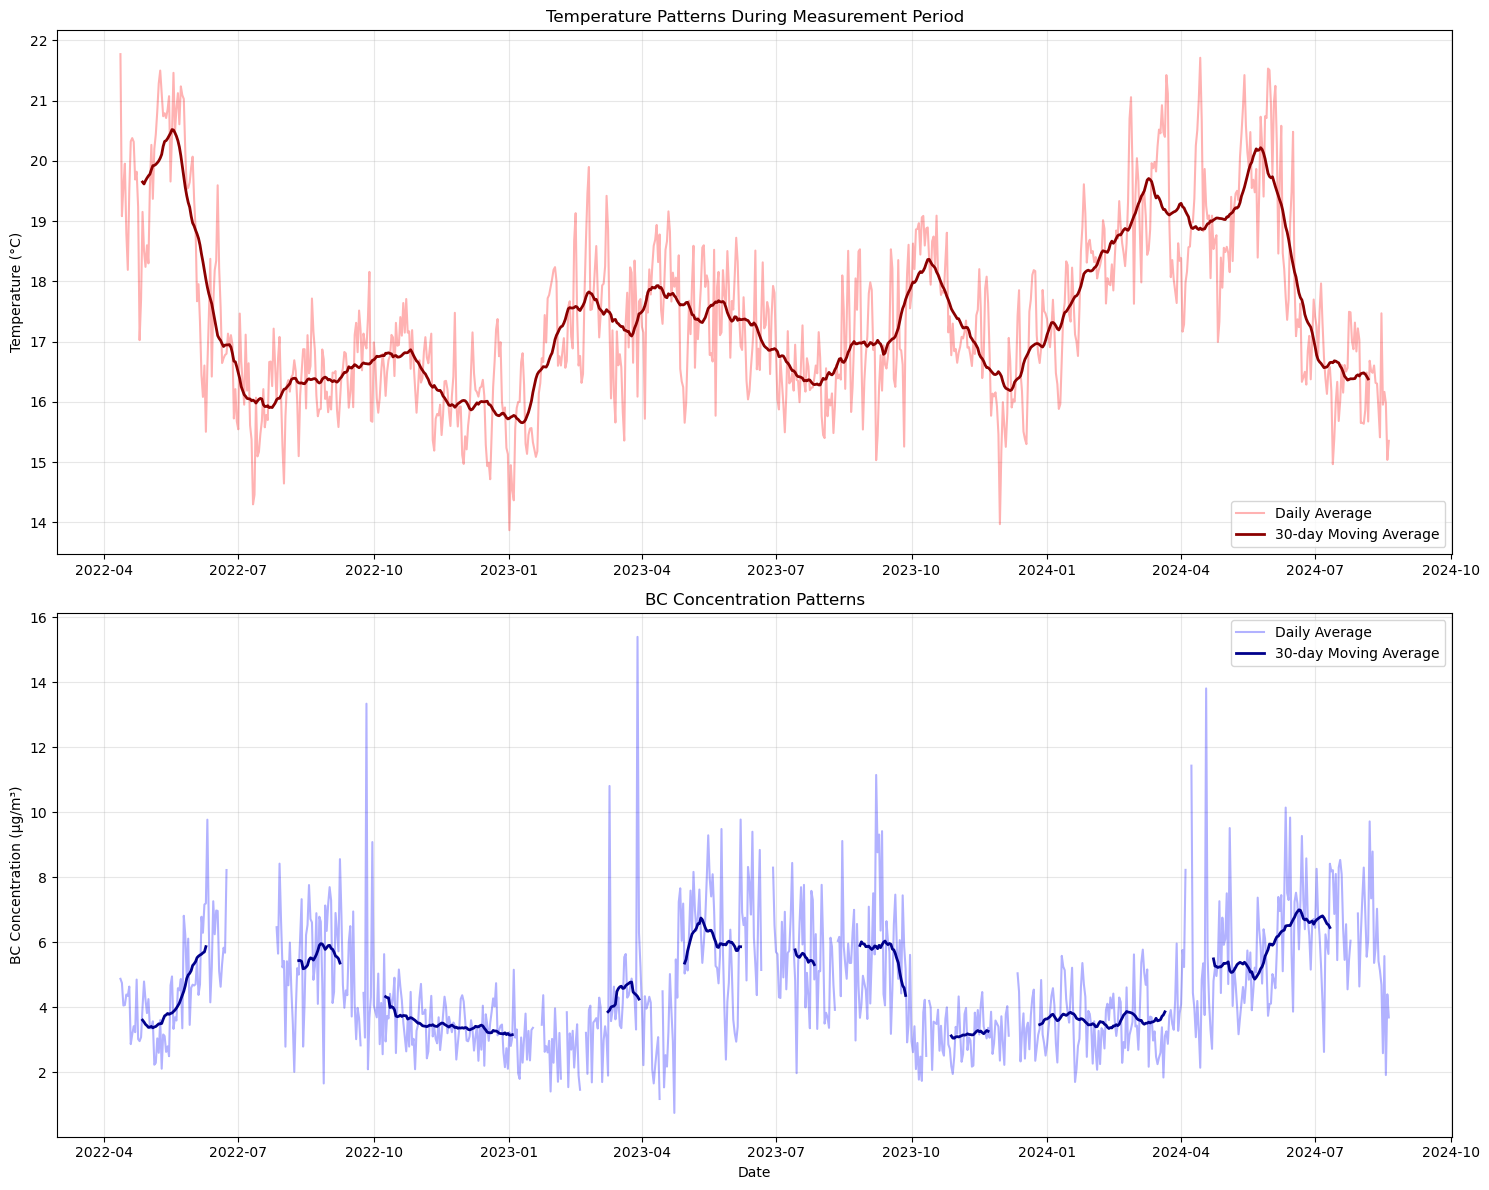

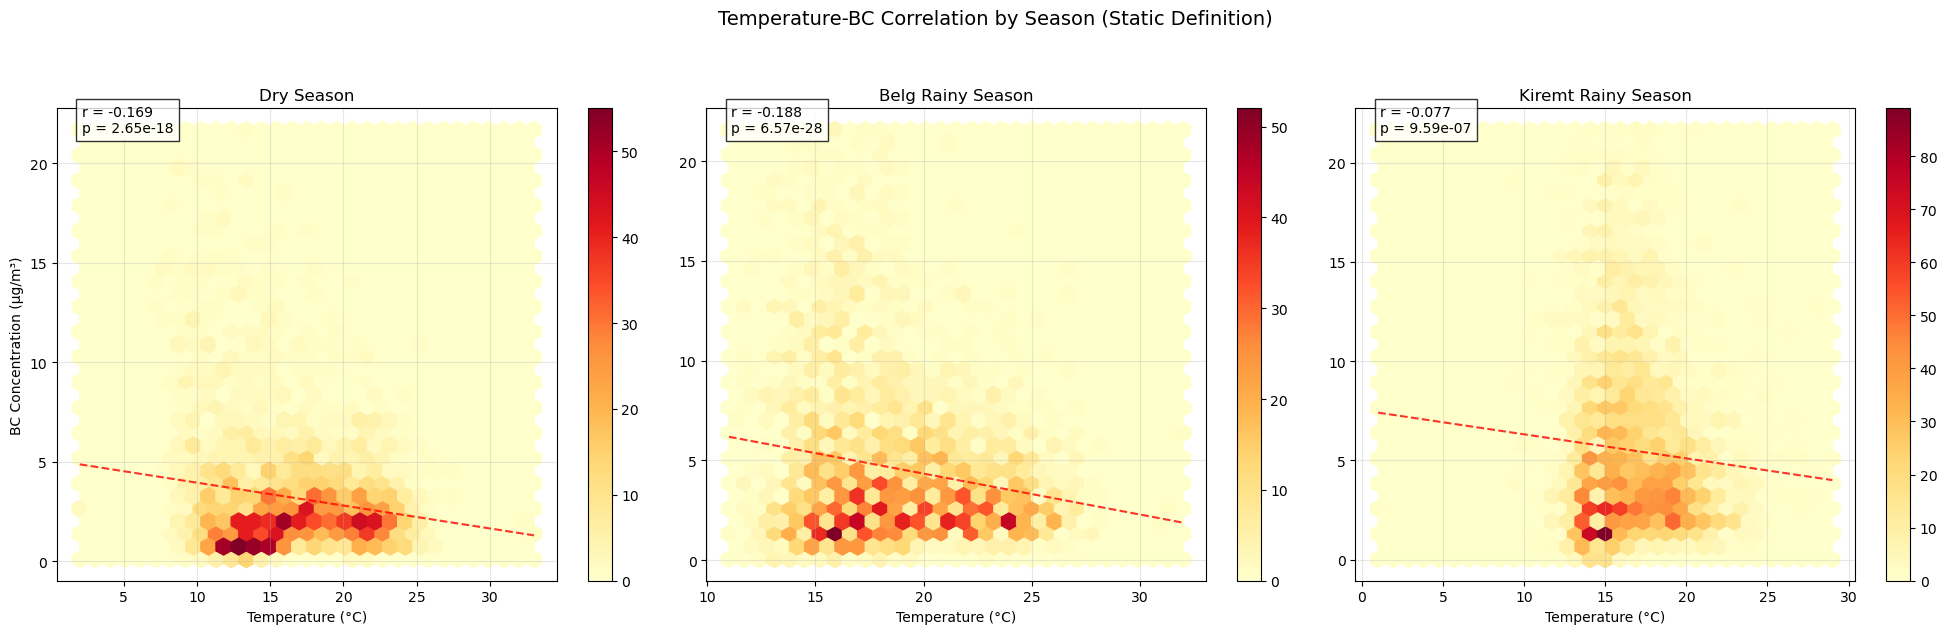

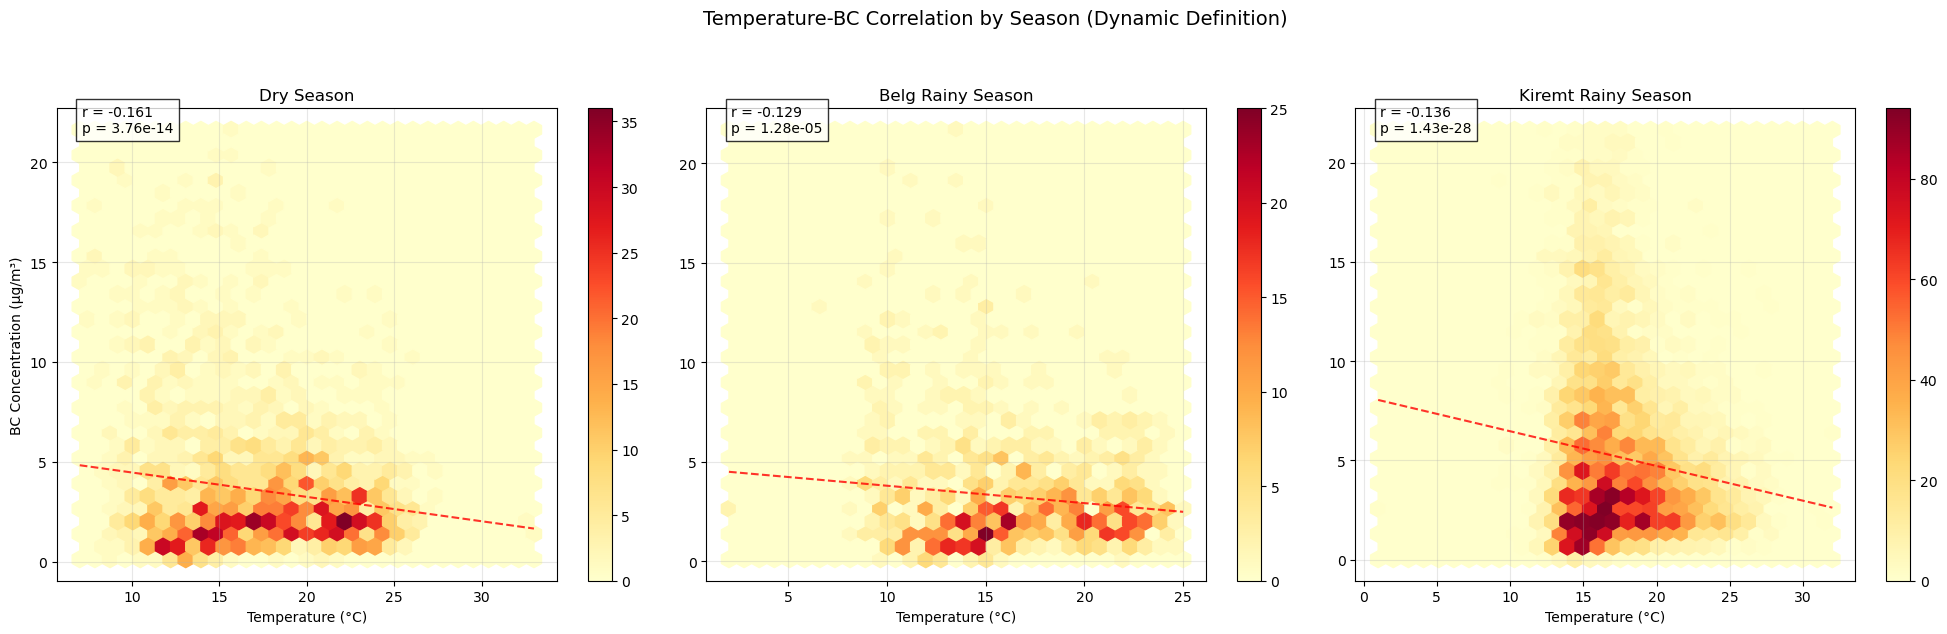

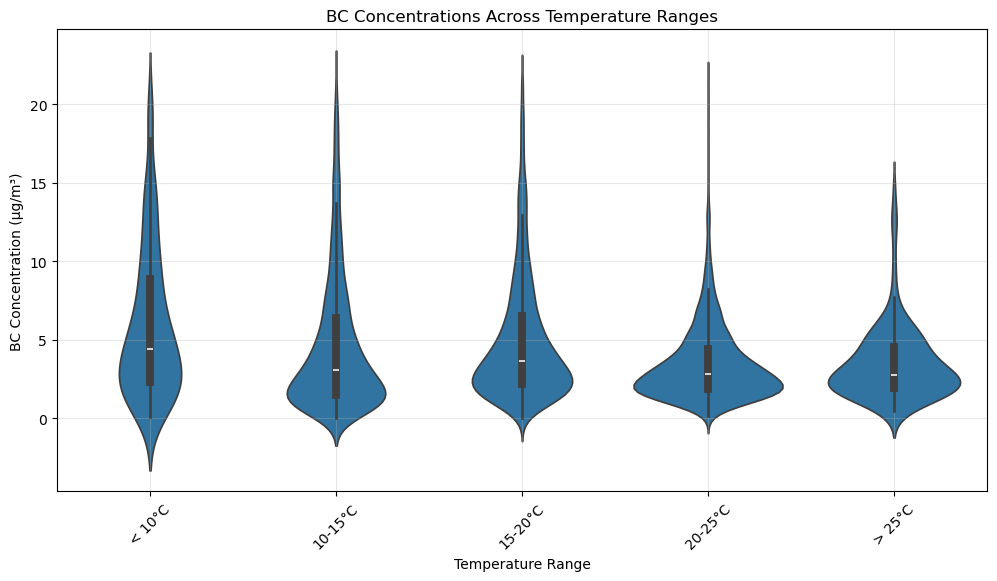

In [45]:
def analyze_temperature_patterns(bc_df, meteo_df):
    """
    Analyze and visualize temperature patterns in relation to BC concentrations
    """
    # Find overlapping period
    start_date = max(bc_df.index.min(), meteo_df.index.min())
    end_date = min(bc_df.index.max(), meteo_df.index.max())
    
    # Filter data to overlapping period
    bc_filtered = bc_df[start_date:end_date]['IR BC1']
    temp_filtered = meteo_df[start_date:end_date]['temperature_c']
    
    # Calculate daily averages
    daily_temp = temp_filtered.resample('D').mean()
    daily_bc = bc_filtered.resample('D').mean()
    
    # Calculate 30-day rolling averages
    temp_rolling = daily_temp.rolling(window=30, center=True).mean()
    bc_rolling = daily_bc.rolling(window=30, center=True).mean()
    
    # Create figure
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))
    
    # Temperature plot
    ax1.plot(daily_temp.index, daily_temp, alpha=0.3, color='red', label='Daily Average')
    ax1.plot(temp_rolling.index, temp_rolling, color='darkred', linewidth=2, 
             label='30-day Moving Average')
    ax1.set_title('Temperature Patterns During Measurement Period')
    ax1.set_ylabel('Temperature (°C)')
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    
    # BC concentration plot
    ax2.plot(daily_bc.index, daily_bc, alpha=0.3, color='blue', label='Daily Average')
    ax2.plot(bc_rolling.index, bc_rolling, color='darkblue', linewidth=2, 
             label='30-day Moving Average')
    ax2.set_title('BC Concentration Patterns')
    ax2.set_xlabel('Date')
    ax2.set_ylabel('BC Concentration (µg/m³)')
    ax2.grid(True, alpha=0.3)
    ax2.legend()
    
    plt.tight_layout()
    return daily_temp, daily_bc, temp_rolling, bc_rolling

def analyze_temp_bc_correlation(bc_df, meteo_df, season_def='static'):
    """
    Analyze correlation between temperature and BC concentrations
    
    Parameters:
    season_def: 'static' or 'dynamic' for season definition method
    """
    # Merge BC and temperature data
    merged_df = pd.merge(
        bc_df[['IR BC1', 'Ethiopian_Season', 'Dynamic_Season']],
        meteo_df['temperature_c'],
        left_index=True,
        right_index=True,
        how='inner'
    )
    
    # Remove NaN and infinite values
    merged_df = merged_df.replace([np.inf, -np.inf], np.nan).dropna()
    
    season_col = 'Ethiopian_Season' if season_def == 'static' else 'Dynamic_Season'
    seasons = ['Dry Season', 'Belg Rainy Season', 'Kiremt Rainy Season']
    
    # Create correlation plots
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    fig.suptitle(f'Temperature-BC Correlation by Season ({season_def.title()} Definition)', 
                 fontsize=14, y=1.05)
    
    correlations = {}
    for idx, season in enumerate(seasons):
        # Get data for current season
        season_data = merged_df[merged_df[season_col] == season]
        
        # Calculate correlation (remove NaN and infinite values first)
        temp_data = season_data['temperature_c'].values
        bc_data = season_data['IR BC1'].values
        valid_mask = ~np.isnan(temp_data) & ~np.isnan(bc_data) & ~np.isinf(temp_data) & ~np.isinf(bc_data)
        
        if np.sum(valid_mask) > 1:  # Need at least 2 points for correlation
            corr = stats.pearsonr(temp_data[valid_mask], bc_data[valid_mask])
        else:
            corr = (np.nan, np.nan)
        # Calculate correlation
        corr = stats.pearsonr(season_data['temperature_c'], 
                             season_data['IR BC1'])
        correlations[season] = corr
        
        # Create hexbin plot
        hb = axes[idx].hexbin(season_data['temperature_c'], 
                             season_data['IR BC1'],
                             gridsize=30,
                             cmap='YlOrRd')
        
        # Add trend line
        z = np.polyfit(season_data['temperature_c'], 
                      season_data['IR BC1'], 1)
        p = np.poly1d(z)
        x_range = np.linspace(season_data['temperature_c'].min(), 
                            season_data['temperature_c'].max(), 100)
        axes[idx].plot(x_range, p(x_range), 'r--', alpha=0.8)
        
        # Add correlation coefficient
        axes[idx].text(0.05, 0.95, f'r = {corr[0]:.3f}\np = {corr[1]:.2e}',
                      transform=axes[idx].transAxes,
                      bbox=dict(facecolor='white', alpha=0.8))
        
        axes[idx].set_title(season)
        axes[idx].set_xlabel('Temperature (°C)')
        axes[idx].set_ylabel('BC Concentration (µg/m³)' if idx == 0 else '')
        axes[idx].grid(True, alpha=0.3)
        
        fig.colorbar(hb, ax=axes[idx])
    
    plt.tight_layout()
    return correlations

def analyze_temperature_thresholds(bc_df, meteo_df):
    """
    Analyze BC concentrations across different temperature ranges
    """
    # Merge data
    merged_df = pd.merge(
        bc_df['IR BC1'],
        meteo_df['temperature_c'],
        left_index=True,
        right_index=True,
        how='inner'
    )
    
    # Create temperature categories
    temp_bins = [-np.inf, 10, 15, 20, 25, np.inf]
    temp_labels = ['< 10°C', '10-15°C', '15-20°C', '20-25°C', '> 25°C']
    merged_df['temp_category'] = pd.cut(merged_df['temperature_c'], 
                                      bins=temp_bins, 
                                      labels=temp_labels)
    
    # Create violin plot
    plt.figure(figsize=(12, 6))
    sns.violinplot(data=merged_df, x='temp_category', y='IR BC1')
    plt.title('BC Concentrations Across Temperature Ranges')
    plt.xlabel('Temperature Range')
    plt.ylabel('BC Concentration (µg/m³)')
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    
    # Calculate statistics
    temp_stats = merged_df.groupby('temp_category')['IR BC1'].agg(['mean', 'std', 'count'])
    
    return temp_stats

# Run temperature analysis
print("Analyzing temperature patterns...")
daily_temp, daily_bc, temp_rolling, bc_rolling = analyze_temperature_patterns(bc_filtered, meteo_df)

print("\nAnalyzing temperature-BC correlations...")
static_correlations = analyze_temp_bc_correlation(bc_filtered, meteo_df, 'static')
dynamic_correlations = analyze_temp_bc_correlation(bc_filtered, meteo_df, 'dynamic')

print("\nAnalyzing temperature thresholds...")
temp_threshold_stats = analyze_temperature_thresholds(bc_filtered, meteo_df)

# Print summary statistics
print("\nTemperature Analysis Summary:")
print("\nTemperature Statistics:")
print(meteo_df['temperature_c'].describe().round(2))

print("\nCorrelation Summary (Static Seasons):")
for season, (corr, p_val) in static_correlations.items():
    print(f"{season}:")
    print(f"  Correlation coefficient: {corr:.3f}")
    print(f"  P-value: {p_val:.2e}")

print("\nBC Concentration by Temperature Range:")
print(temp_threshold_stats.round(3))

Testing different precipitation thresholds...

Calculating statistics for each threshold set...

Calculating classification agreement...

Summary Statistics by Threshold:

Thresholds_3_10:
                      mean    std  count
Season                                  
Belg Rainy Season    5.156  4.123   3958
Dry Season           3.790  3.443   4598
Kiremt Rainy Season  5.464  4.177   1393

Thresholds_5_15:
                    mean    std  count
Season                                
Belg Rainy Season  5.380  4.208   3900
Dry Season         4.044  3.592   6049

Thresholds_7_20:
                    mean    std  count
Season                                
Belg Rainy Season  5.538  4.263   3077
Dry Season         4.133  3.644   6872

Classification Agreement Statistics:

Thresholds_3_10_vs_Thresholds_5_15:
Agreement: 93.0%

Confusion Matrix:
col_0                Belg Rainy Season  Dry Season
row_0                                             
Belg Rainy Season                  270       

/var/folders/q8/4q55gl35679357bs417130z40000gn/T/ipykernel_10620/44802249.py:30: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_seasons = seasons.resample('H').ffill()
/var/folders/q8/4q55gl35679357bs417130z40000gn/T/ipykernel_10620/44802249.py:30: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_seasons = seasons.resample('H').ffill()
/var/folders/q8/4q55gl35679357bs417130z40000gn/T/ipykernel_10620/44802249.py:30: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_seasons = seasons.resample('H').ffill()


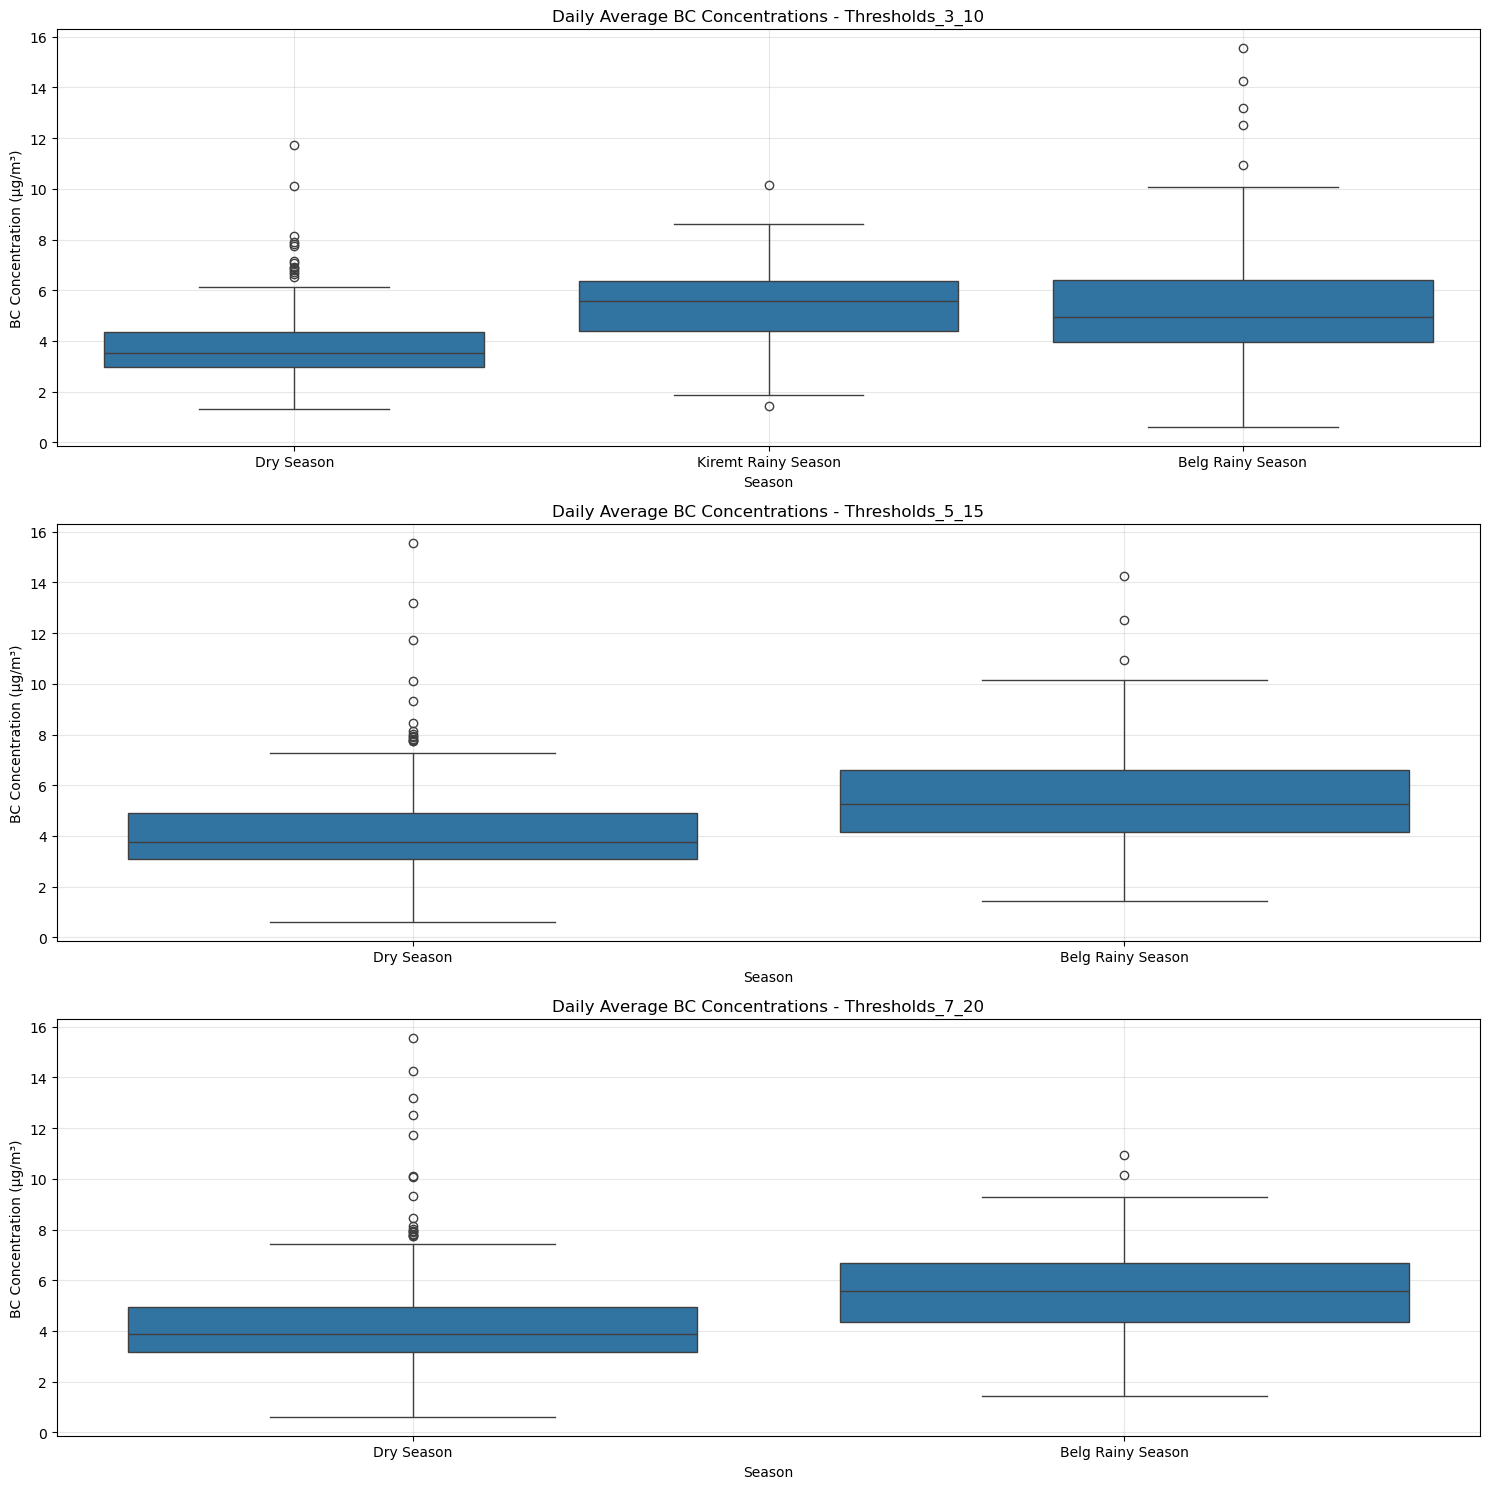


Seasonal Transition Dates:

Thresholds_3_10:
Season Changes:
2016-01-01: Transition to Dry Season
2022-06-28: Transition to Belg Rainy Season
2022-07-23: Transition to Kiremt Rainy Season
2022-08-29: Transition to Belg Rainy Season
2022-10-13: Transition to Dry Season
2023-03-17: Transition to Belg Rainy Season
2023-07-27: Transition to Kiremt Rainy Season
2023-08-26: Transition to Belg Rainy Season
2023-10-15: Transition to Dry Season
2024-03-09: Transition to Belg Rainy Season
2024-03-14: Transition to Dry Season
2024-03-26: Transition to Belg Rainy Season
2024-05-21: Transition to Dry Season
2024-07-01: Transition to Belg Rainy Season
2024-08-08: Transition to Kiremt Rainy Season
2024-08-12: Transition to Belg Rainy Season
2024-10-27: Transition to Dry Season

Thresholds_5_15:
Season Changes:
2016-01-01: Transition to Dry Season
2022-07-03: Transition to Belg Rainy Season
2022-10-06: Transition to Dry Season
2023-03-23: Transition to Belg Rainy Season
2023-04-17: Transition to Dry 

In [49]:
# %% [markdown]
# # 11. Precipitation Threshold Sensitivity Analysis
# 
# This section examines how different precipitation thresholds affect seasonal classifications and BC patterns.

# %%
import itertools
def test_precipitation_thresholds(daily_precip, bc_df, threshold_sets):
    """
    Test different precipitation threshold combinations for seasonal classification
    
    Parameters:
    daily_precip: Series with daily precipitation data
    bc_df: DataFrame with BC measurements
    threshold_sets: List of tuples [(lower_threshold, upper_threshold)]
    """
    results = {}
    
    for lower, upper in threshold_sets:
        # Calculate 30-day rolling sum of precipitation
        rolling_precip = daily_precip.rolling(window=30, min_periods=1).sum()
        
        # Define seasons based on current thresholds
        seasons = pd.Series(index=daily_precip.index, dtype='str')
        seasons[rolling_precip <= lower*30] = 'Dry Season'
        seasons[(rolling_precip > lower*30) & (rolling_precip <= upper*30)] = 'Belg Rainy Season'
        seasons[rolling_precip > upper*30] = 'Kiremt Rainy Season'
        
        # Resample to hourly frequency
        hourly_seasons = seasons.resample('H').ffill()
        
        # Store results
        results[f'Thresholds_{lower}_{upper}'] = hourly_seasons
    
    return results

def compare_threshold_classifications(threshold_results, bc_df):
    """
    Compare seasonal classifications and BC patterns across different thresholds
    """
    # Calculate statistics for each threshold set
    stat_results = {}
    
    for thresh_name, seasons in threshold_results.items():
        # Merge seasons with BC data
        merged = pd.merge(
            bc_df['IR BC1'],
            seasons.to_frame('Season'),
            left_index=True,
            right_index=True,
            how='inner'
        )
        
        # Calculate seasonal statistics
        stats = merged.groupby('Season')['IR BC1'].agg(['mean', 'std', 'count'])
        stat_results[thresh_name] = stats
    
    return stat_results

def plot_threshold_comparisons(threshold_results, bc_df):
    """
    Create visualization comparing different threshold classifications
    """
    n_thresholds = len(threshold_results)
    fig, axes = plt.subplots(n_thresholds, 1, figsize=(15, 5*n_thresholds))
    
    if n_thresholds == 1:
        axes = [axes]
    
    for idx, (thresh_name, seasons) in enumerate(threshold_results.items()):
        # Merge data
        merged = pd.merge(
            bc_df['IR BC1'],
            seasons.to_frame('Season'),
            left_index=True,
            right_index=True,
            how='inner'
        )
        
        # Create boxplot
        sns.boxplot(data=merged, x='Season', y='IR BC1', ax=axes[idx])
        
        # Format plot
        lower, upper = map(float, thresh_name.split('_')[1:])
        axes[idx].set_title(f'Thresholds: {lower}mm and {upper}mm')
        axes[idx].set_xlabel('Season')
        axes[idx].set_ylabel('BC Concentration (µg/m³)')
        axes[idx].grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig

def calculate_classification_agreement(threshold_results):
    """
    Calculate agreement between different threshold classifications
    """
    threshold_pairs = list(itertools.combinations(threshold_results.keys(), 2))
    agreement_stats = {}
    
    for thresh1, thresh2 in threshold_pairs:
        # Resample both to daily frequency for comparison
        seasons1 = threshold_results[thresh1].resample('D').last()
        seasons2 = threshold_results[thresh2].resample('D').last()
        
        # Calculate agreement percentage
        agreement = (seasons1 == seasons2).mean() * 100
        
        # Create confusion matrix
        confusion = pd.crosstab(seasons1, seasons2)
        
        agreement_stats[f"{thresh1}_vs_{thresh2}"] = {
            'agreement_percentage': agreement,
            'confusion_matrix': confusion
        }
    
    return agreement_stats

# Define threshold combinations to test
threshold_sets = [
    (3, 10),   # Conservative thresholds
    (5, 15),   # Original thresholds
    (7, 20)    # Liberal thresholds
]

# Run analysis with different thresholds
print("Testing different precipitation thresholds...")
threshold_results = test_precipitation_thresholds(daily_precip, bc_filtered, threshold_sets)

print("\nCalculating statistics for each threshold set...")
threshold_stats = compare_threshold_classifications(threshold_results, bc_filtered)

print("\nCalculating classification agreement...")
agreement_stats = calculate_classification_agreement(threshold_results)

# Print summary statistics
print("\nSummary Statistics by Threshold:")
for thresh_name, stats in threshold_stats.items():
    print(f"\n{thresh_name}:")
    print(stats.round(3))

print("\nClassification Agreement Statistics:")
for comparison, stats in agreement_stats.items():
    print(f"\n{comparison}:")
    print(f"Agreement: {stats['agreement_percentage']:.1f}%")
    print("\nConfusion Matrix:")
    print(stats['confusion_matrix'])

# Create additional analysis of BC patterns within each classification
print("\nAnalyzing BC patterns within each classification scheme...")
fig, axes = plt.subplots(len(threshold_results), 1, figsize=(15, 5*len(threshold_results)))
if len(threshold_results) == 1:
    axes = [axes]

for idx, (thresh_name, seasons) in enumerate(threshold_results.items()):
    merged = pd.merge(
        bc_filtered['IR BC1'],
        seasons.to_frame('Season'),
        left_index=True,
        right_index=True,
        how='inner'
    )
    
    # Calculate and plot daily averages by season
    daily_avg = merged.groupby([merged.index.date, 'Season'])['IR BC1'].mean().reset_index()
    
    sns.boxplot(data=daily_avg, x='Season', y='IR BC1', ax=axes[idx])
    axes[idx].set_title(f'Daily Average BC Concentrations - {thresh_name}')
    axes[idx].set_xlabel('Season')
    axes[idx].set_ylabel('BC Concentration (µg/m³)')
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Calculate and display seasonal transition dates for each threshold set
print("\nSeasonal Transition Dates:")
for thresh_name, seasons in threshold_results.items():
    print(f"\n{thresh_name}:")
    # Find dates where season changes
    transitions = seasons[seasons != seasons.shift()]
    print("Season Changes:")
    for date, season in transitions.items():
        print(f"{date.strftime('%Y-%m-%d')}: Transition to {season}")

Calculating stable seasonal transitions...

Stable Seasonal Transition Dates:

Stable_3_10:
Season Changes:
2022-01-01: Transition to Dry Season
2022-06-30: Transition to Belg Rainy Season
2022-10-15: Transition to Dry Season
2023-03-18: Transition to Belg Rainy Season
2023-10-19: Transition to Dry Season
2024-03-28: Transition to Belg Rainy Season
2024-05-26: Transition to Dry Season
2024-07-03: Transition to Belg Rainy Season
2024-11-10: Transition to Dry Season

Stable_5_15:
Season Changes:
2022-01-01: Transition to Dry Season
2022-07-08: Transition to Belg Rainy Season
2022-10-09: Transition to Dry Season
2023-05-07: Transition to Belg Rainy Season
2023-10-10: Transition to Dry Season
2024-07-13: Transition to Belg Rainy Season
2024-10-07: Transition to Dry Season

Stable_7_20:
Season Changes:
2022-01-01: Transition to Dry Season
2022-07-16: Transition to Belg Rainy Season
2022-10-05: Transition to Dry Season
2023-07-21: Transition to Belg Rainy Season
2023-10-04: Transition to Dry

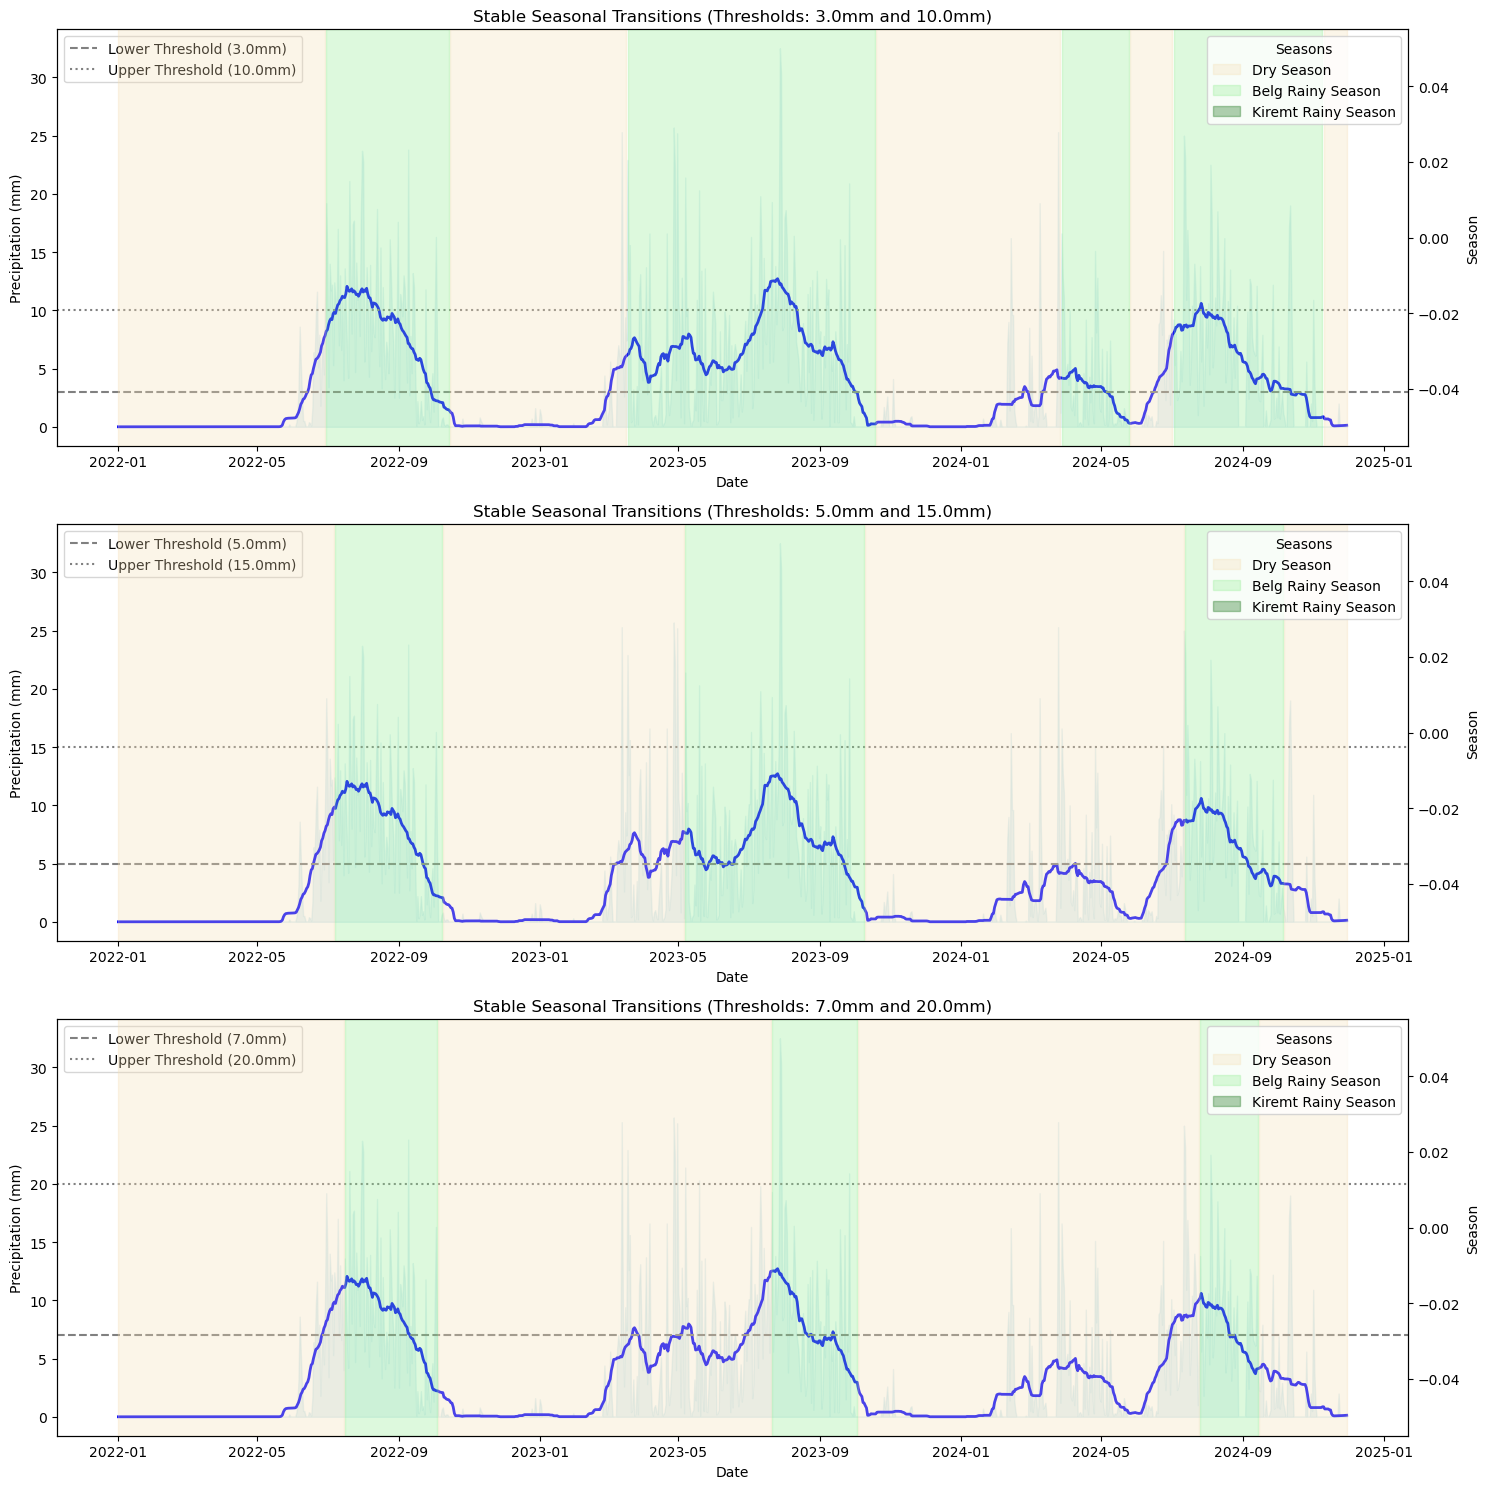

In [52]:
# %% [markdown]
# ## 11.1 Smoothed Seasonal Transitions
# 
# Implementing a more stable seasonal classification approach using:
# - 30-day rolling averages for precipitation
# - Hysteresis thresholds to prevent rapid transitions
# - Minimum duration requirements for each season

# %%
def define_stable_seasons(daily_precip, threshold_sets, min_duration_days=14):
    """
    Define seasons with stability controls to prevent rapid transitions
    
    Parameters:
    daily_precip: Series with daily precipitation data
    threshold_sets: List of tuples [(lower_threshold, upper_threshold)]
    min_duration_days: Minimum days required before allowing season change
    """
    results = {}
    
    # Filter data to start from 2022
    daily_precip = daily_precip['2022':]
    
    for lower, upper in threshold_sets:
        # Calculate 30-day rolling sum with centered window
        rolling_precip = daily_precip.rolling(window=30, center=True, min_periods=15).mean()
        
        # Add hysteresis by creating different thresholds for transitions
        # Require more rainfall to enter wet season, less to exit
        enter_wet_threshold = lower * 1.2  # 20% higher to enter wet season
        exit_wet_threshold = lower * 0.8   # 20% lower to exit wet season
        enter_heavy_threshold = upper * 1.2
        exit_heavy_threshold = upper * 0.8
        
        # Initialize seasons
        seasons = pd.Series(index=daily_precip.index, dtype='str')
        seasons.loc[:] = 'Dry Season'  # Start with all dry
        
        # Initial classification
        current_season = 'Dry Season'
        transition_date = None
        season_duration = 0
        
        for date in rolling_precip.index:
            precip_value = rolling_precip[date]
            
            # Determine target season based on precipitation and current season
            if current_season == 'Dry Season':
                if precip_value > enter_wet_threshold:
                    target_season = 'Belg Rainy Season'
                else:
                    target_season = 'Dry Season'
            elif current_season == 'Belg Rainy Season':
                if precip_value > enter_heavy_threshold:
                    target_season = 'Kiremt Rainy Season'
                elif precip_value < exit_wet_threshold:
                    target_season = 'Dry Season'
                else:
                    target_season = 'Belg Rainy Season'
            else:  # Kiremt Rainy Season
                if precip_value < exit_heavy_threshold:
                    target_season = 'Belg Rainy Season'
                else:
                    target_season = 'Kiremt Rainy Season'
            
            # Check if we should transition
            if target_season != current_season:
                if transition_date is None:
                    transition_date = date
                    season_duration = 0
                elif (date - transition_date).days >= min_duration_days:
                    current_season = target_season
                    transition_date = None
                    season_duration = 0
            else:
                transition_date = None
                season_duration += 1
            
            seasons[date] = current_season
        
        # Store results
        results[f'Stable_{lower}_{upper}'] = seasons
    
    return results

def plot_stable_transitions(threshold_results, daily_precip):
    """
    Visualize the stable seasonal transitions with precipitation data
    """
    fig, axes = plt.subplots(len(threshold_results), 1, figsize=(15, 5*len(threshold_results)))
    
    if len(threshold_results) == 1:
        axes = [axes]
    
    # Filter precipitation data to match threshold results
    daily_precip = daily_precip['2022':]
    
    for idx, (thresh_name, seasons) in enumerate(threshold_results.items()):
        ax1 = axes[idx]
        ax2 = ax1.twinx()
        
        # Plot precipitation
        rolling_precip = daily_precip.rolling(window=30, center=True, min_periods=15).mean()
        ax1.fill_between(daily_precip.index, daily_precip, color='lightblue', alpha=0.3)
        ax1.plot(rolling_precip.index, rolling_precip, color='blue', linewidth=2)
        
        # Plot seasons as background colors
        season_values = pd.Series(1, index=seasons.index)  # Dummy values for plotting
        season_colors = {'Dry Season': 'wheat', 
                        'Belg Rainy Season': 'lightgreen',
                        'Kiremt Rainy Season': 'darkgreen'}
        
        for season in season_colors:
            mask = seasons == season
            ax2.fill_between(seasons.index, 0, 1, 
                           where=mask, color=season_colors[season], 
                           alpha=0.3, transform=ax2.get_xaxis_transform())
        
        # Customize plot
        lower, upper = map(float, thresh_name.split('_')[1:])
        ax1.set_title(f'Stable Seasonal Transitions (Thresholds: {lower}mm and {upper}mm)')
        ax1.set_xlabel('Date')
        ax1.set_ylabel('Precipitation (mm)')
        ax2.set_ylabel('Season')
        
        # Add legend
        ax1.axhline(y=lower, color='gray', linestyle='--', label=f'Lower Threshold ({lower}mm)')
        ax1.axhline(y=upper, color='gray', linestyle=':', label=f'Upper Threshold ({upper}mm)')
        
        # Add season labels
        handles = [plt.Rectangle((0,0),1,1, color=color, alpha=0.3) 
                  for color in season_colors.values()]
        ax2.legend(handles, season_colors.keys(), 
                  loc='upper right', title='Seasons')
        ax1.legend(loc='upper left')
    
    plt.tight_layout()
    return fig

# Run analysis with stable transitions
print("Calculating stable seasonal transitions...")
stable_results = define_stable_seasons(daily_precip, threshold_sets)

# Print transition dates for stable classifications
print("\nStable Seasonal Transition Dates:")
for thresh_name, seasons in stable_results.items():
    print(f"\n{thresh_name}:")
    transitions = seasons[seasons != seasons.shift()]
    print("Season Changes:")
    for date, season in transitions.items():
        print(f"{date.strftime('%Y-%m-%d')}: Transition to {season}")

# Calculate statistics for stable classifications
print("\nStable Classification Statistics:")
for thresh_name, seasons in stable_results.items():
    # Convert to hourly for BC comparison
    hourly_seasons = seasons.resample('h').ffill()
    
    # Merge with BC data
    merged = pd.merge(
        bc_filtered['IR BC1'],
        hourly_seasons.to_frame('Season'),
        left_index=True,
        right_index=True,
        how='inner'
    )
    
    print(f"\n{thresh_name}:")
    stats = merged.groupby('Season')['IR BC1'].agg(['mean', 'std', 'count'])
    print(stats.round(3))

# Plot stable transitions
plot_stable_transitions(stable_results, daily_precip)
plt.show()